# 简单的车道线检测（视频版）

##### 此notebook为首次尝试，主要目的熟悉使用opencv对图像做检测，选用了路况较为简单的高速路行车记录视频

In [1]:
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import numpy as np
import cv2

In [2]:
#GaussianBlur参数
blur_ksize = 5 
#Canny参数
canny_lthreshold = 70 
canny_hthreshold = 150 
#霍夫变换参数
rho = 1
theta = np.pi/180
threshold = 15
min_line_len = 10
max_line_gap = 30

In [3]:
def roi_mask(img, vertices):
    #创建mask
    mask = np.zeros_like(img)

    #定义颜色
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        mask_color = (255,) * channel_count
    else:
        mask_color = 255
    
    #填充多边形
    cv2.fillPoly(mask, vertices, mask_color)
    #合成图片
    masked_img = cv2.bitwise_and(img, mask)
    
    return masked_img

In [4]:
def draw_lines(img, lines, color = (0, 255, 0), thickness = 1):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1,y1), (x2,y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                minLineLength=min_line_len, 
                maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

    draw_lines(line_img, lines)
    return line_img

In [33]:
def draw_lanes(img, lines, color = (0, 255, 0), thickness = 6):
    left_lines, right_lines = [], []
    for line in lines:
        for x1,y1,x2,y2 in line:
            k = (y2 - y1) / (x2 - x1)
            if k > 0:
                right_lines.append(line)
            else:
                left_lines.append(line)
    if (len(left_lines) <= 0 or len(right_lines) <= 0):
        return img
    
    filtrate_lines(left_lines, 0.1)
    filtrate_lines(right_lines, 0.1)
                   
    left_points = [(x1, y1) for line in left_lines for x1,y1,x2,y2 in line]
    left_points = left_points + [(x2, y2) for line in left_lines for x1,y1,x2,y2 in line]
    right_points = [(x1, y1) for line in right_lines for x1,y1,x2,y2 in line]
    right_points = right_points + [(x2, y2) for line in right_lines for x1,y1,x2,y2 in line]
                   
    left_vtx = calc_lane_vertices(left_points, 480,img.shape[0])
    right_vtx = calc_lane_vertices(right_points, 480,img.shape[0])
                   
    cv2.line(img, left_vtx[0], left_vtx[1], color, thickness)
    cv2.line(img, right_vtx[0], right_vtx[1], color, thickness)
    #print('left_vtx:',left_vtx)
    #print('right_vtx:',right_vtx)
def filtrate_lines(lines, threshold):
    slope = [(y2 - y1) / (x2 - x1) for line in lines for x1, y1, x2, y2 in line]
    while len(lines) > 0:
        mean = np.mean(slope)
        diff = [abs(s - mean) for s in slope]
        idx = np.argmax(diff)
        if diff[idx] > threshold:
            slope.pop(idx)
            lines.pop(idx)
        else:
            break
                   
def calc_lane_vertices(point_list, ymin, ymax):
    x = [p[0] for p in point_list]
    y = [p[1] for p in point_list]
    fit = np.polyfit(y, x, 1)
    fit_fn = np.poly1d(fit)

    xmin = int(fit_fn(ymin))
    xmax = int(fit_fn(ymax))

    return [(xmin, ymin), (xmax, ymax)]

In [34]:
def process_an_image(img):
    #region of interest顶点
    roi_vtx = np.array([[(0, img.shape[0]), (550, 400), 
                         (600, 400), (img.shape[1], img.shape[0]-80)]])
    
    #因视频中车道线含黄色，灰度图不能直接滤出黄线，所以先定义两个mask分别滤出黄线和蓝线
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    '''
    >>> yellow = np.uint8([[[255, 255, 0]]])
    >>> hsv_yellow = cv2.cvtColor(yellow, cv2.COLOR_RGB2HSV)
    >>> hsv_yellow
    array([[[ 30, 255, 255]]], dtype=uint8)
    Now you take [H-10, 100,100] and [H+10, 255, 255] as lower bound and upper bound respectively
    '''
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # http://stackoverflow.com/questions/22588146/tracking-white-color-using-python-opencv
    lower_white = np.array([0, 0, 215])
    upper_white = np.array([180, 40, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    color_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    #灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    darken = (gray/3).astype(np.uint8)
    #plt.figure(figsize=(10,10))
    #plt.imshow(darken)
    
    color_masked = cv2.bitwise_or(darken, color_mask)
    #plt.figure(figsize=(10,10))
    #plt.imshow(color_masked)
    
    #高斯滤波去噪点
    blur_img = cv2.GaussianBlur(color_masked, (blur_ksize,blur_ksize), 0, 0)
    
    #Canny边界检测
    edges = cv2.Canny(blur_img, canny_lthreshold, canny_hthreshold)
    #plt.figure(figsize=(10,10))
    #plt.imshow(edges)
    
    #确定检测区域
    masked_edges = roi_mask(edges, roi_vtx) 
    plt.figure(figsize=(10,10))
    plt.imshow(masked_edges)
    #霍夫转换
    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    plt.figure(figsize=(10,10))
    plt.imshow(line_img)
    #拟合
    lanes = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)                  
    draw_lanes(lanes, lines)
    #plt.figure(figsize=(10,10))
    #plt.imshow(lanes)
    #叠加
    res_img = cv2.addWeighted(img, 0.8, lanes, 1, 0)
    
    return res_img

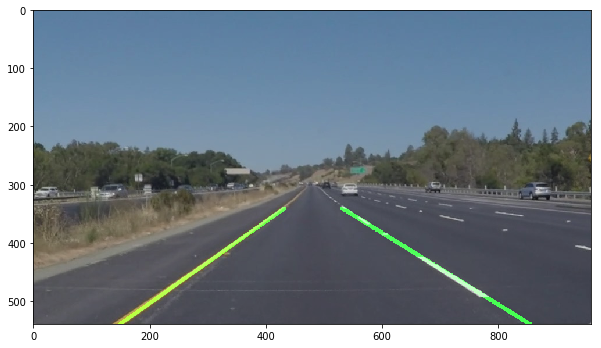

In [11]:
img = mplimg.imread("lane.jpg") 
res_img = process_an_image(img)
plt.figure(figsize=(10,10))
plt.imshow(res_img)

In [12]:
output = 'video_1_sol.mp4'
clip = VideoFileClip("video_1.mp4")
out_clip = clip.fl_image(process_an_image)
out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_1_sol.mp4
[MoviePy] Writing video video_1_sol.mp4


100%|█████████▉| 681/682 [00:21<00:00, 32.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_1_sol.mp4 



In [13]:
output = 'video_2_sol.mp4'
clip = VideoFileClip("video_2.mp4")
out_clip = clip.fl_image(process_an_image)
out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_2_sol.mp4
[MoviePy] Writing video video_2_sol.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_2_sol.mp4 



[MoviePy] >>>> Building video video_3_sol.mp4
[MoviePy] Writing video video_3_sol.mp4


100%|██████████| 251/251 [00:40<00:00,  7.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_3_sol.mp4 



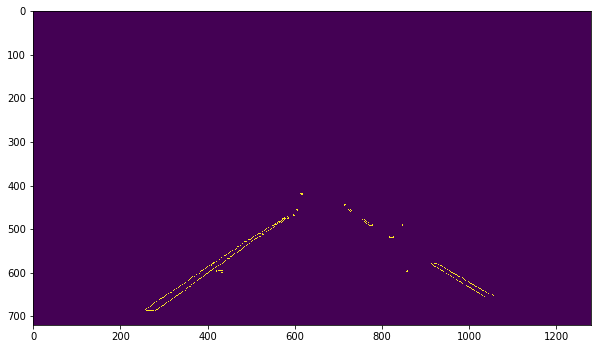

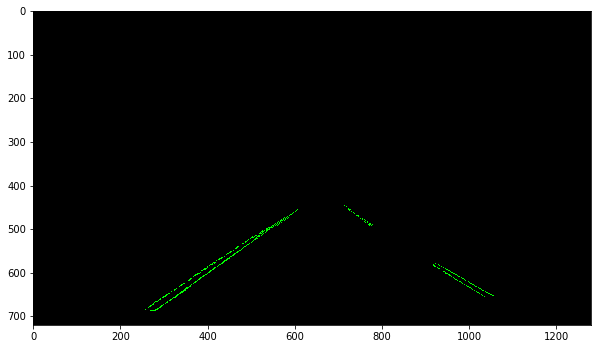

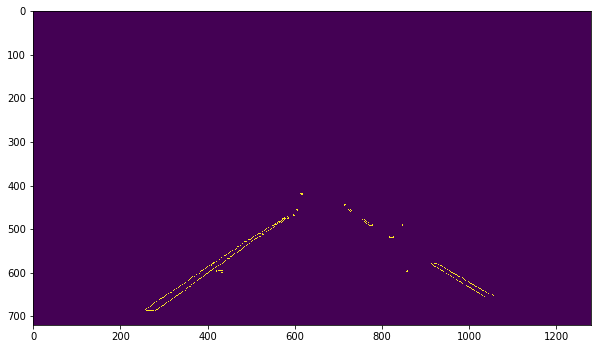

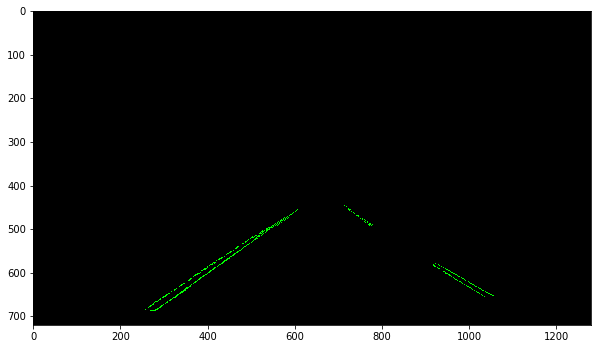

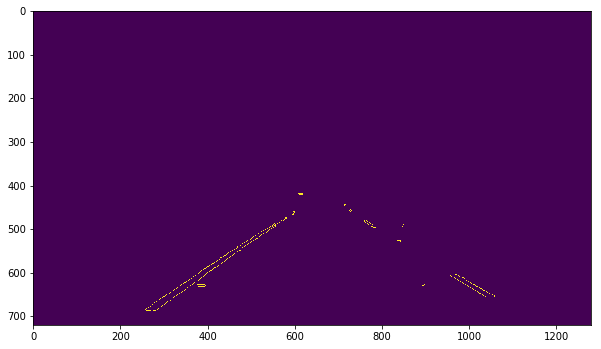

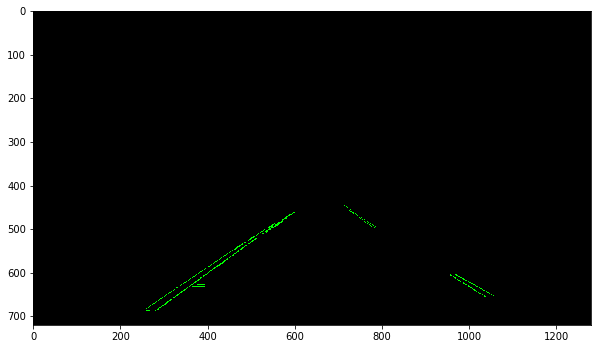

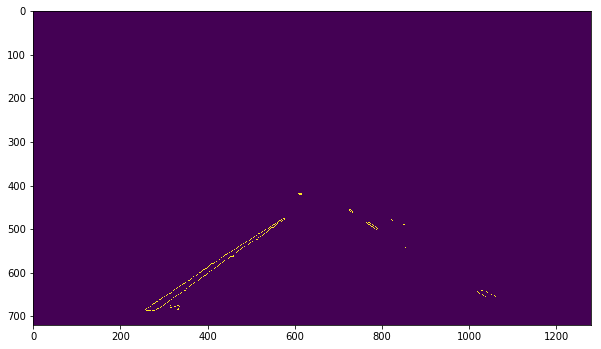

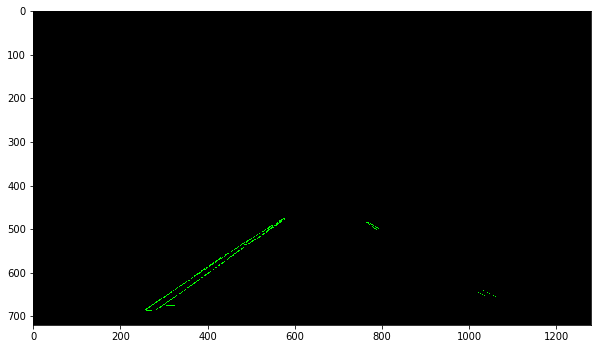

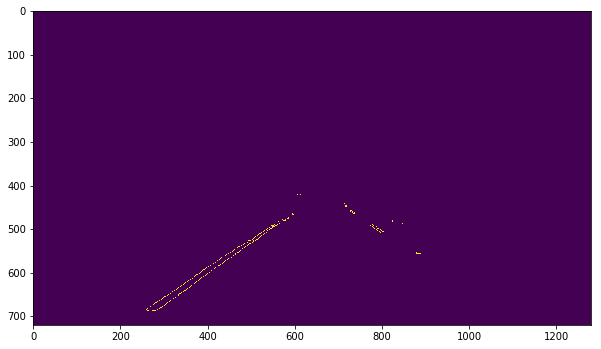

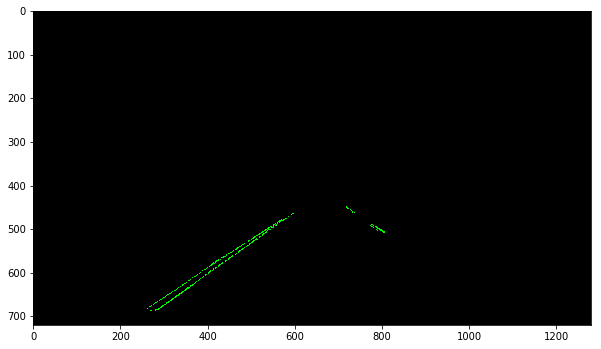

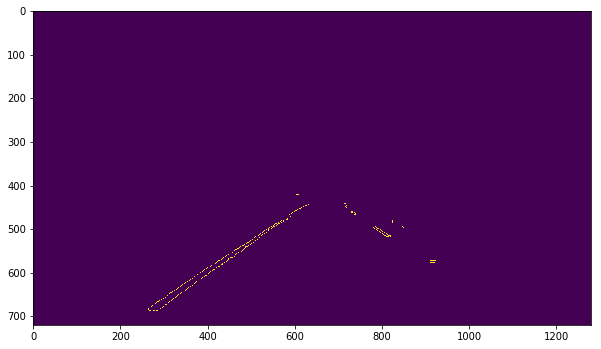

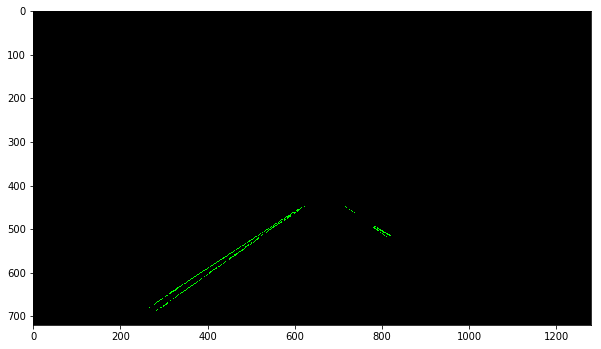

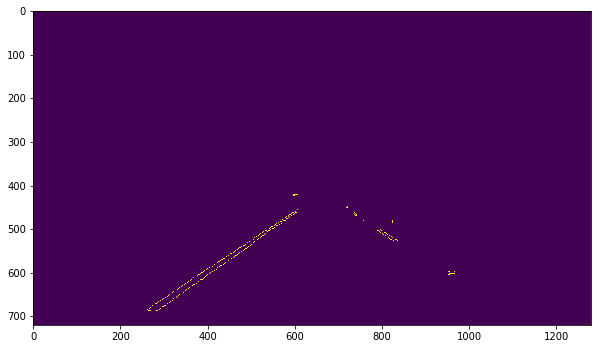

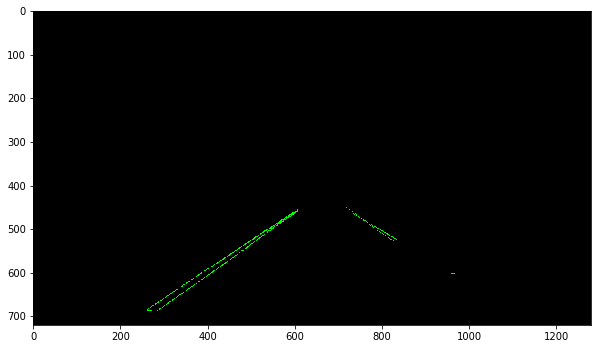

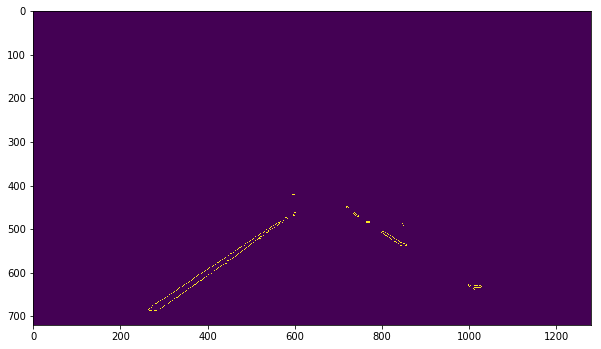

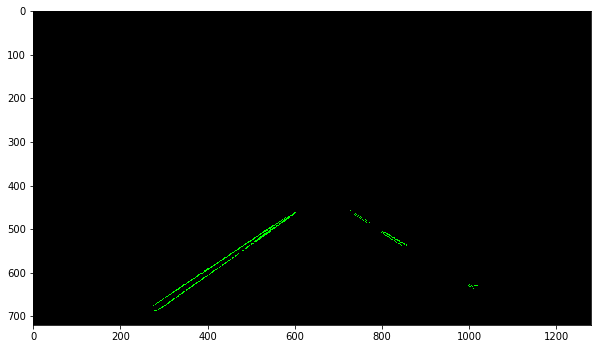

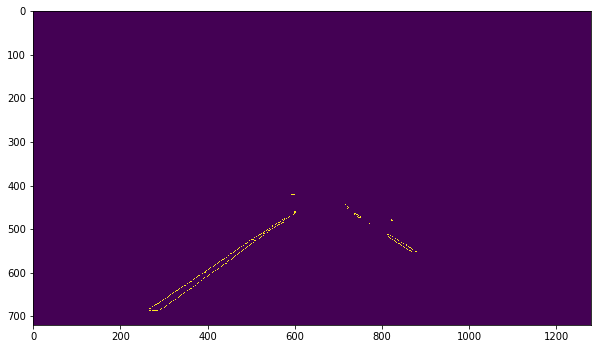

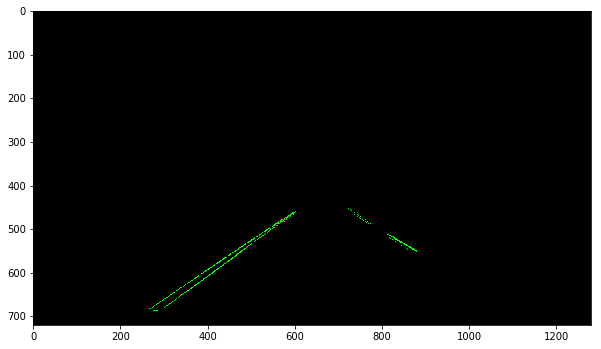

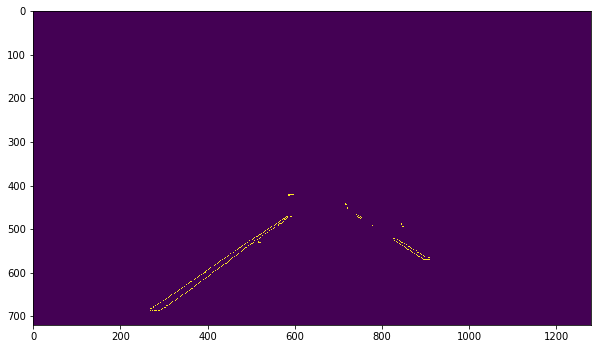

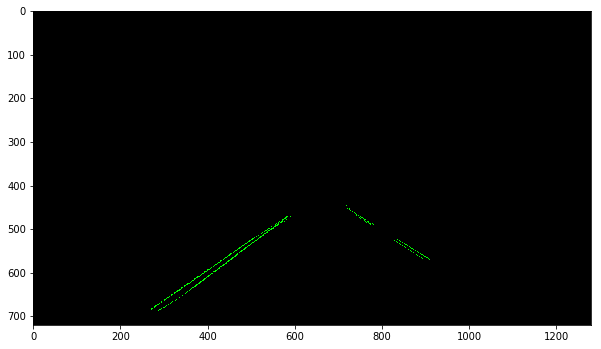

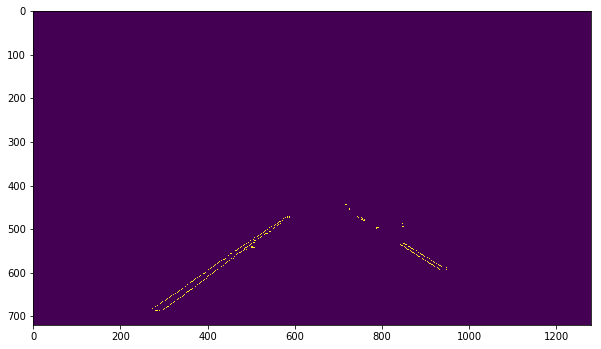

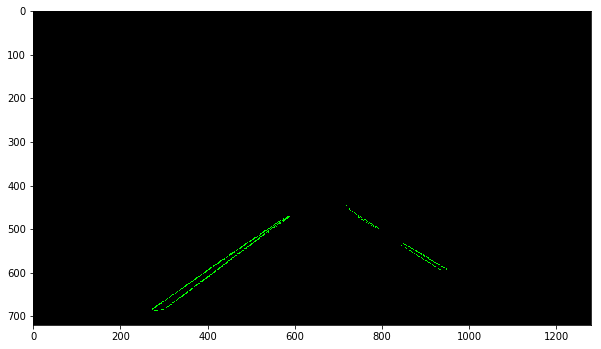

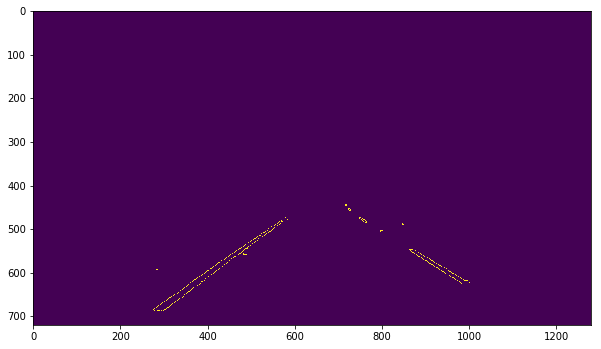

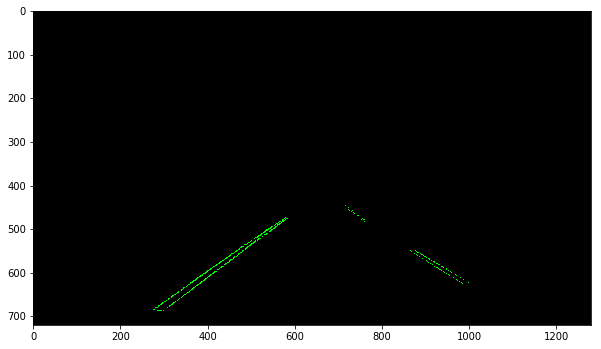

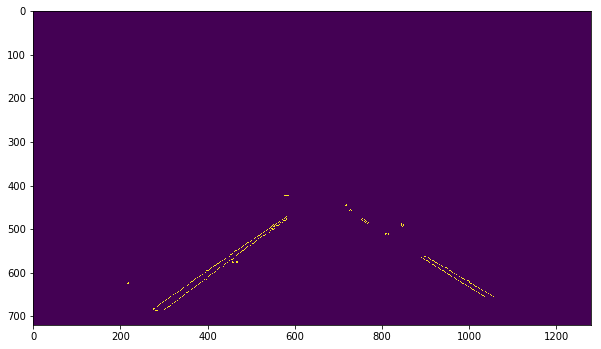

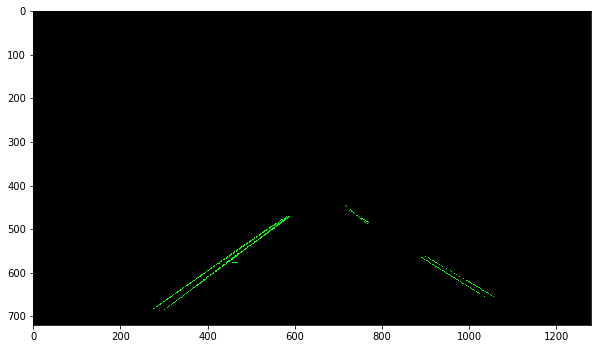

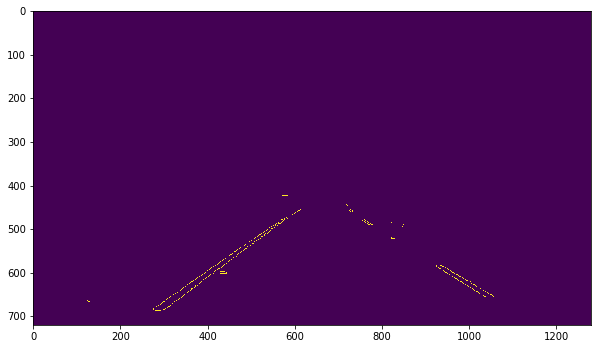

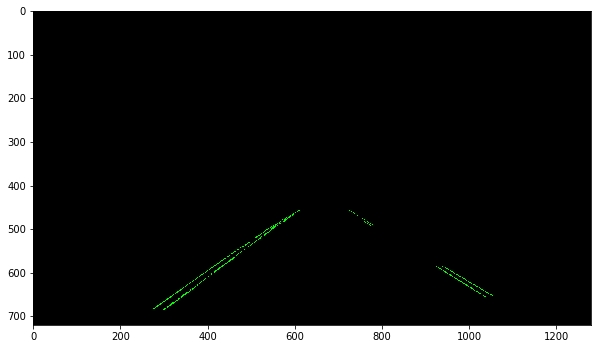

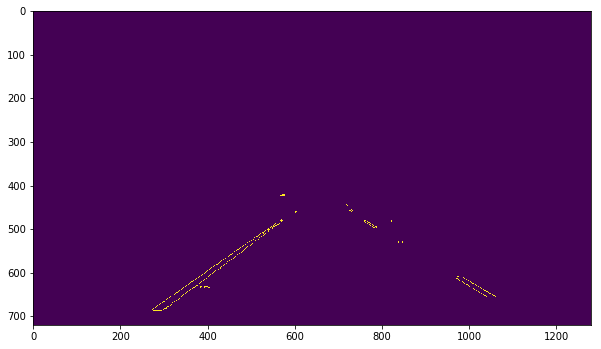

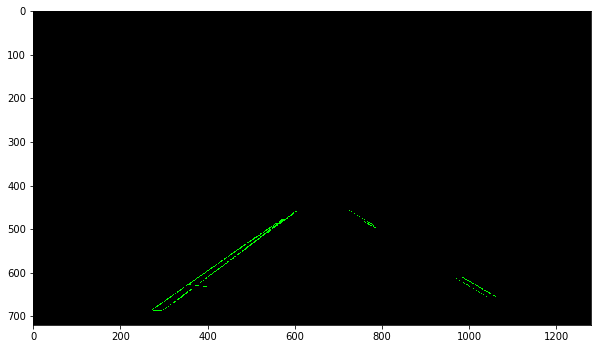

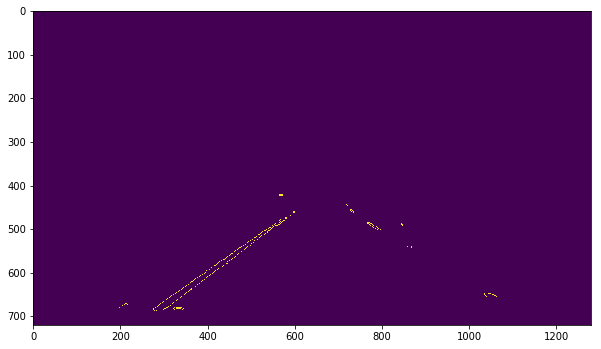

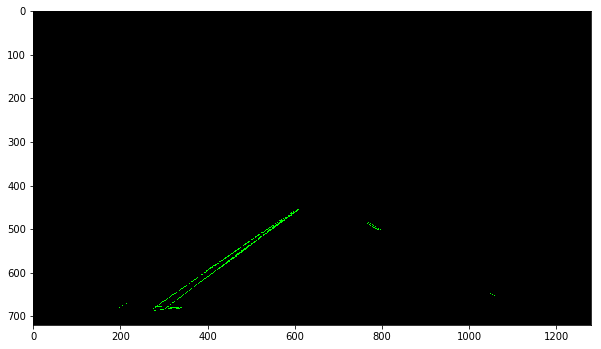

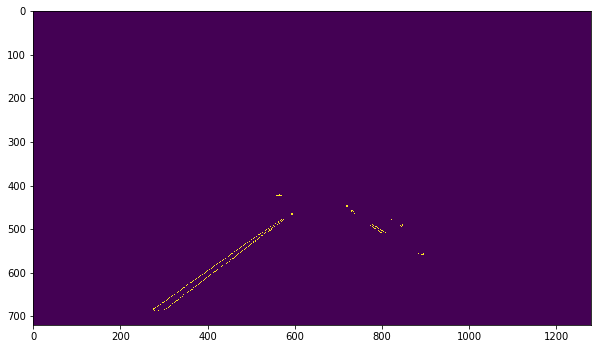

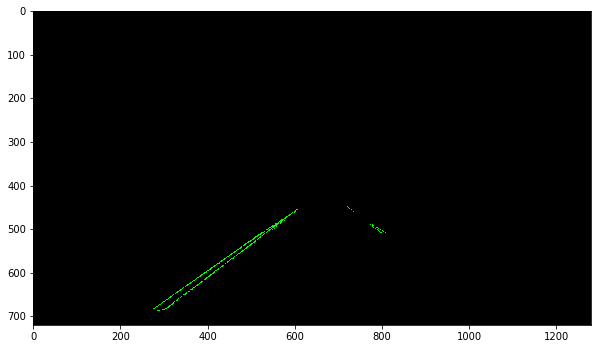

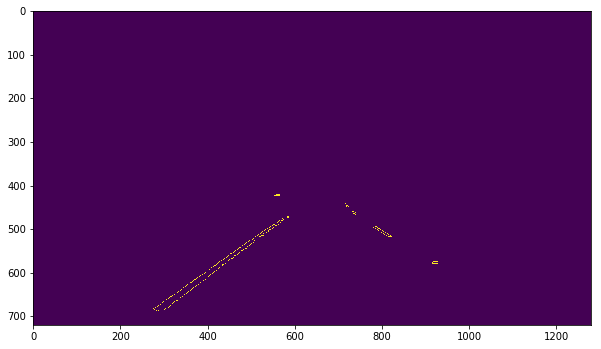

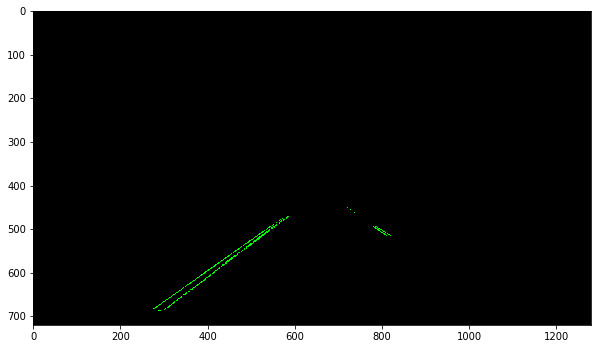

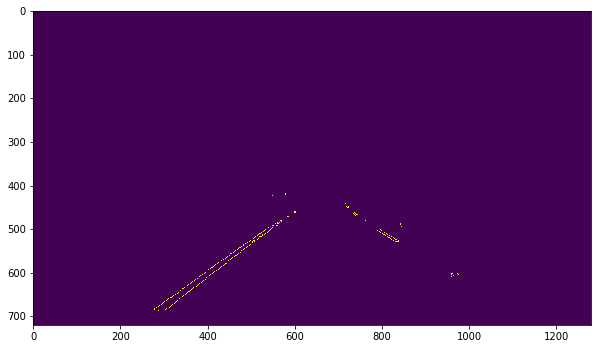

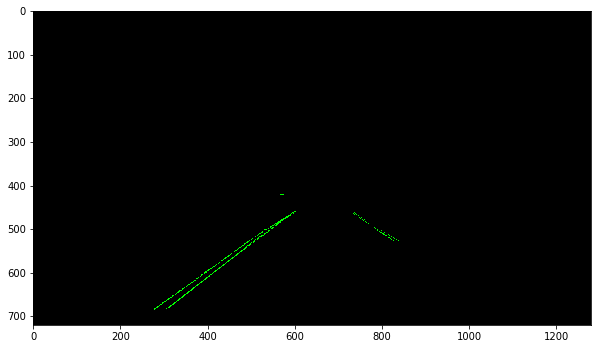

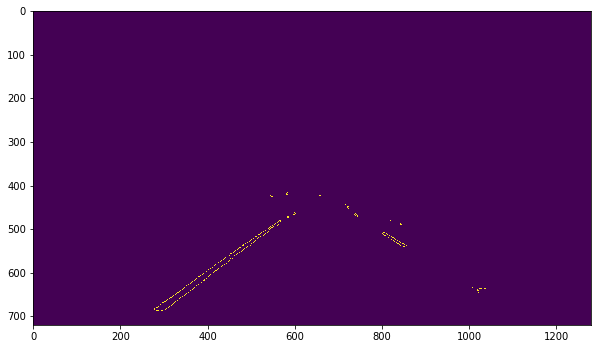

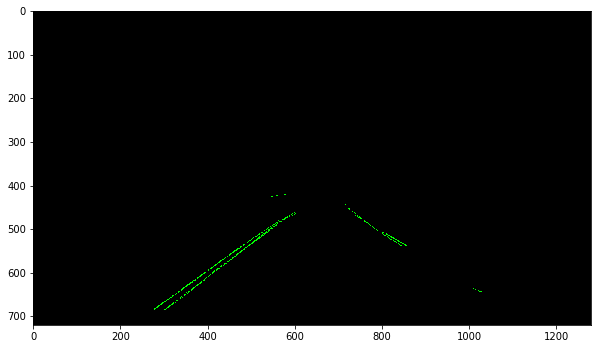

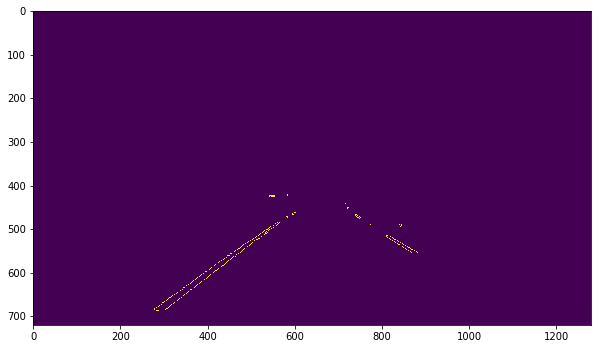

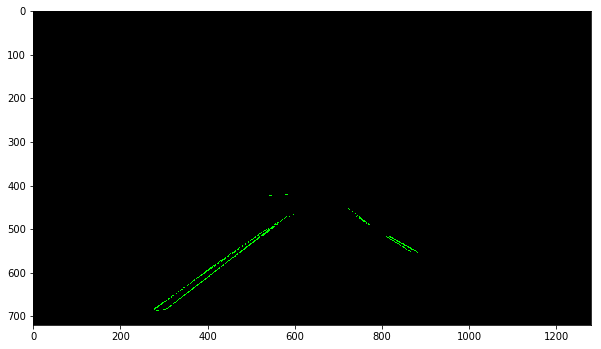

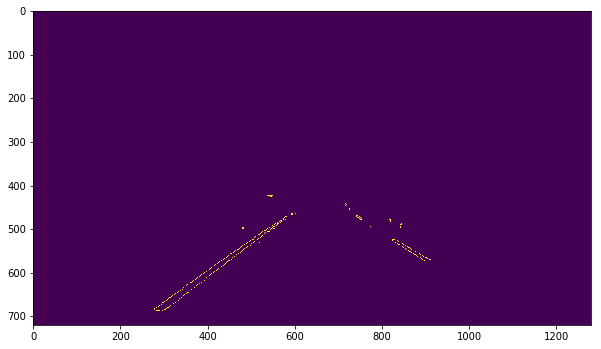

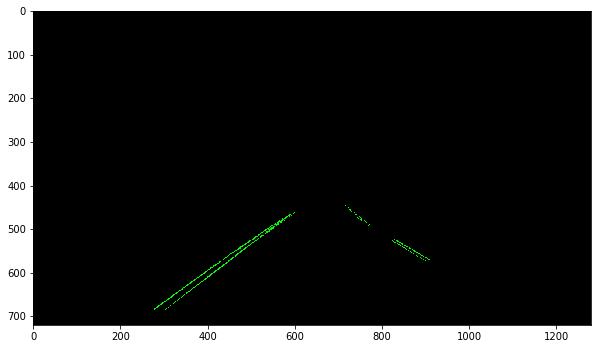

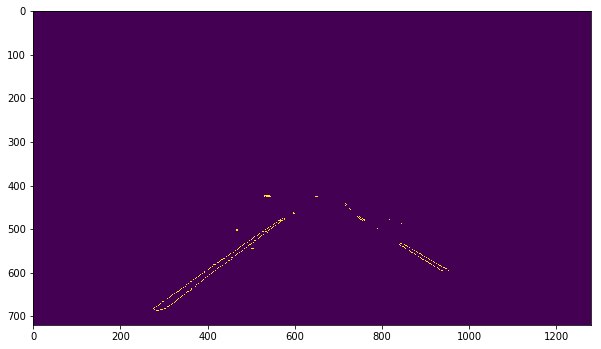

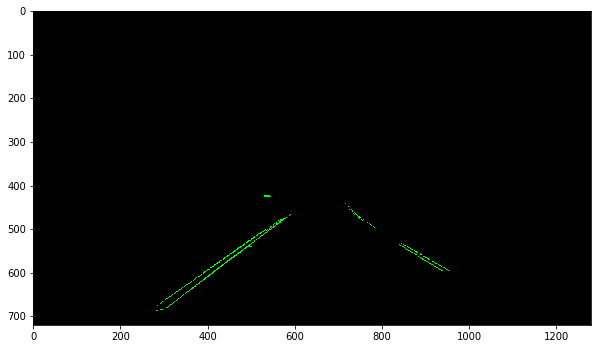

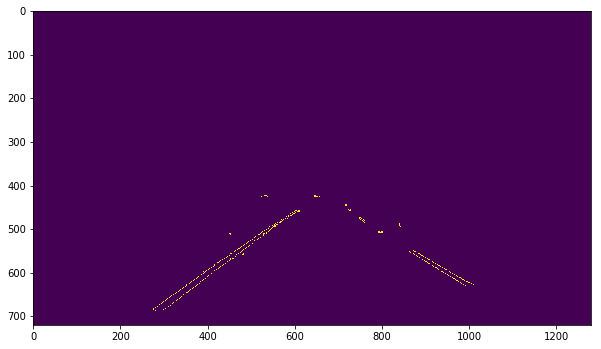

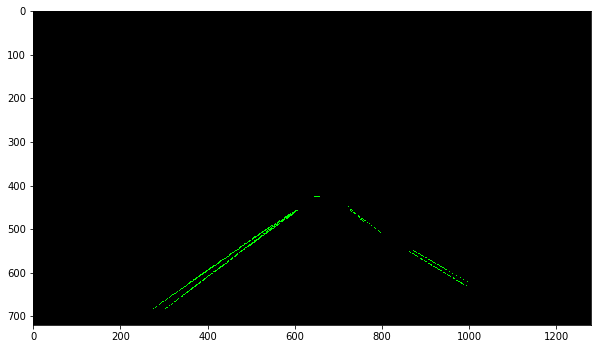

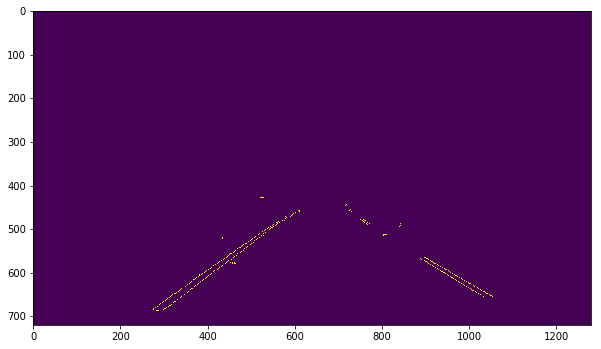

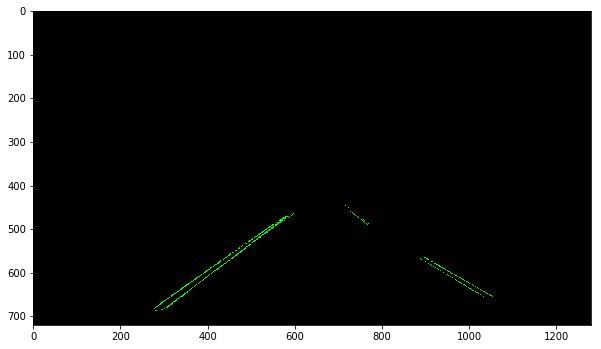

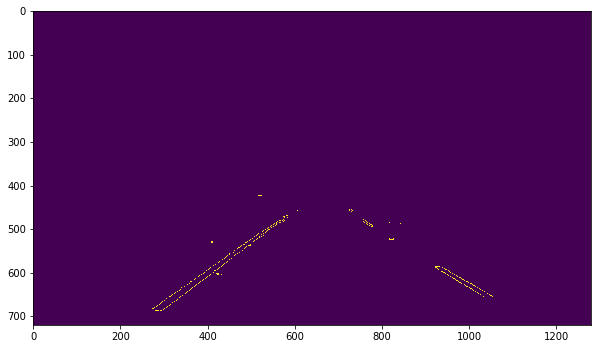

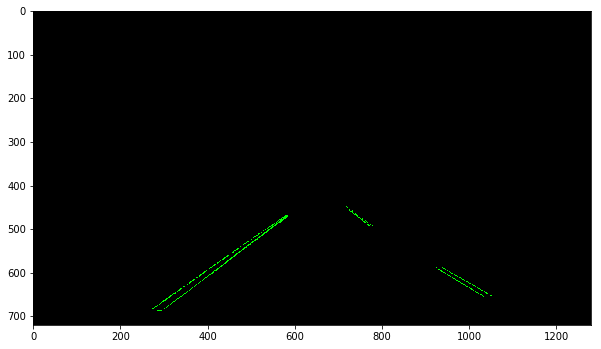

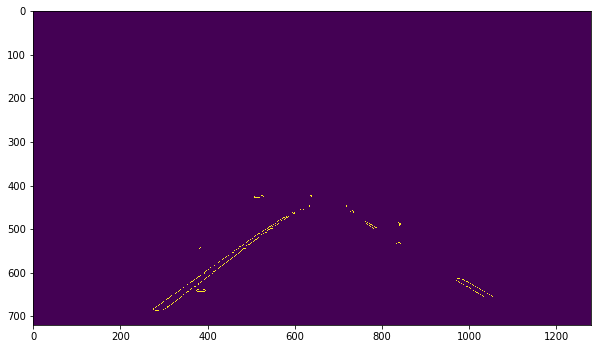

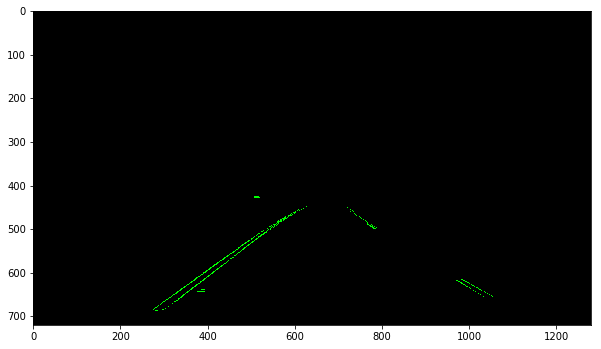

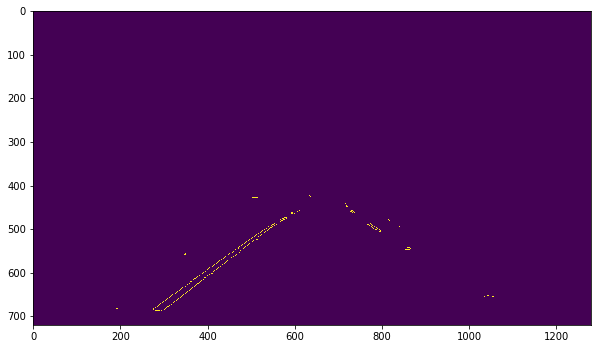

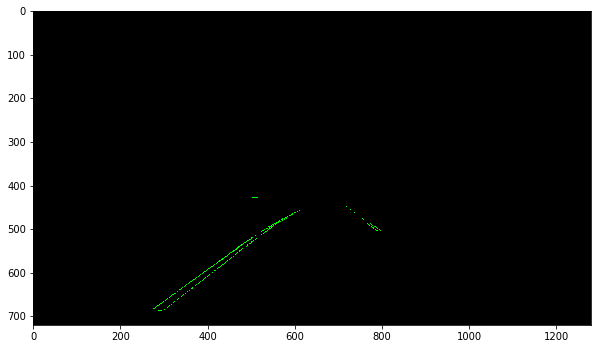

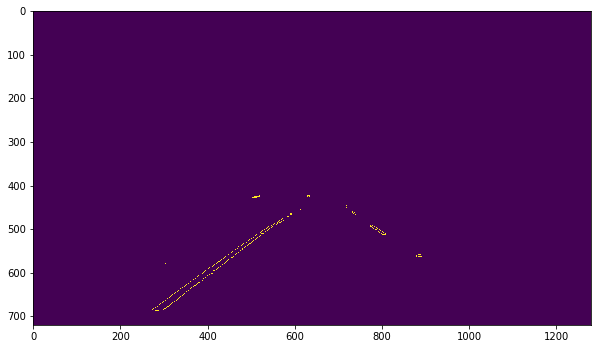

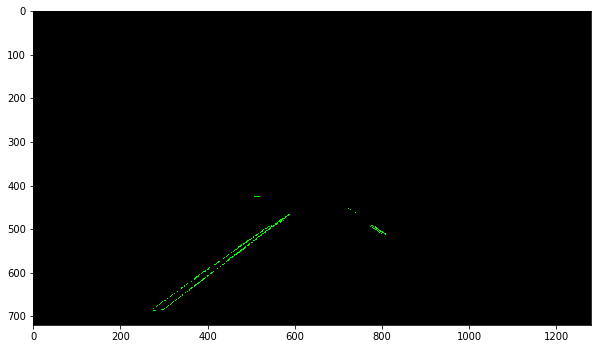

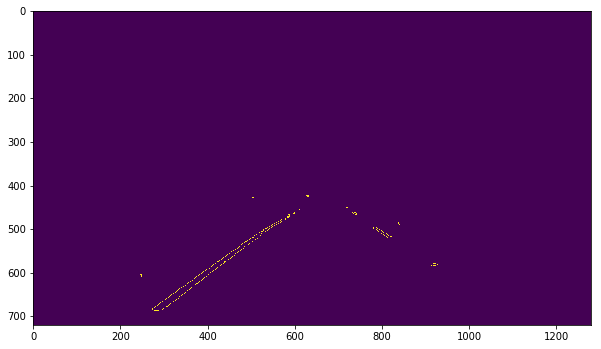

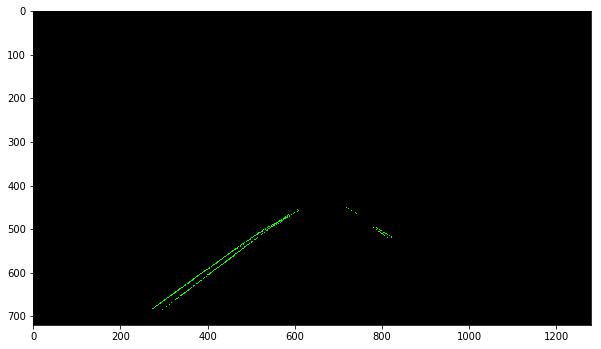

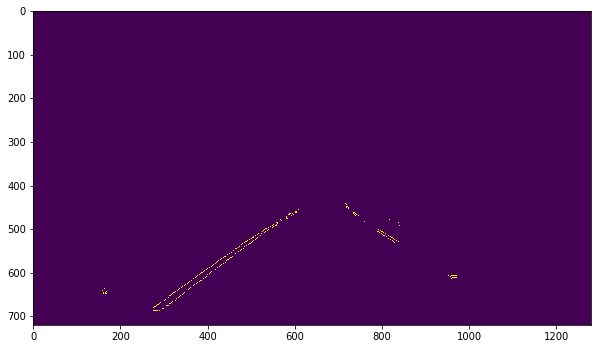

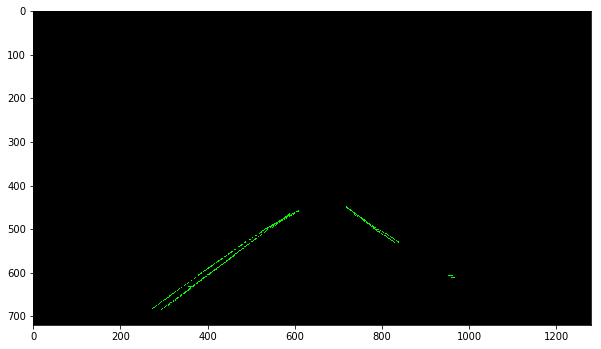

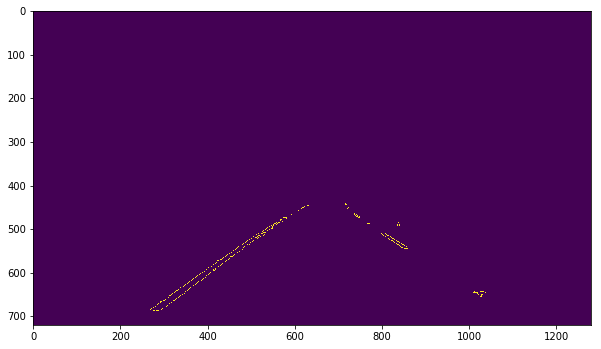

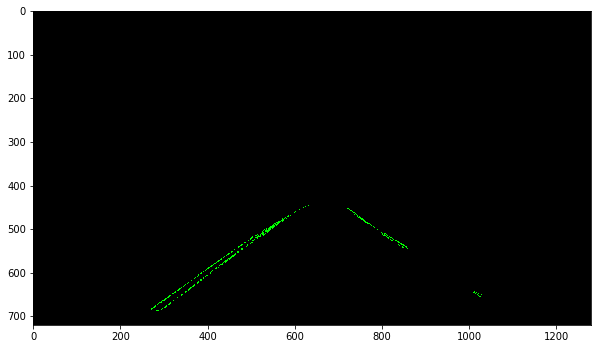

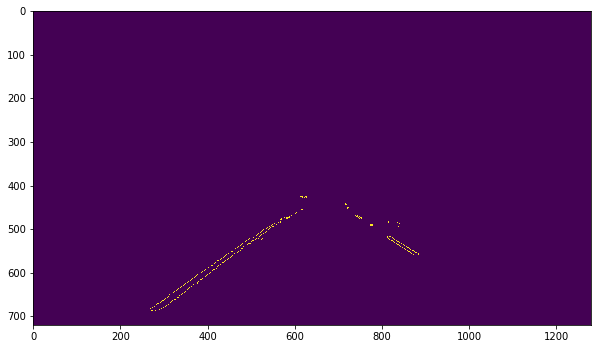

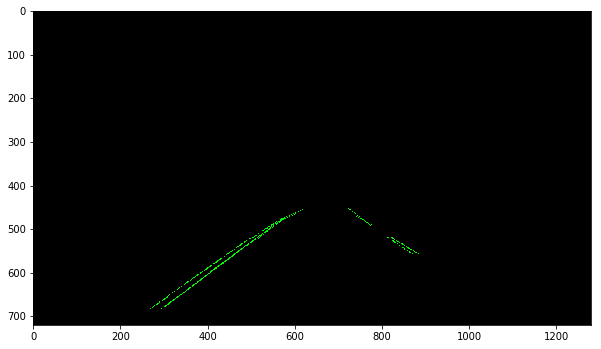

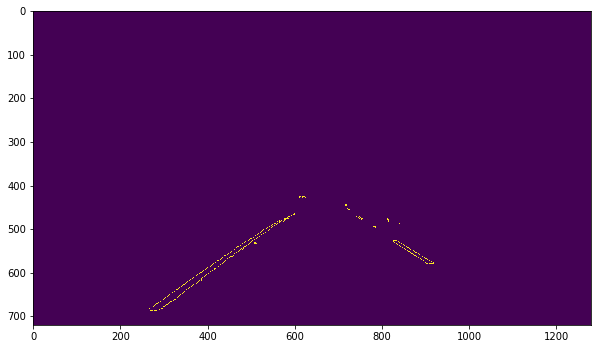

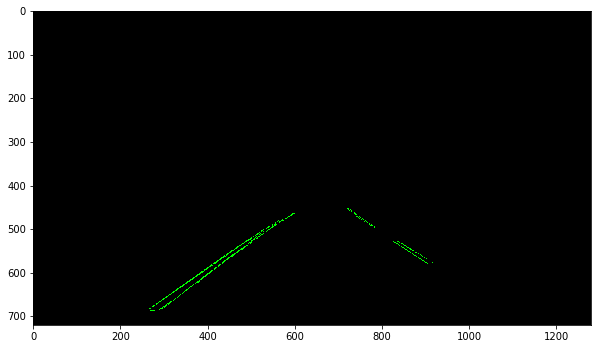

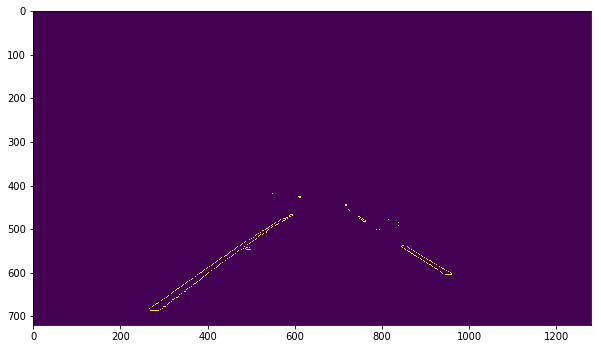

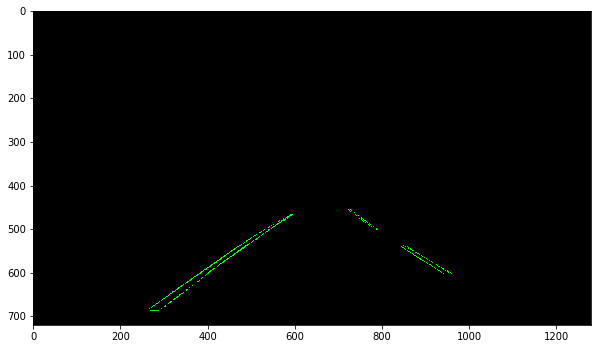

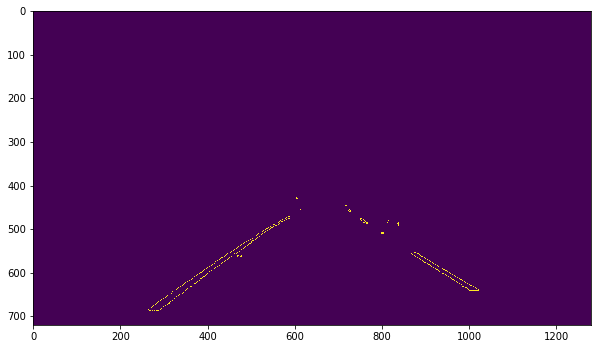

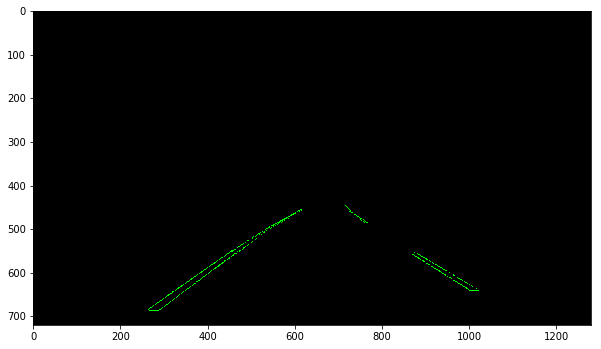

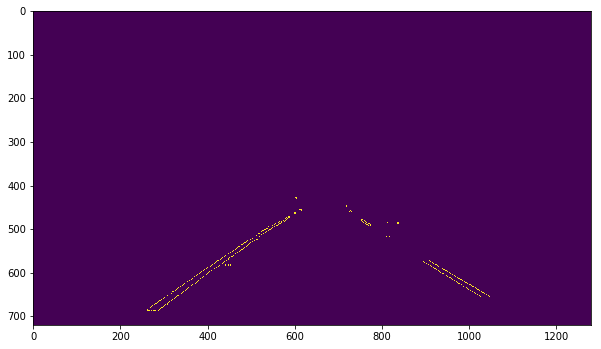

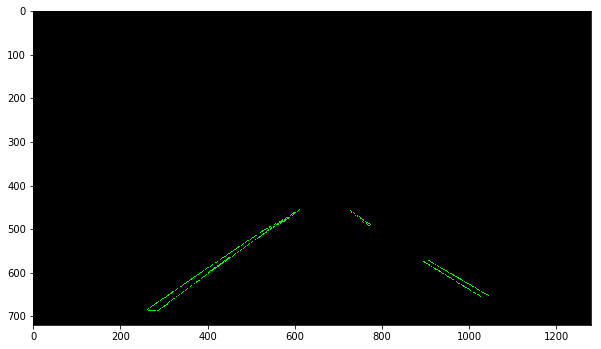

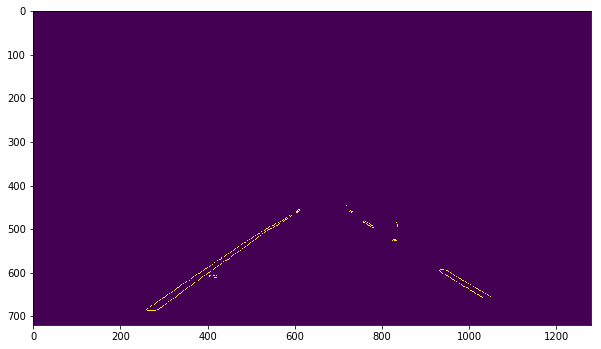

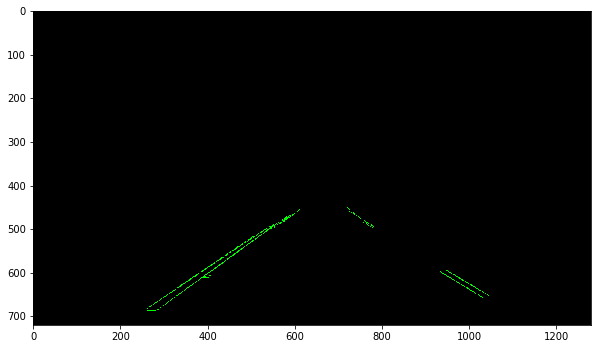

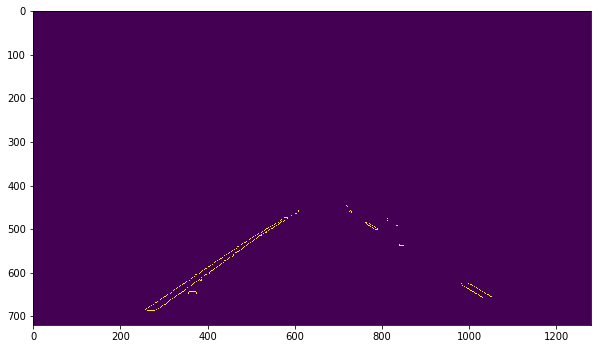

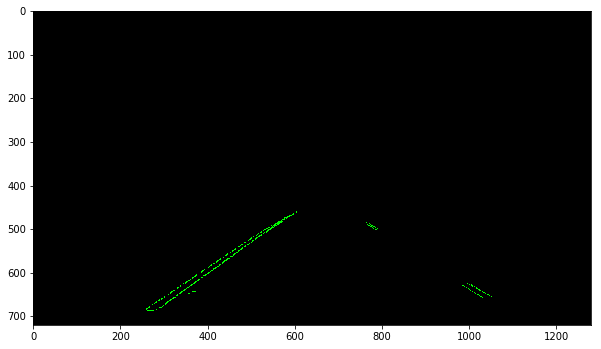

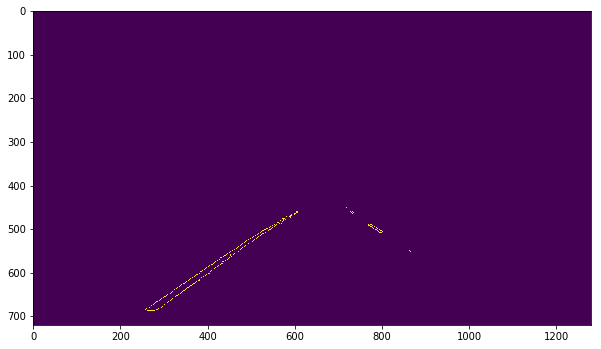

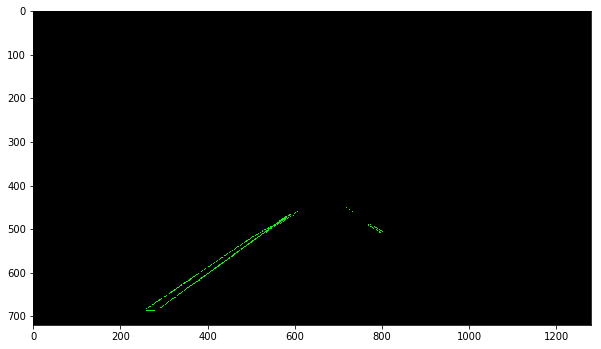

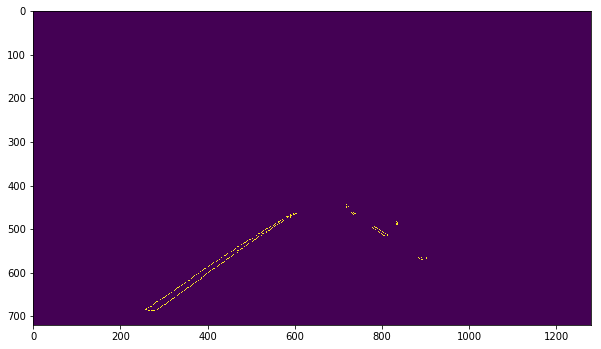

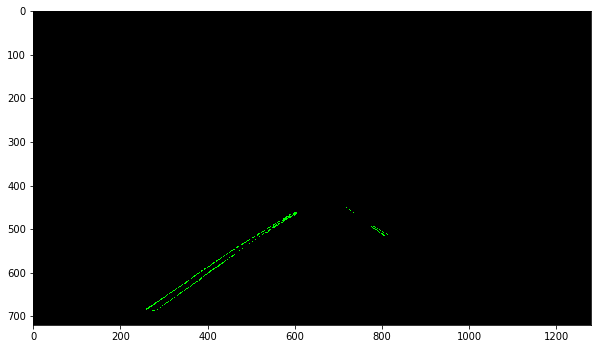

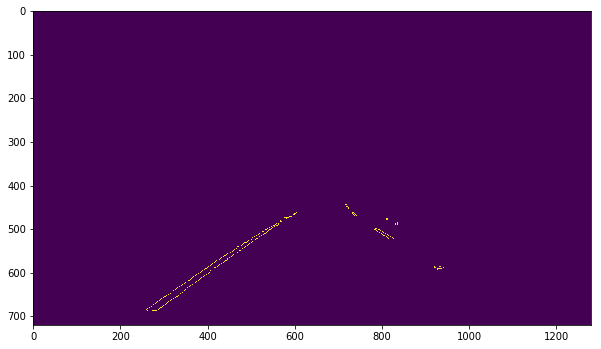

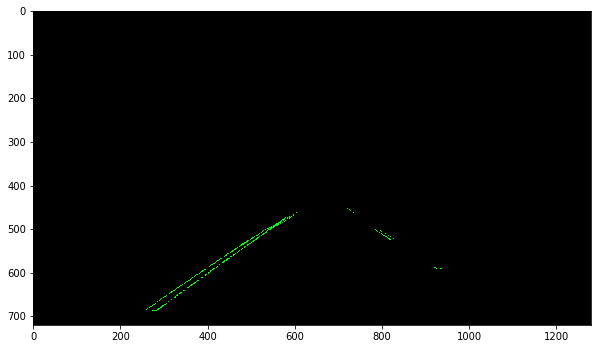

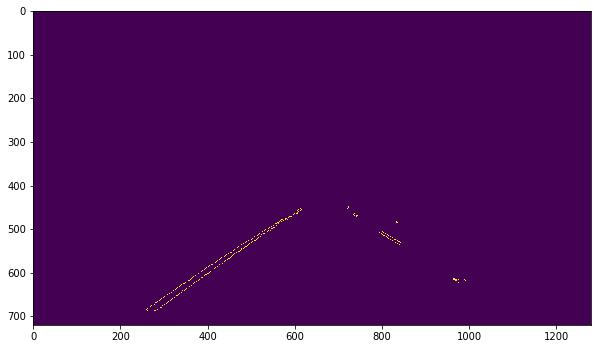

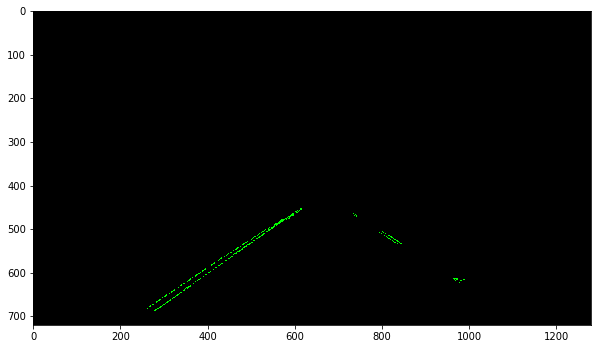

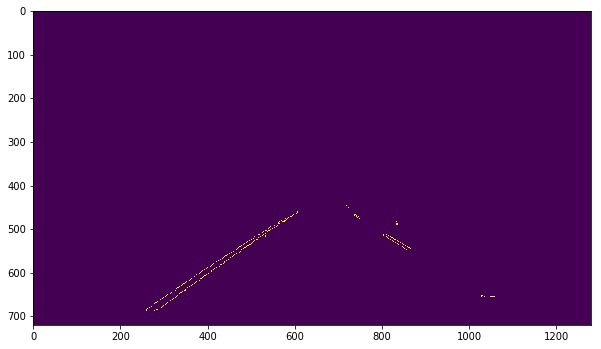

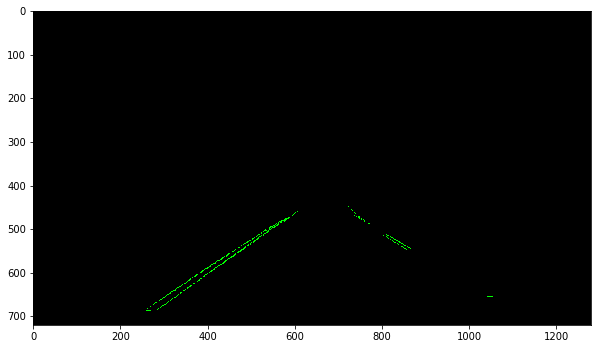

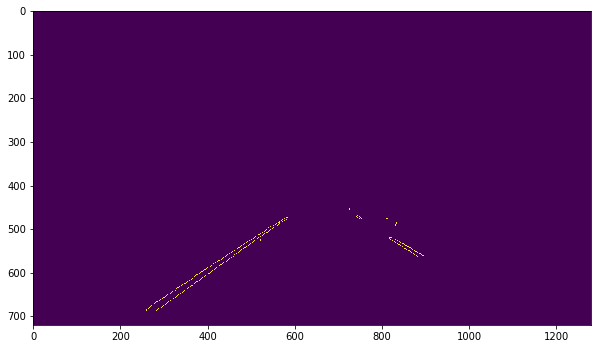

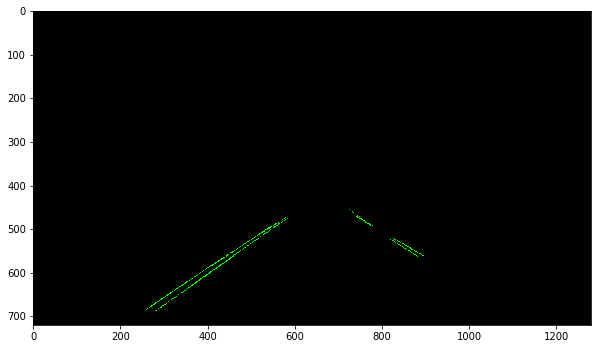

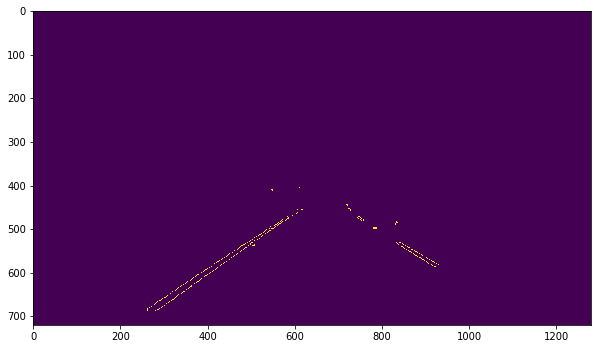

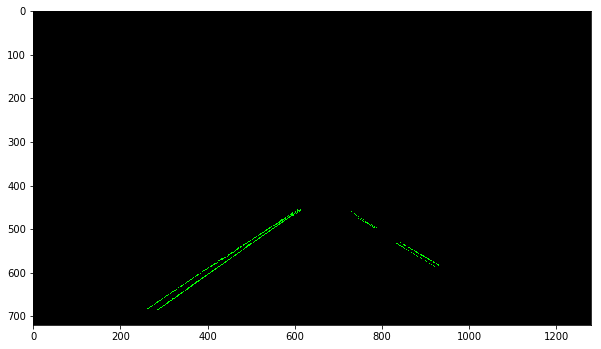

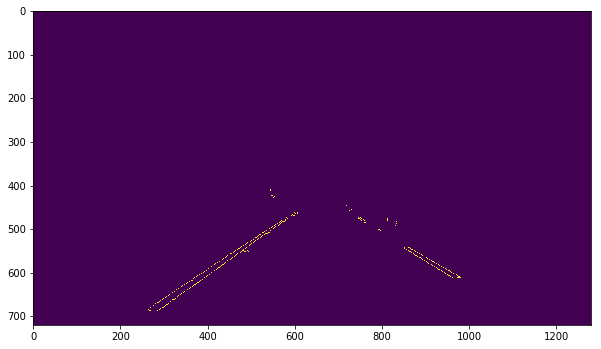

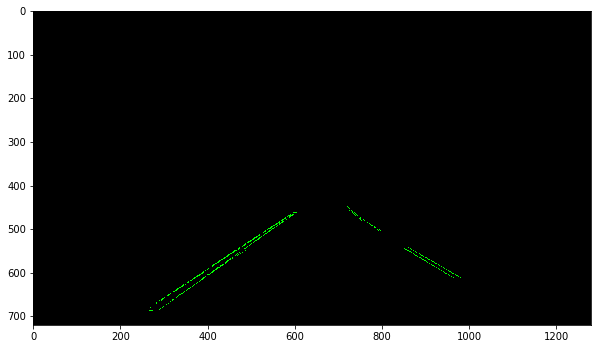

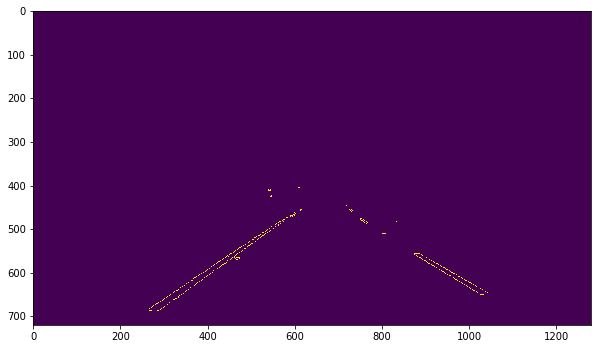

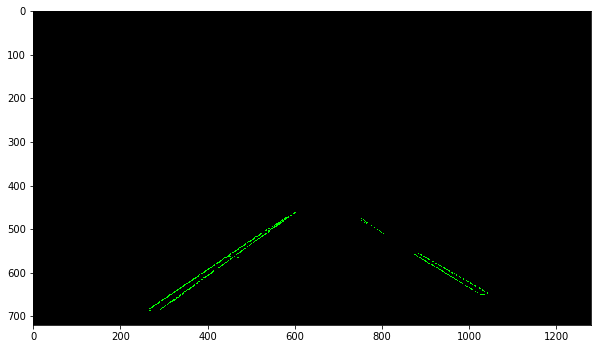

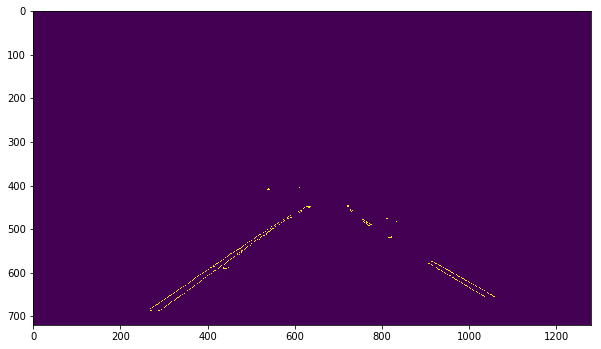

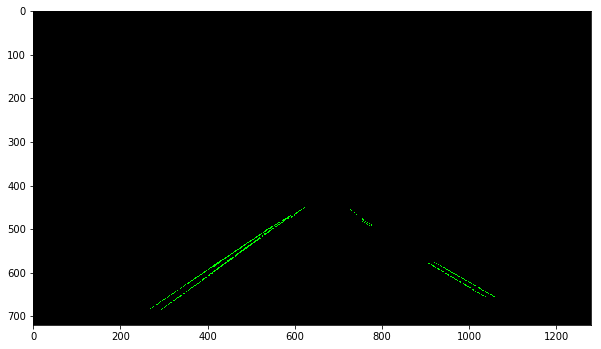

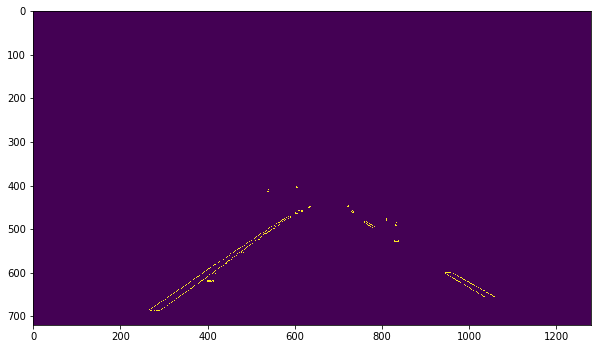

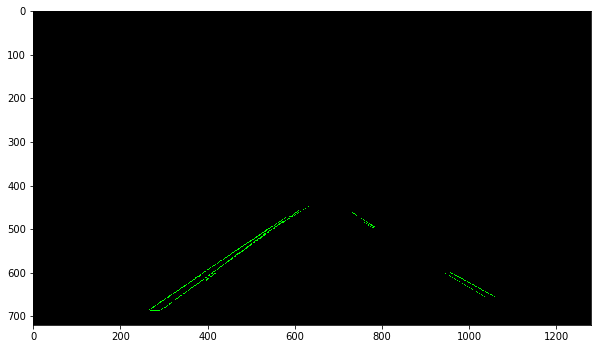

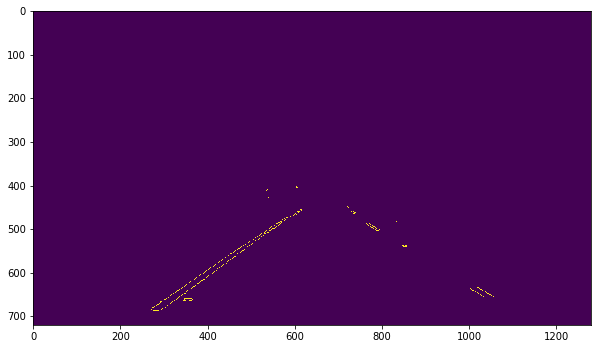

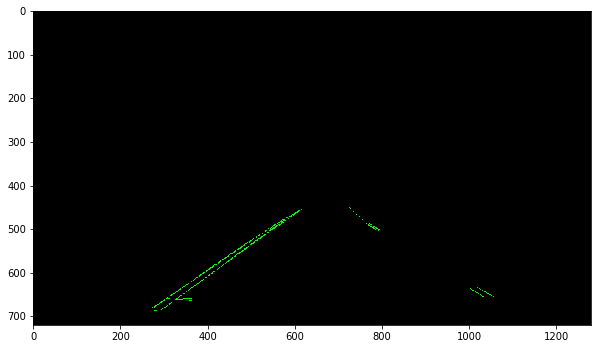

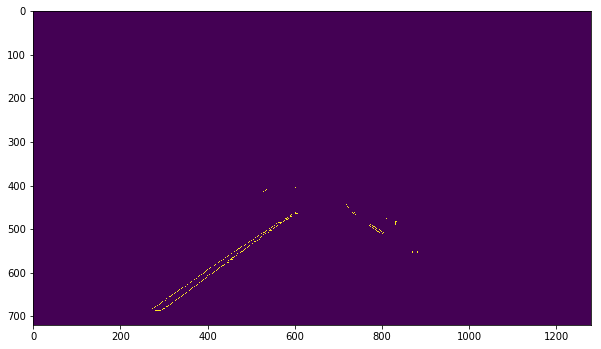

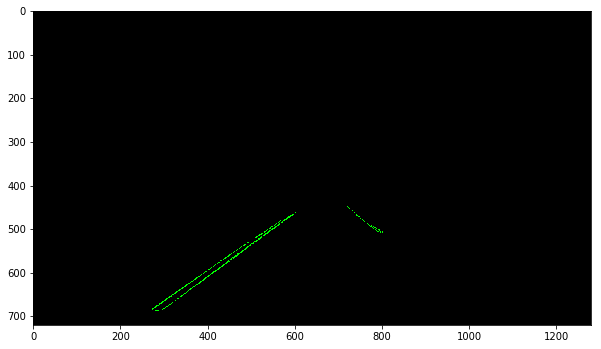

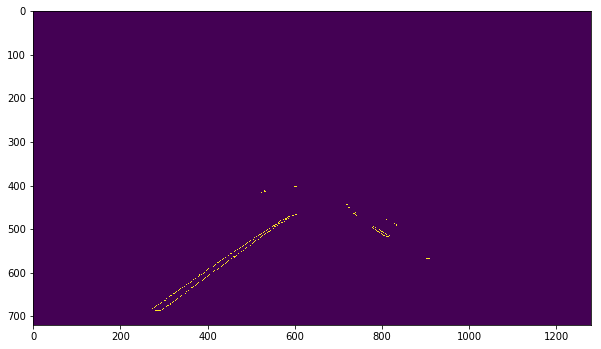

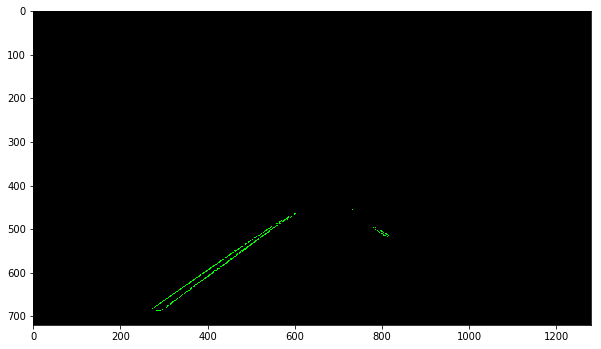

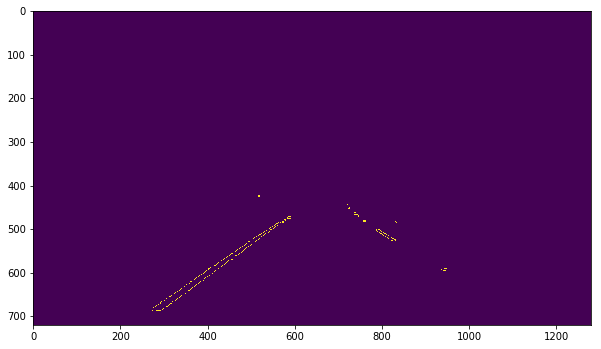

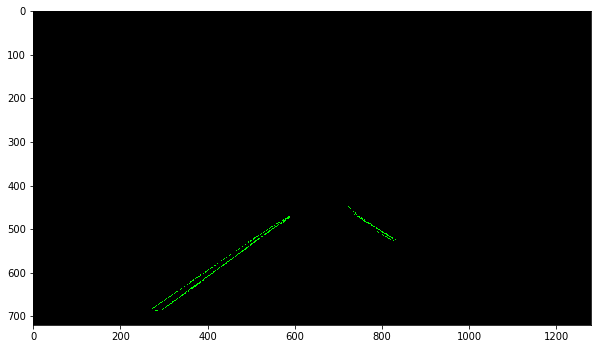

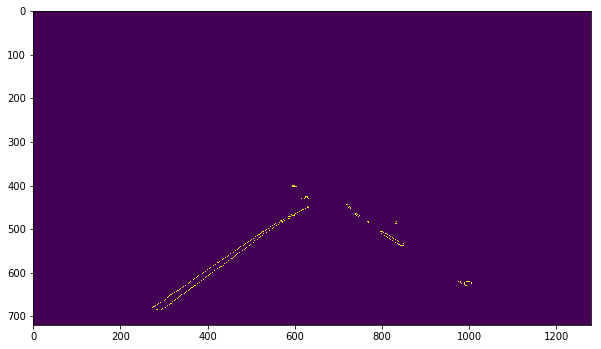

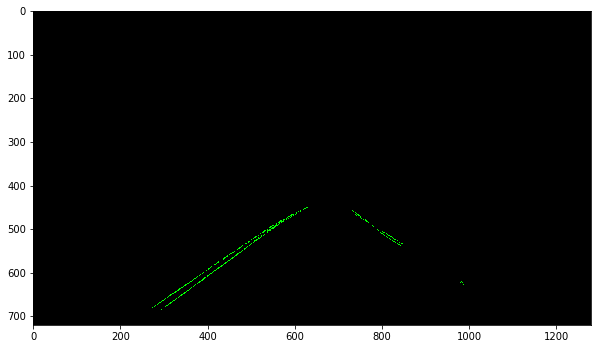

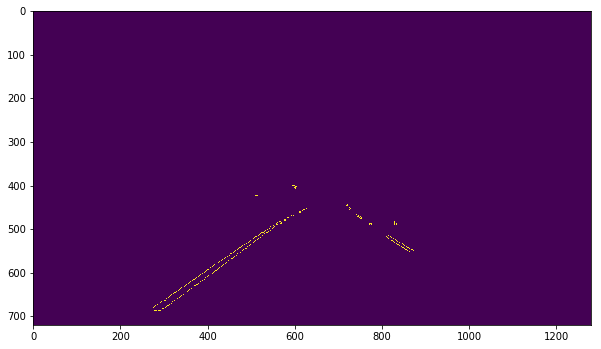

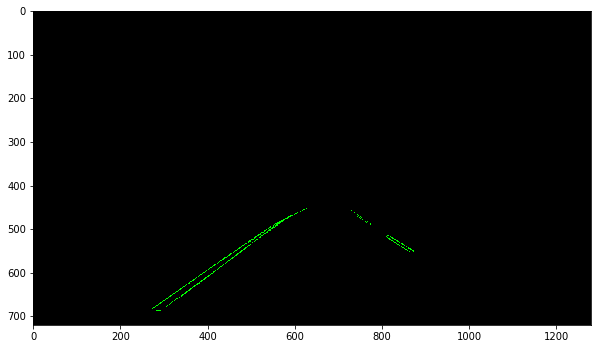

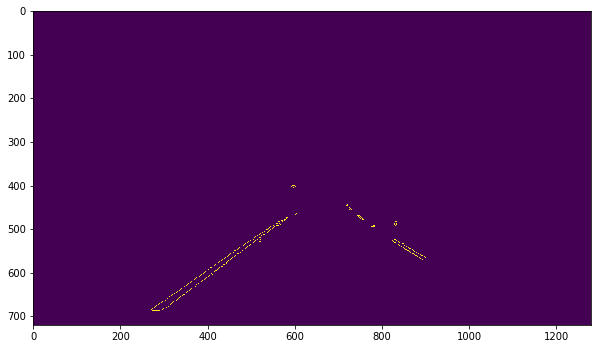

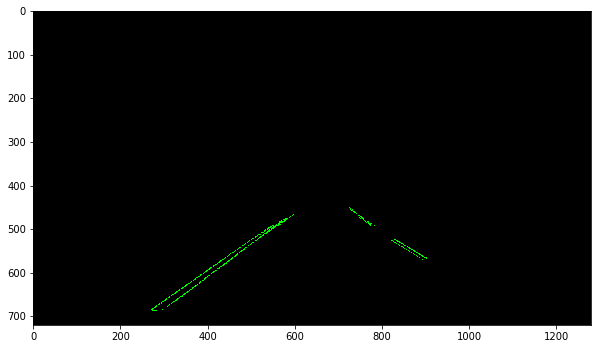

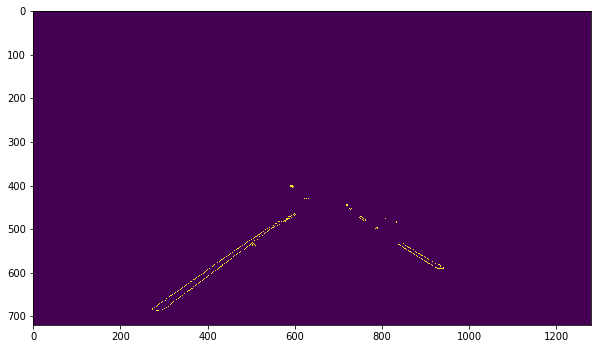

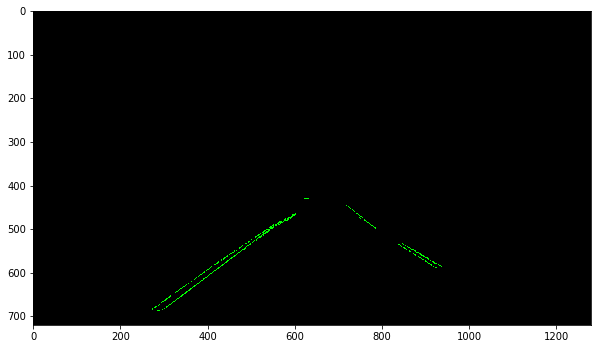

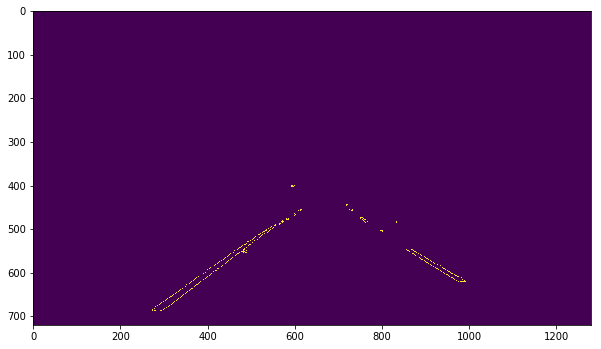

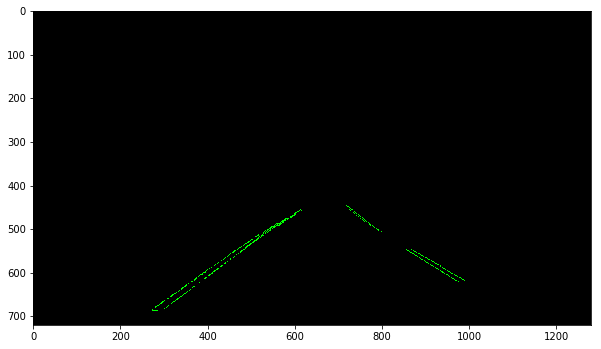

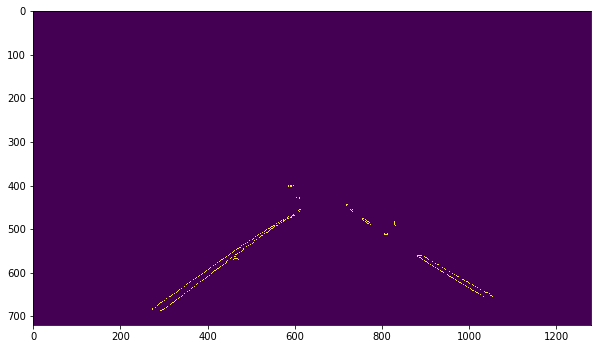

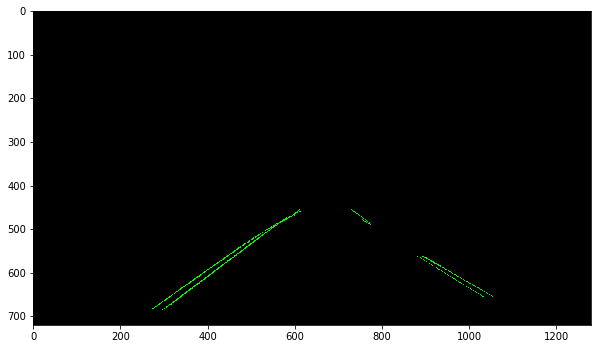

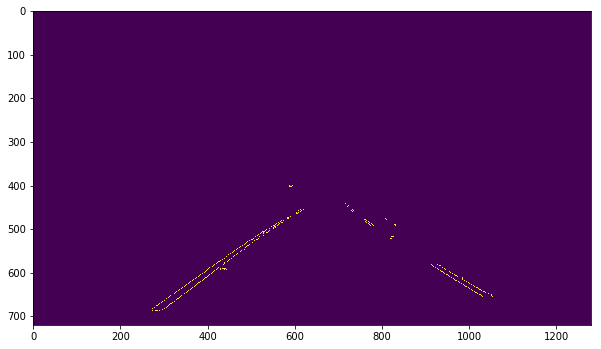

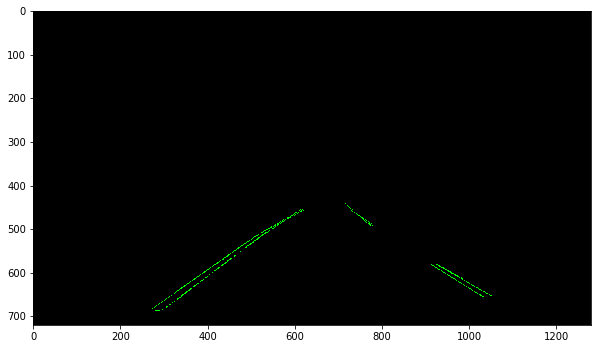

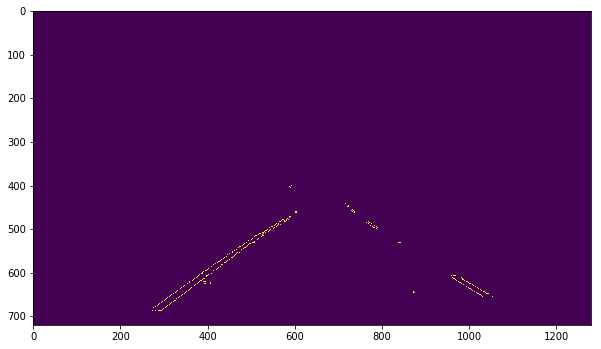

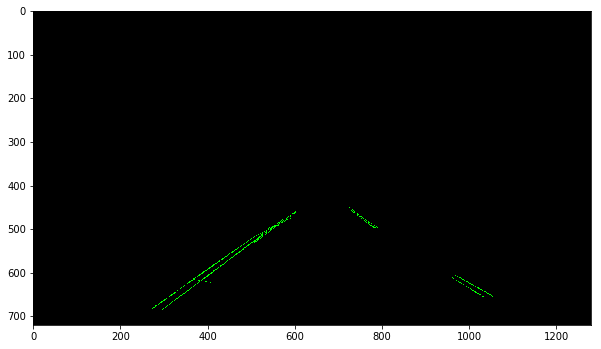

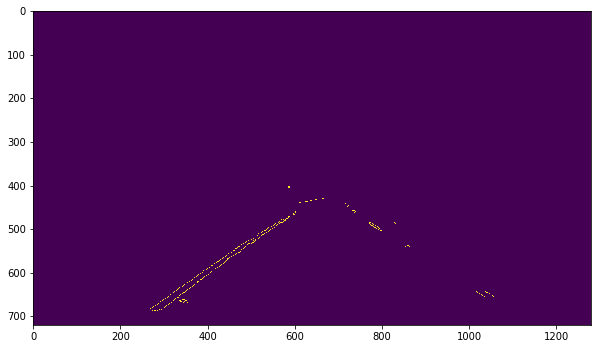

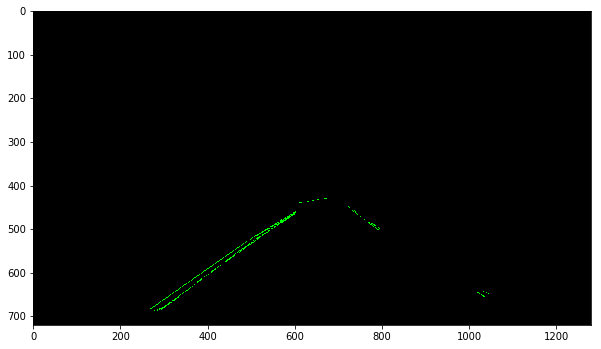

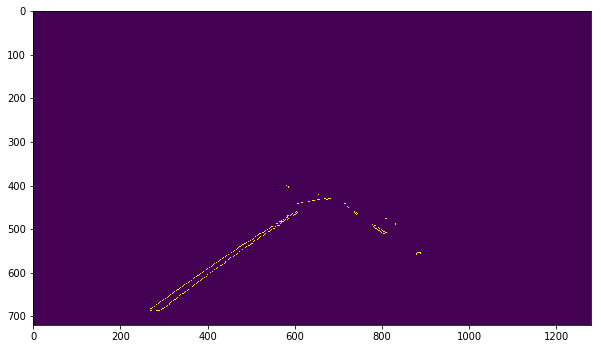

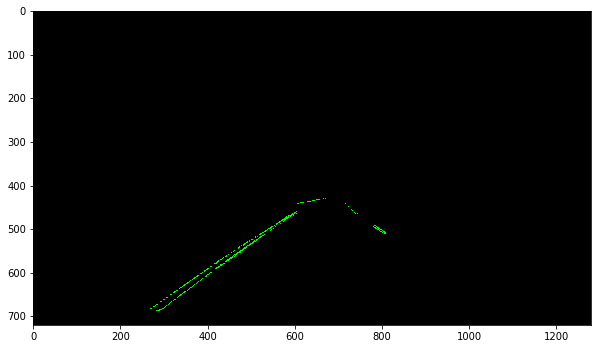

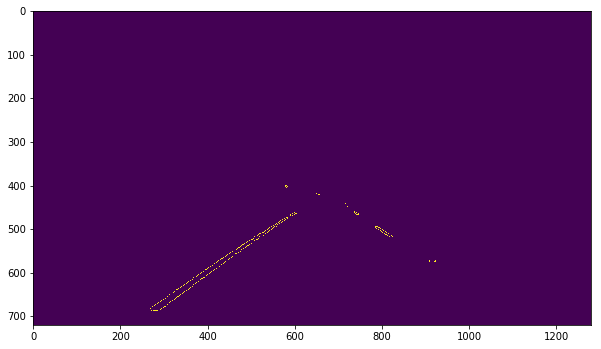

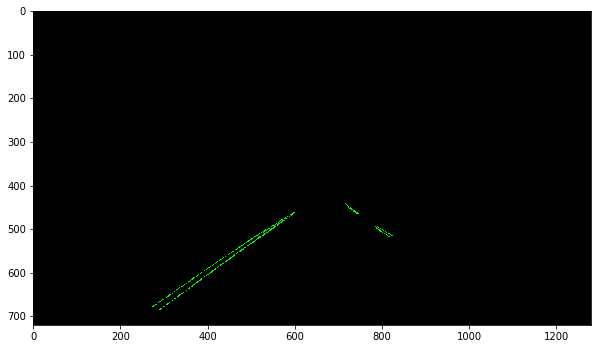

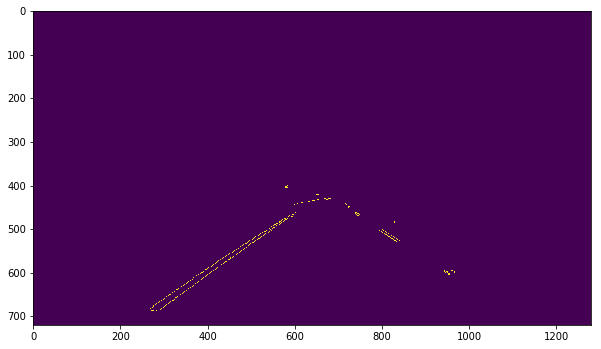

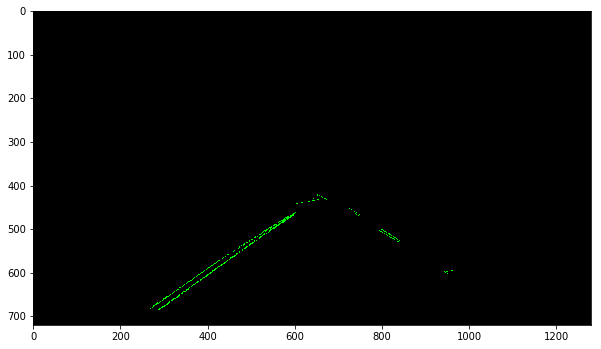

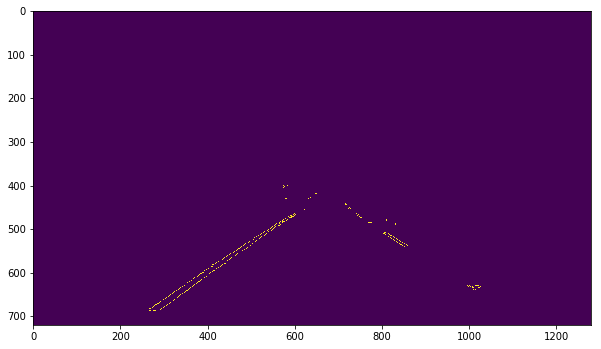

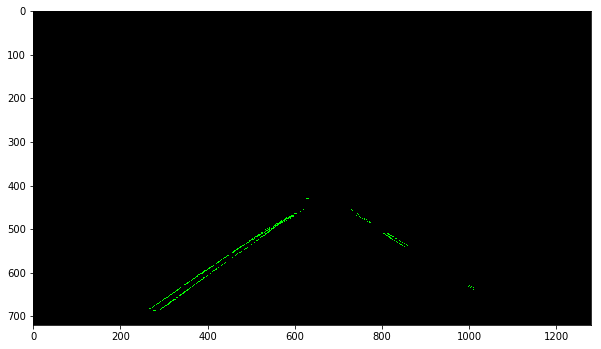

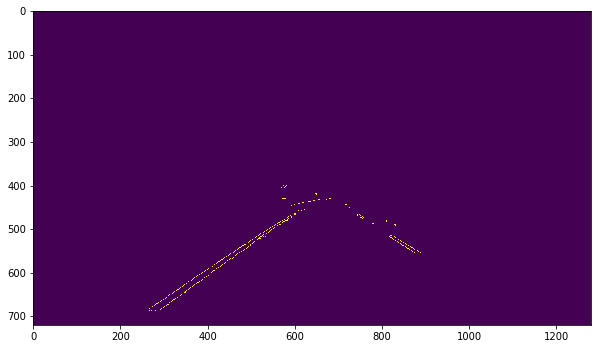

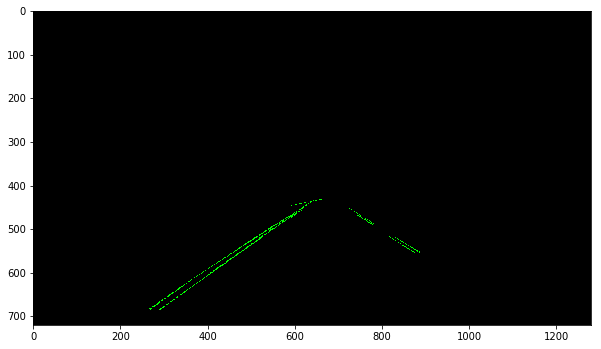

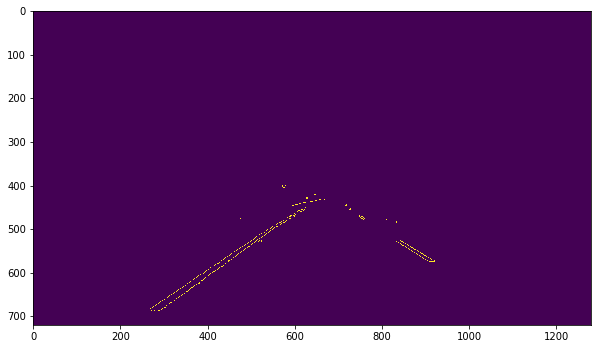

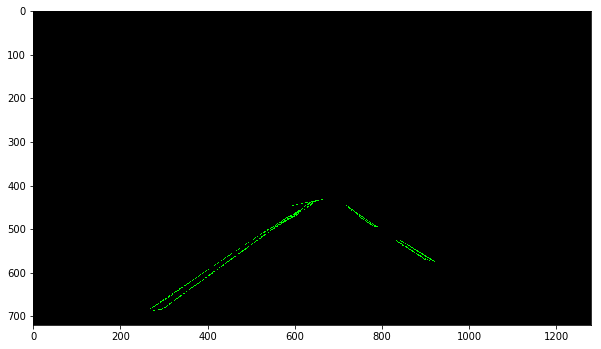

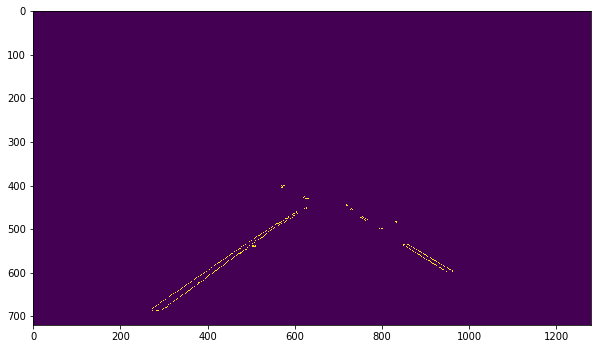

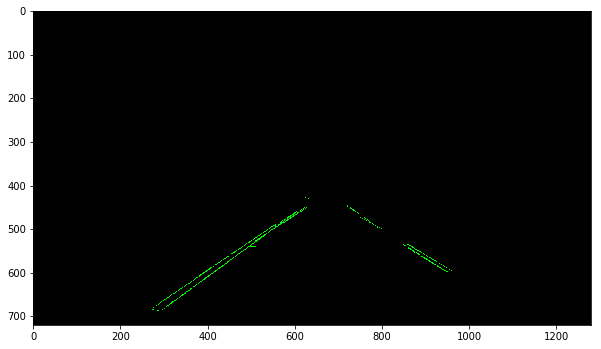

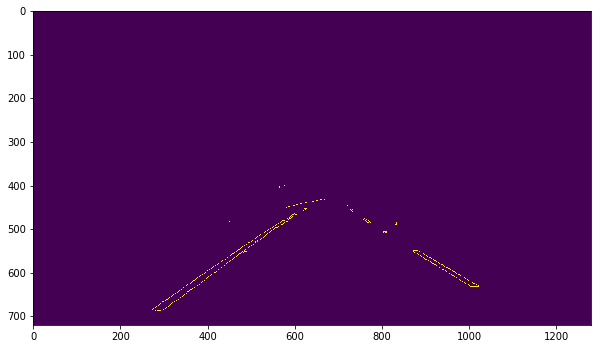

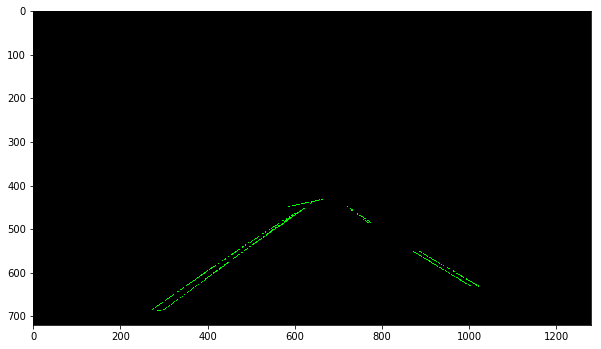

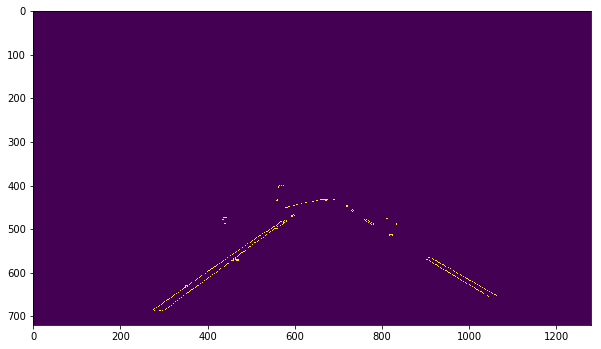

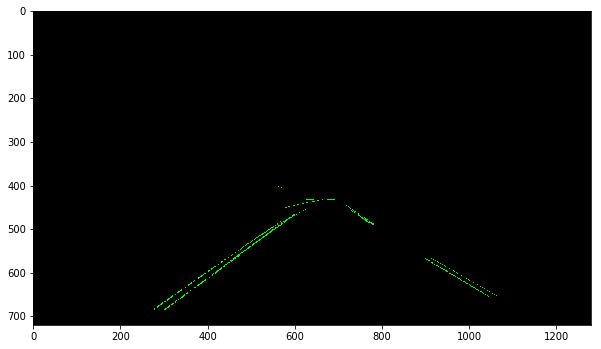

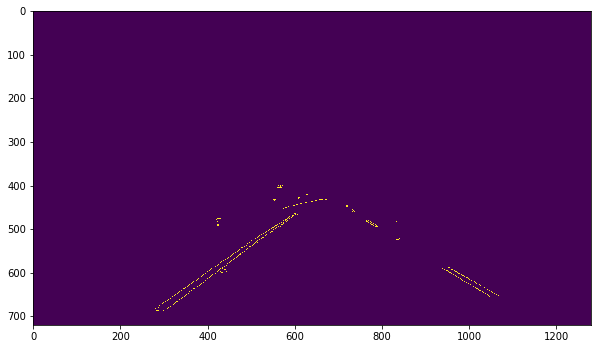

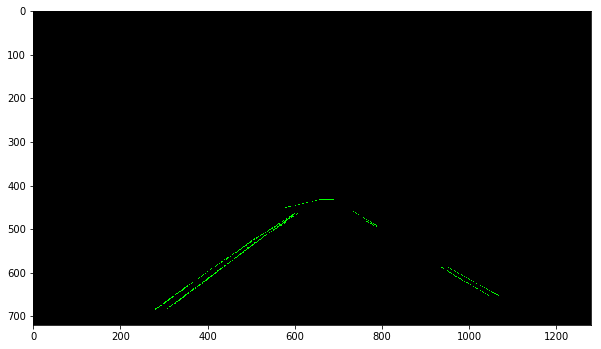

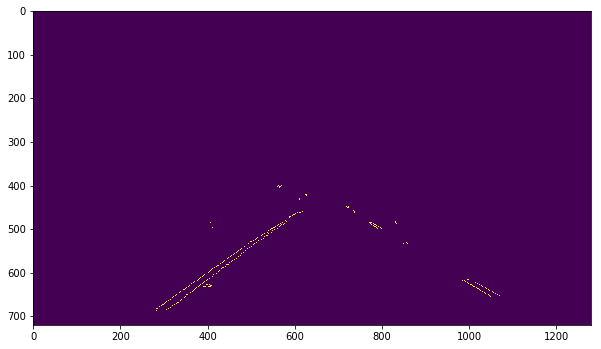

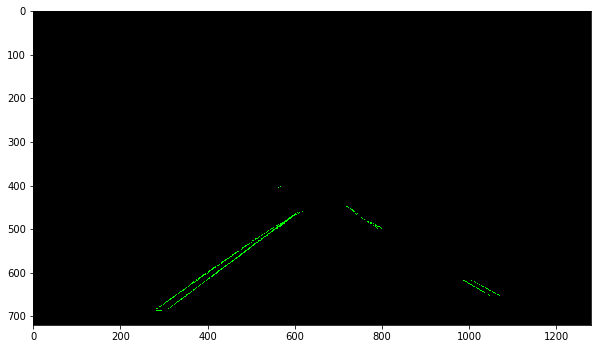

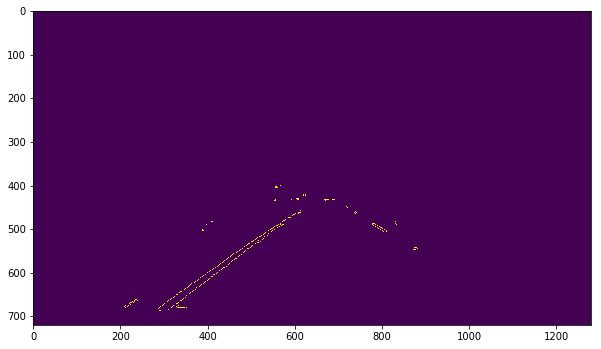

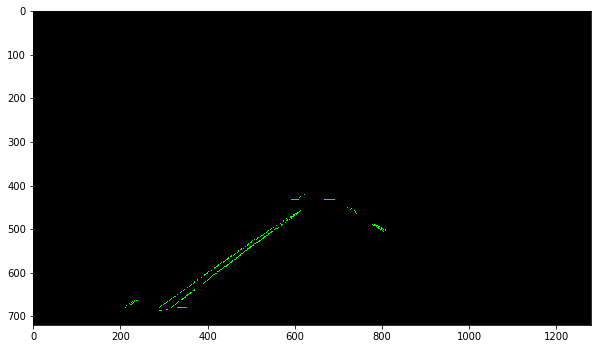

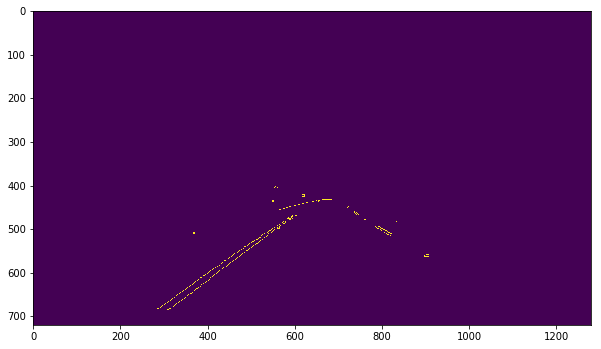

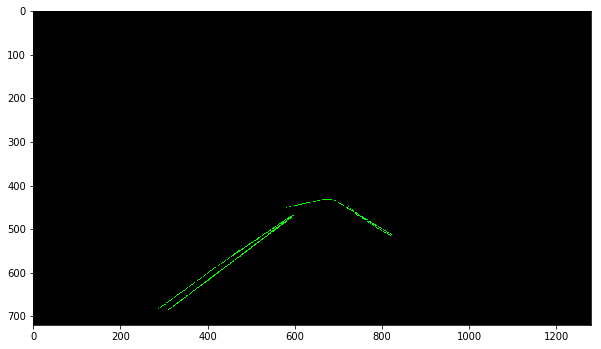

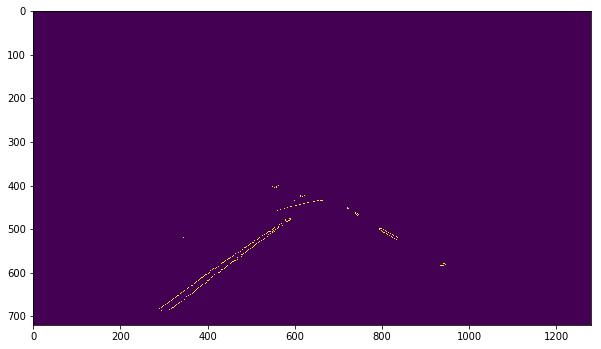

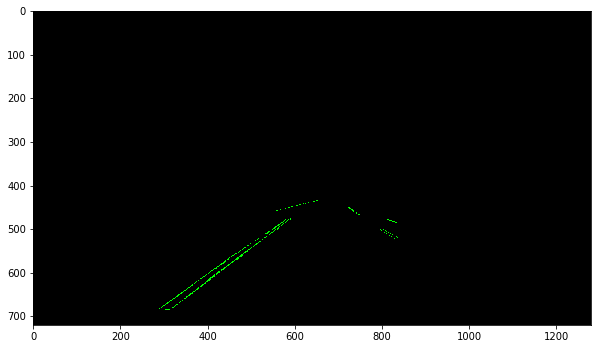

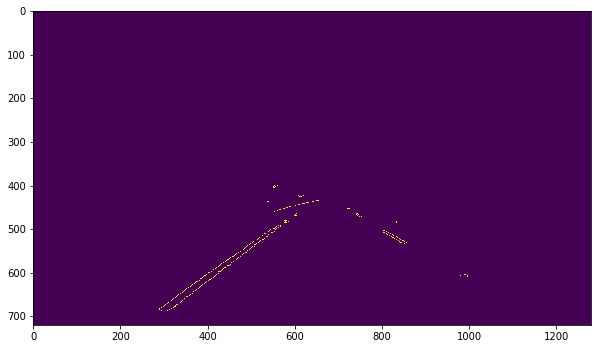

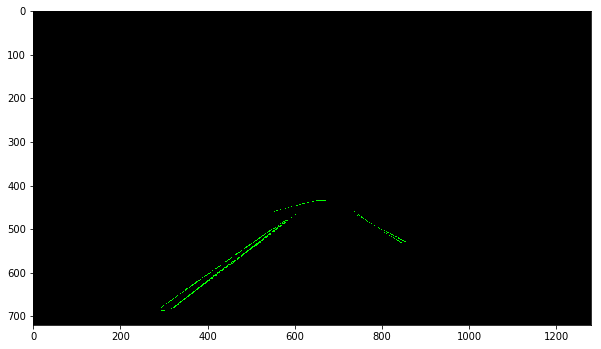

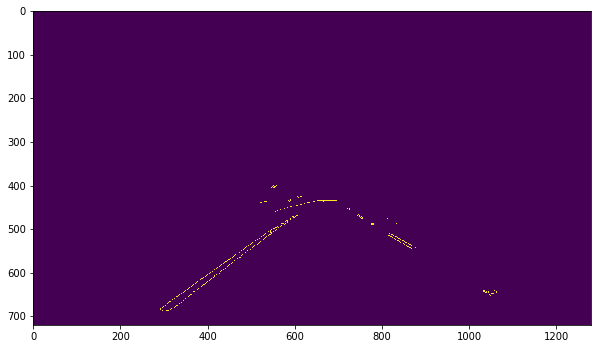

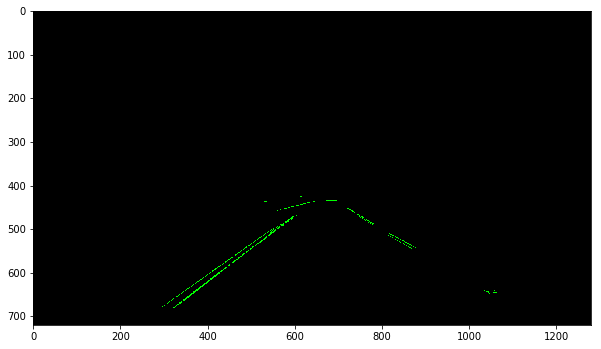

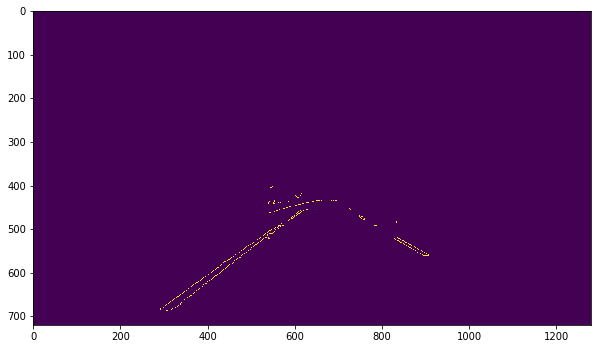

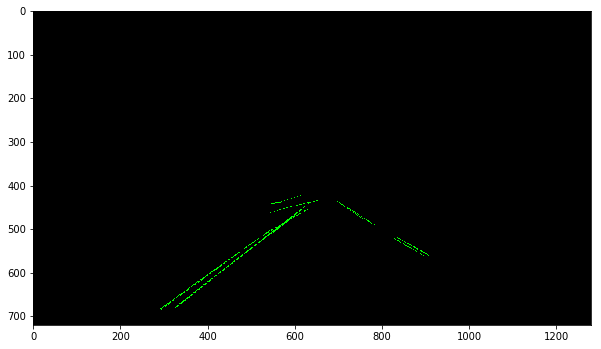

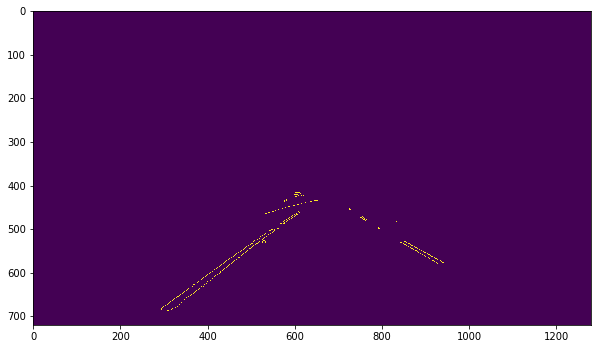

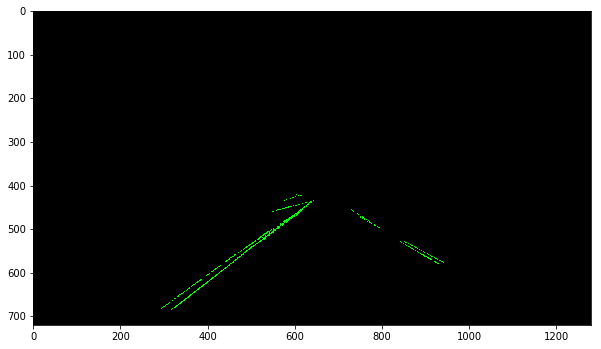

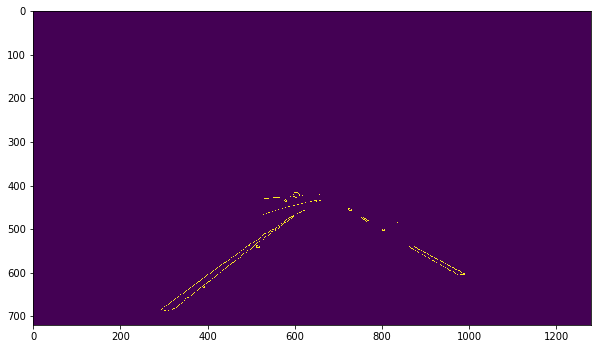

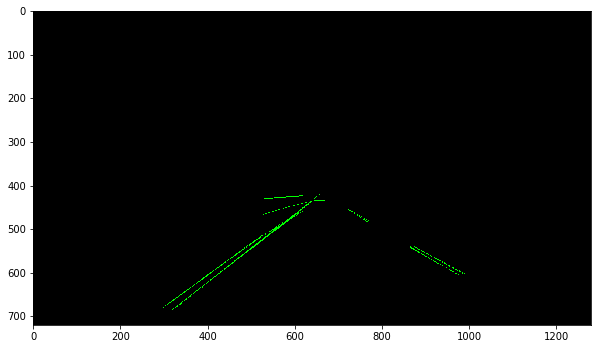

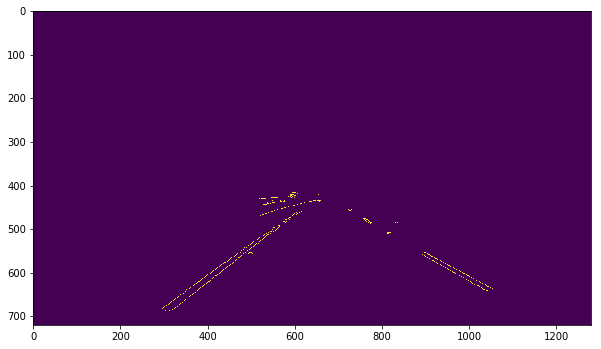

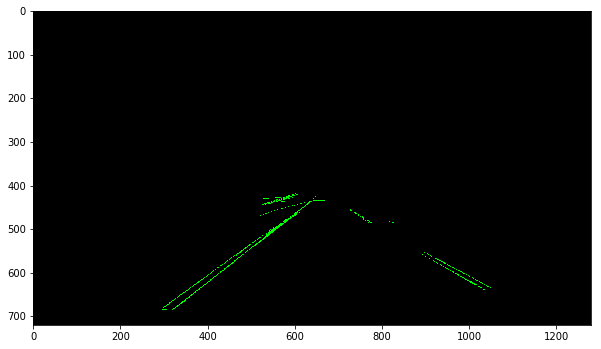

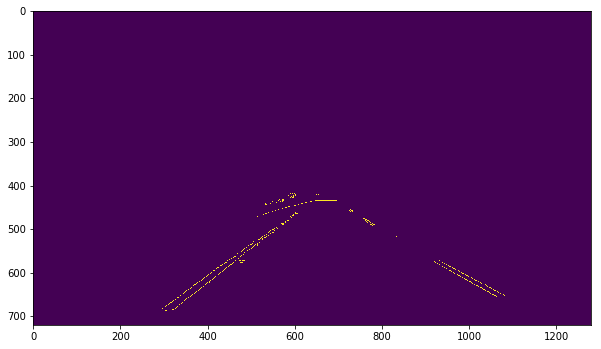

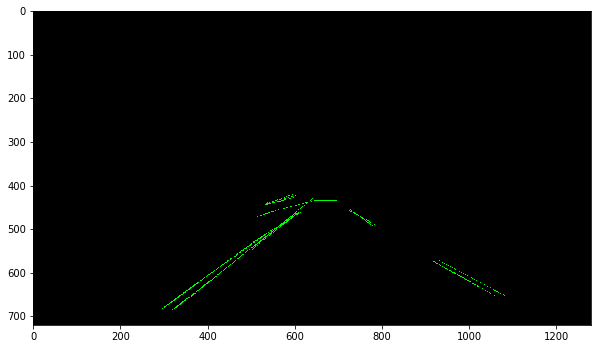

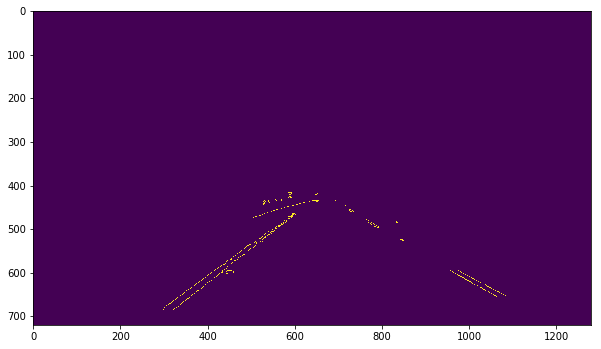

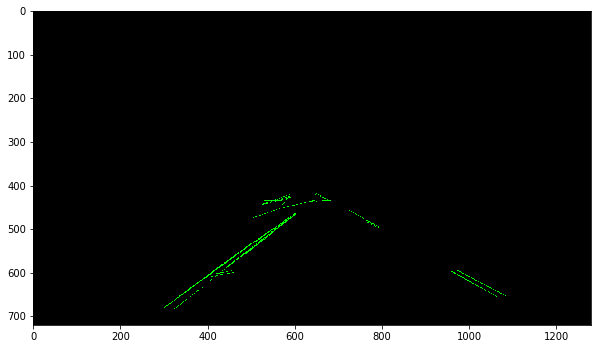

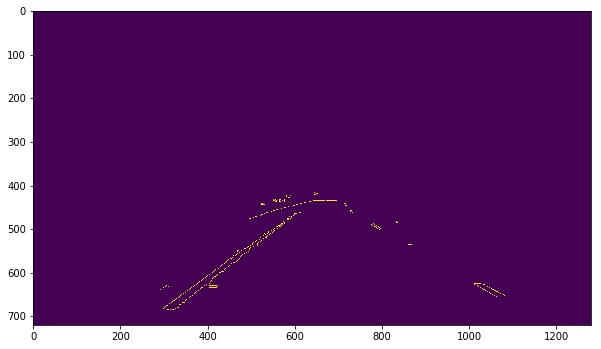

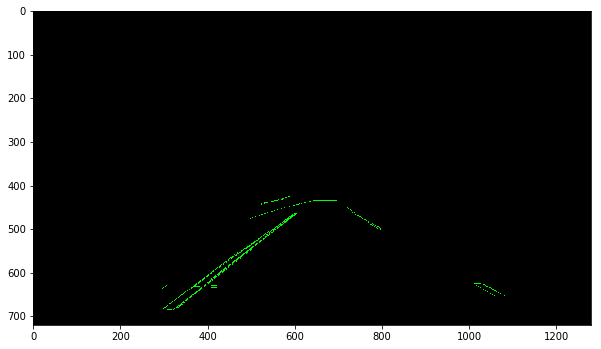

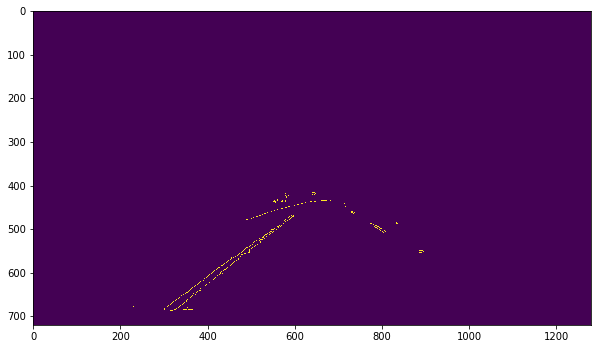

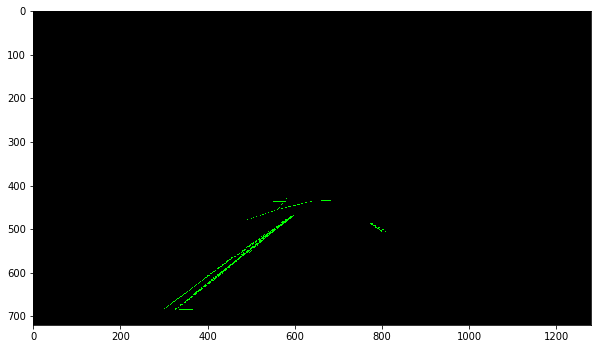

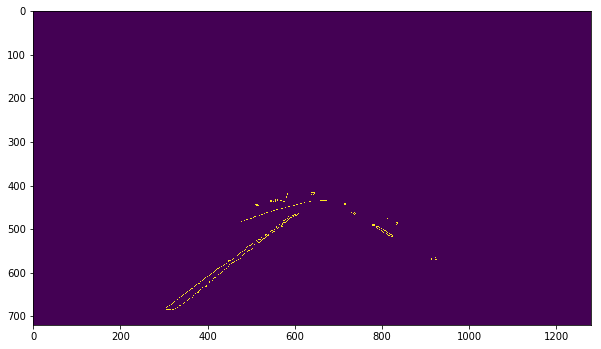

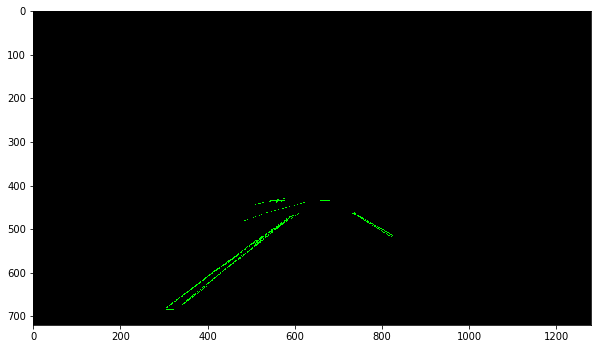

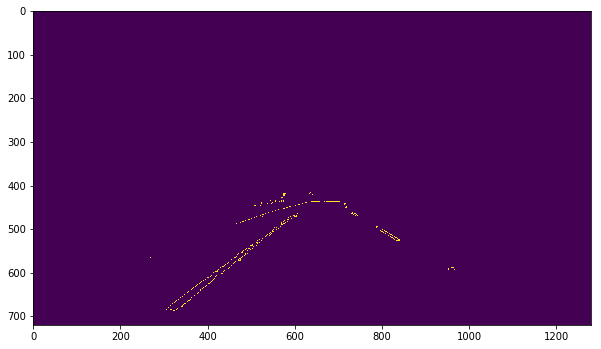

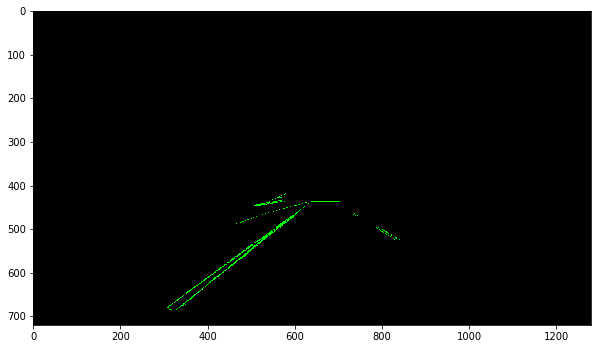

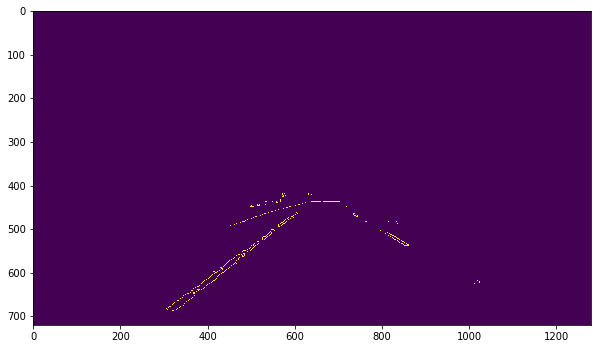

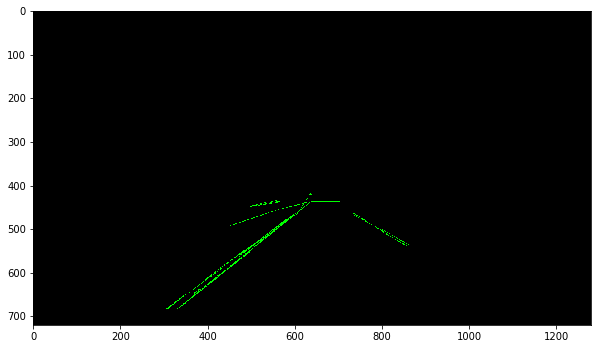

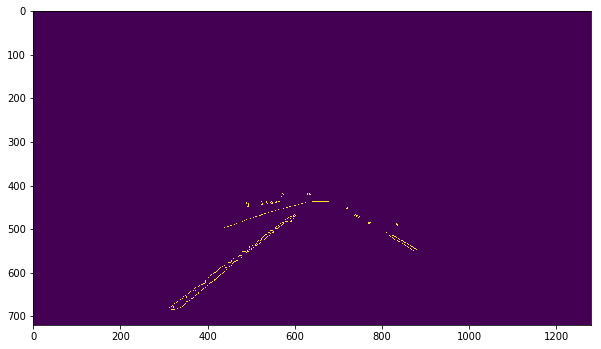

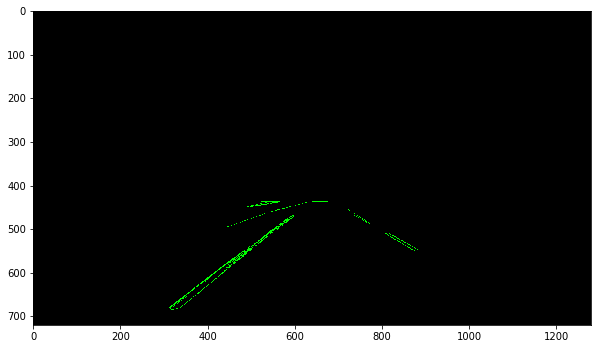

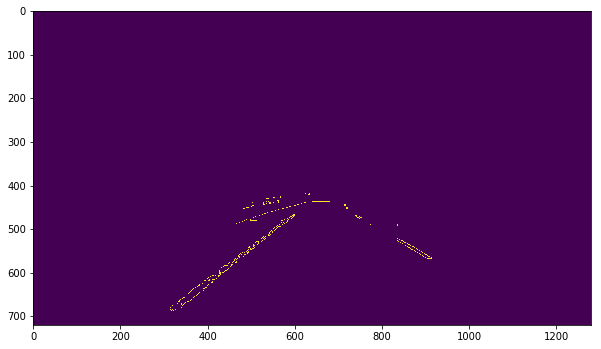

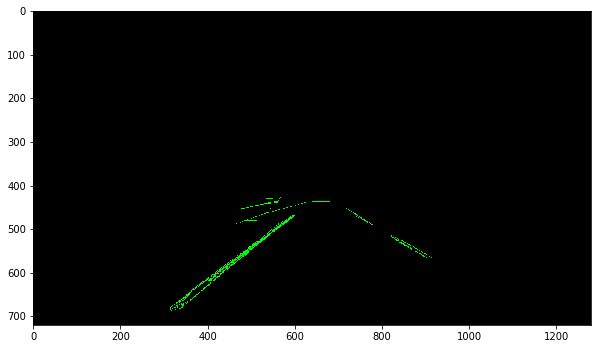

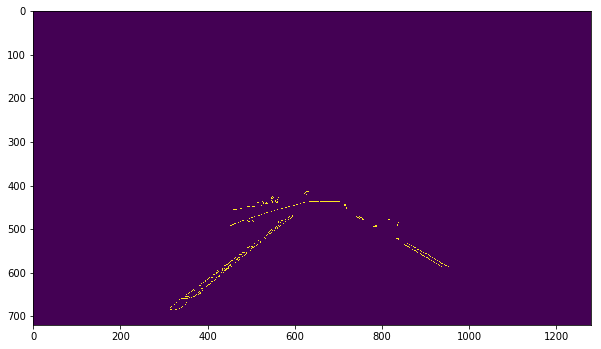

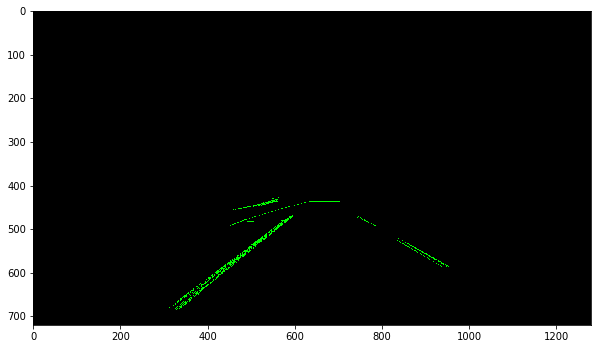

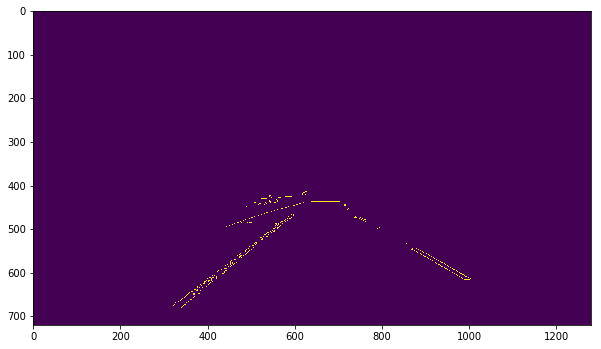

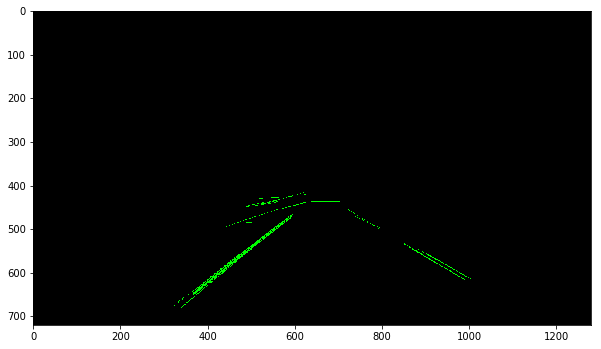

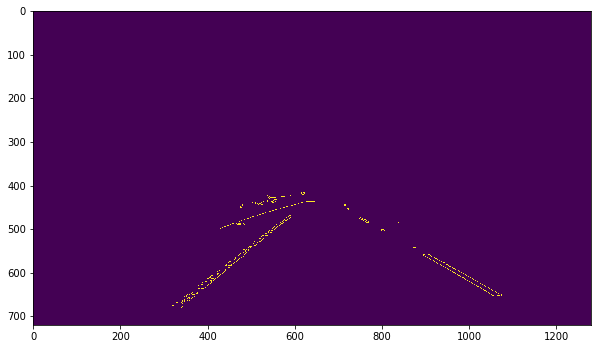

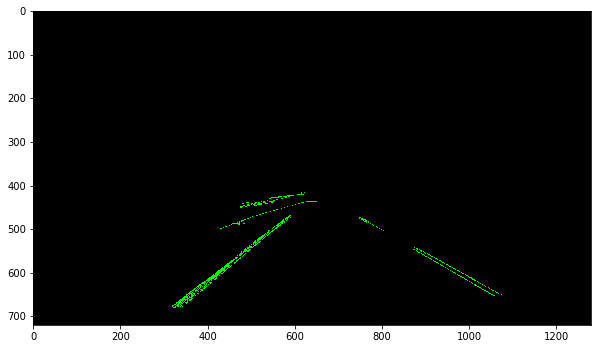

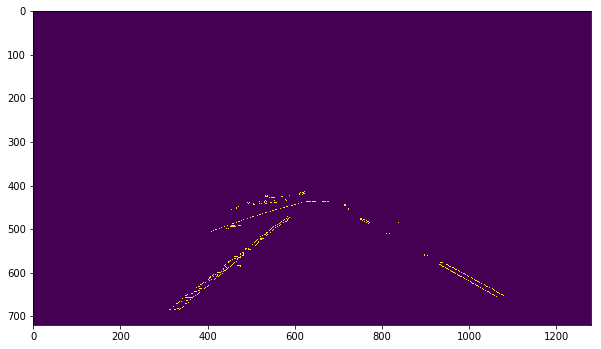

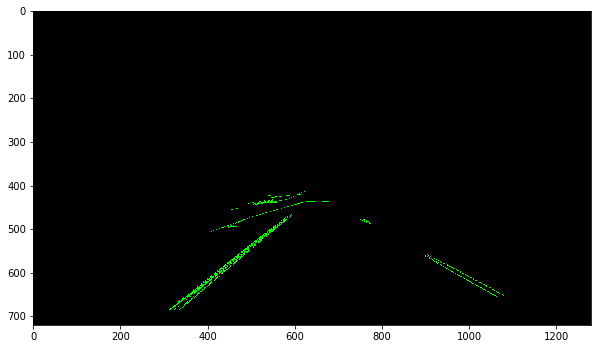

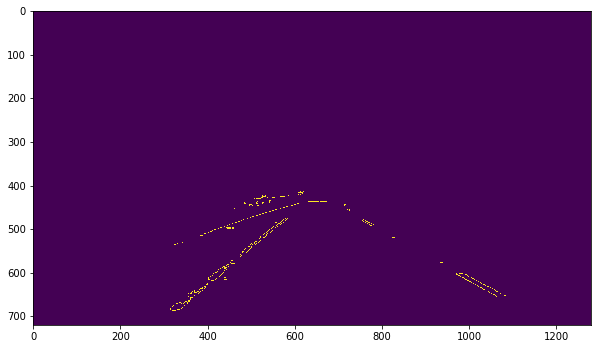

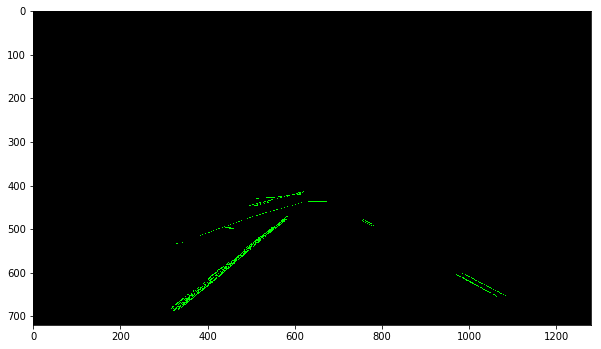

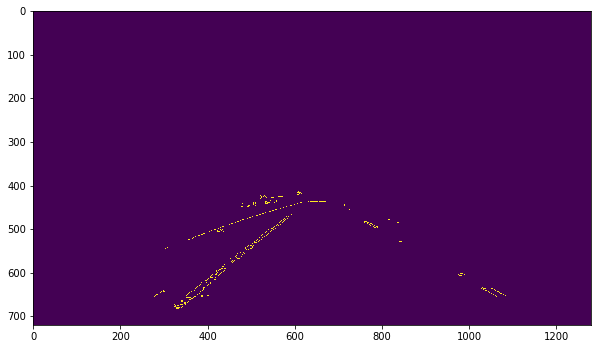

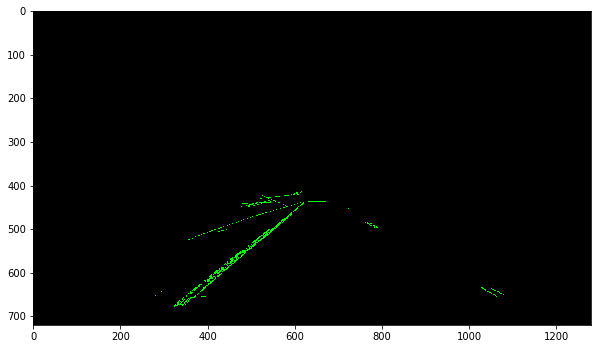

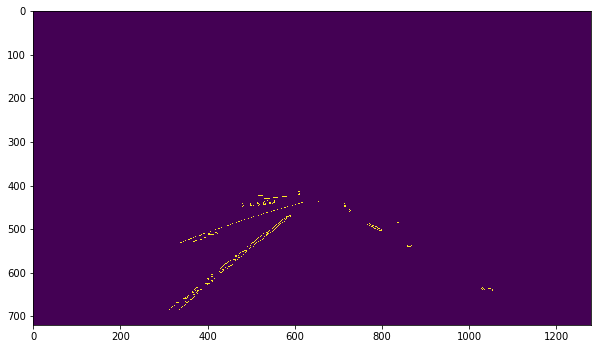

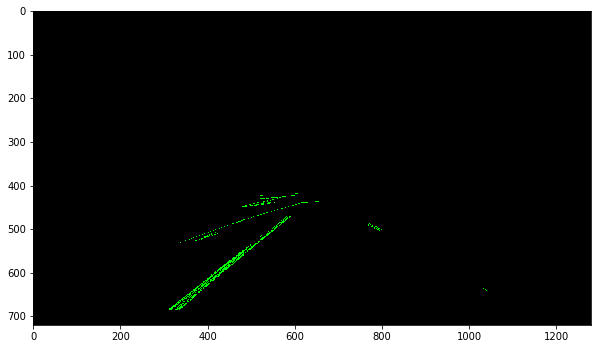

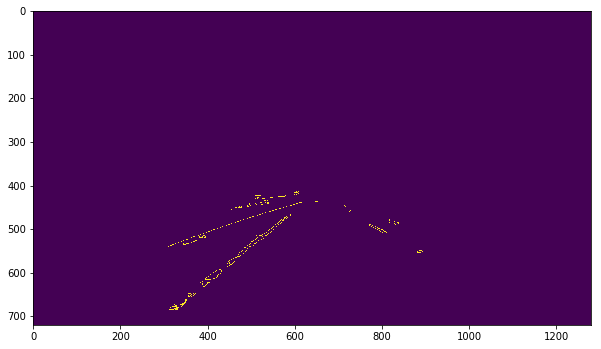

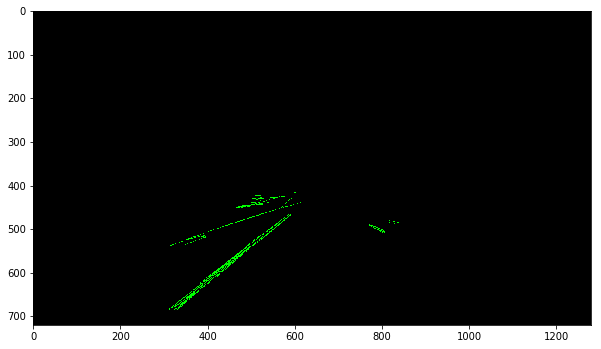

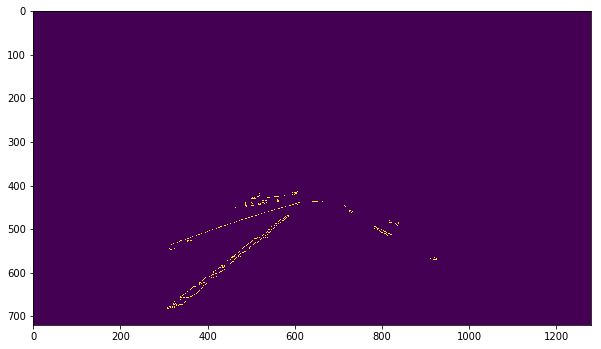

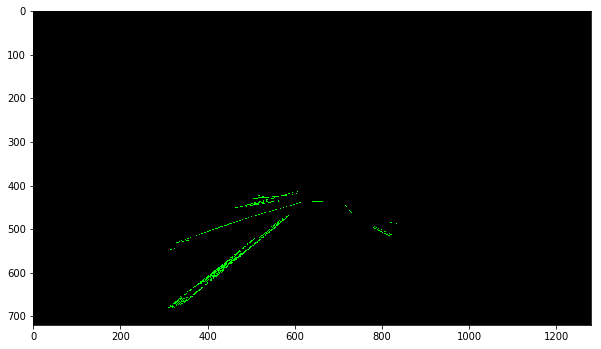

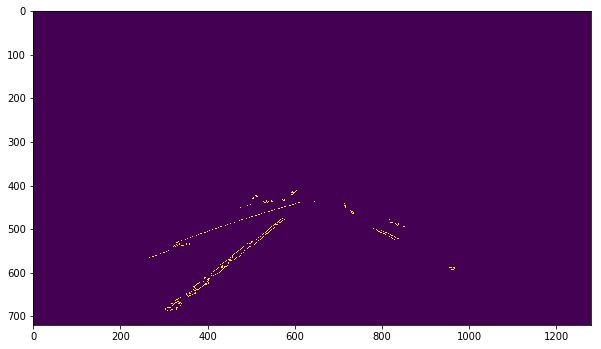

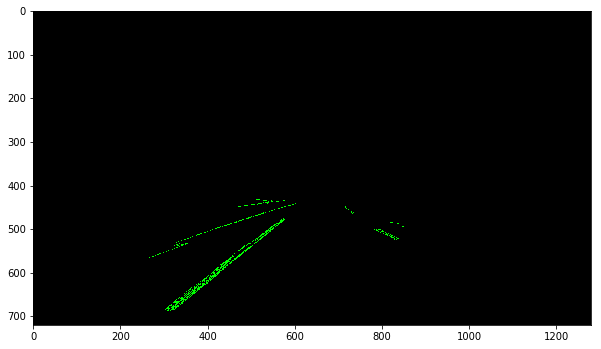

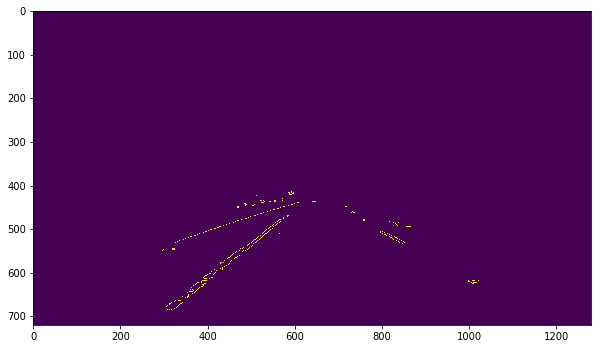

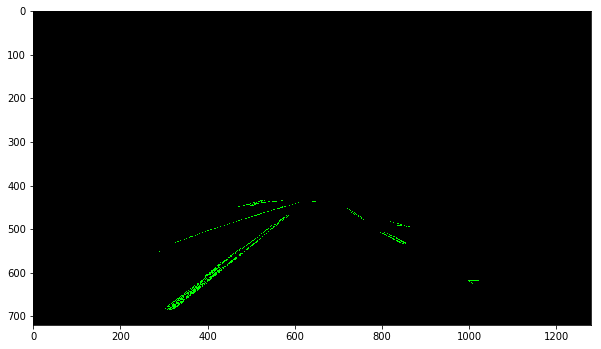

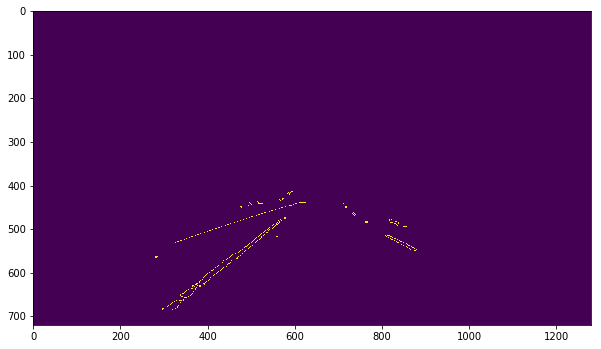

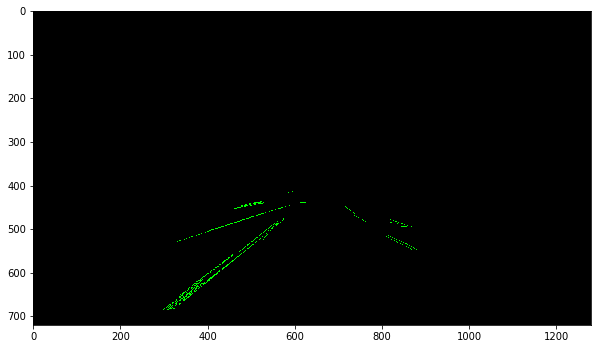

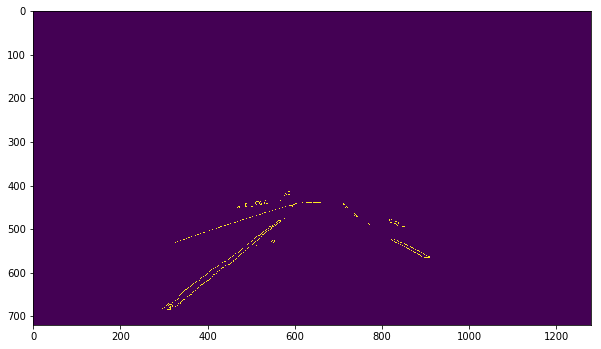

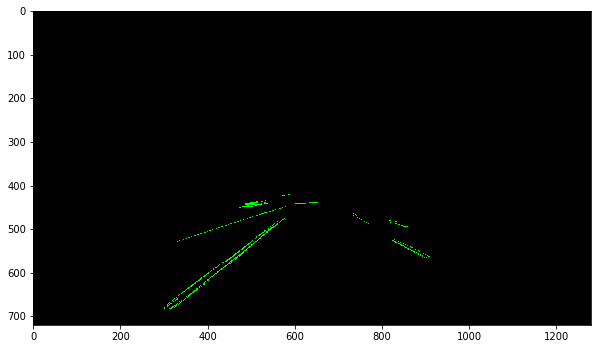

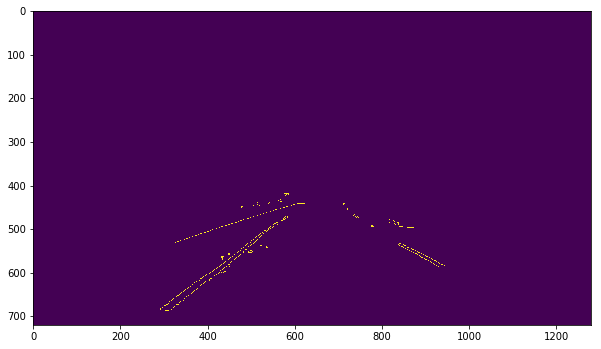

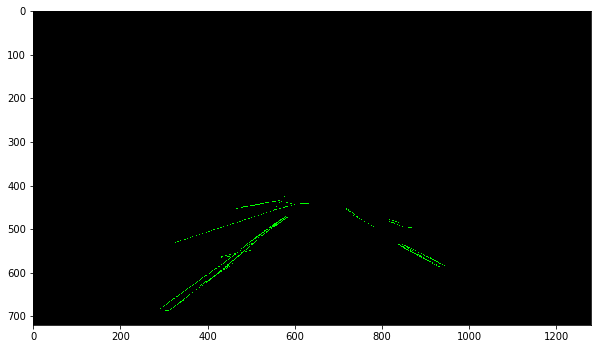

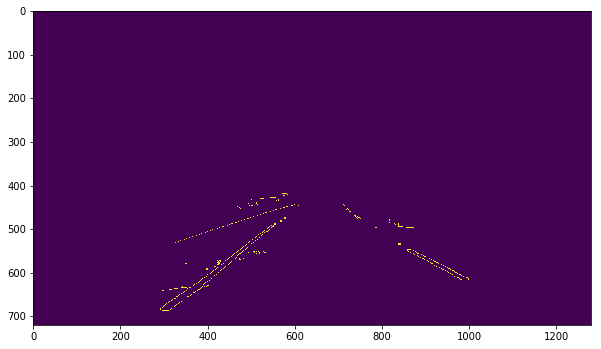

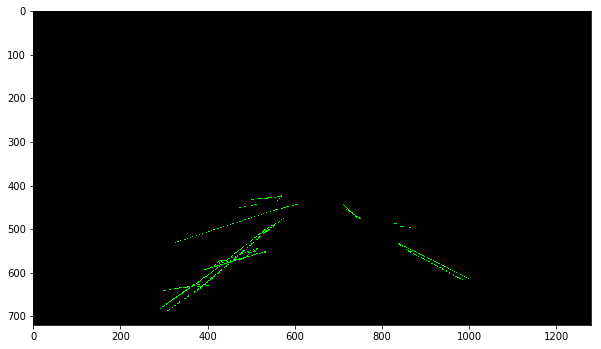

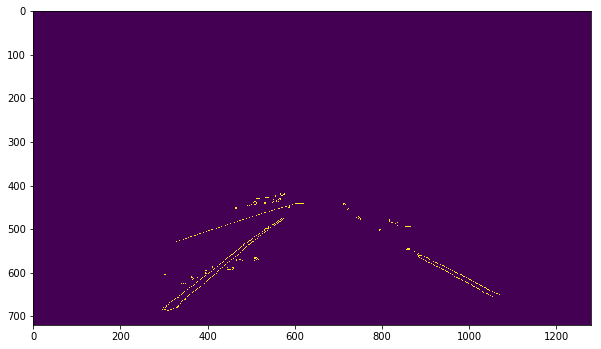

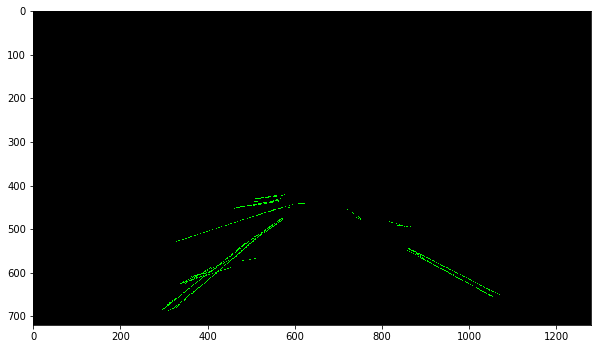

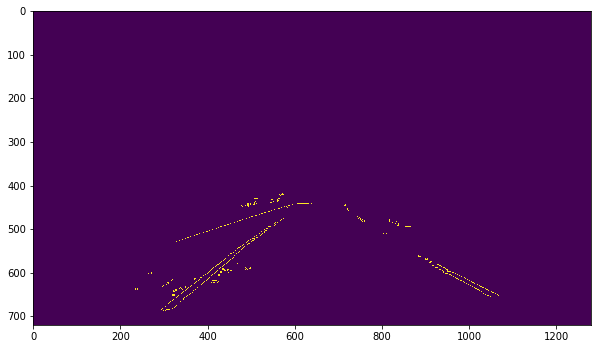

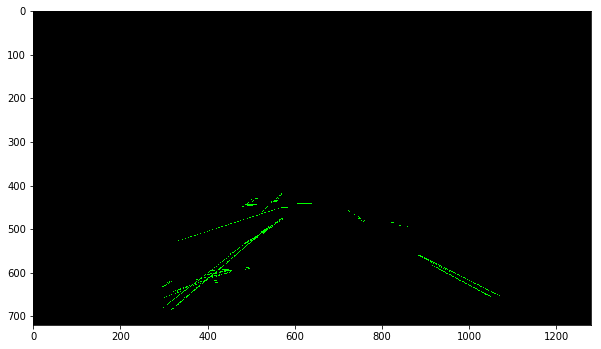

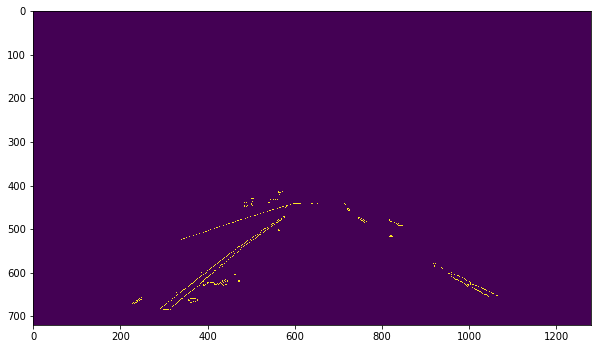

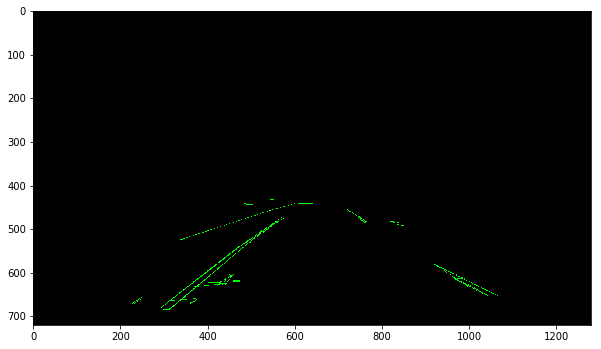

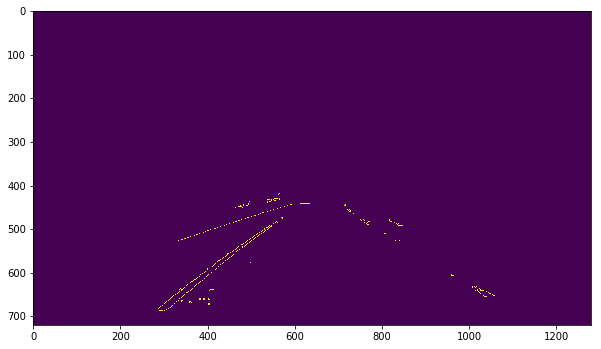

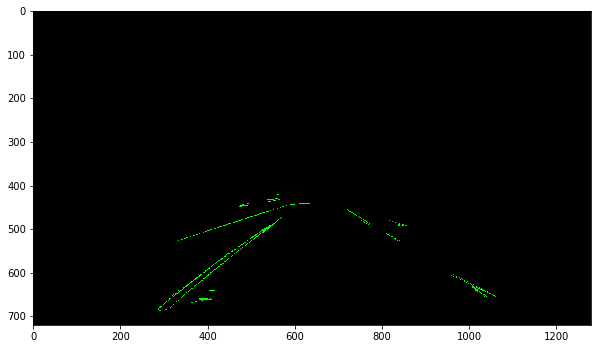

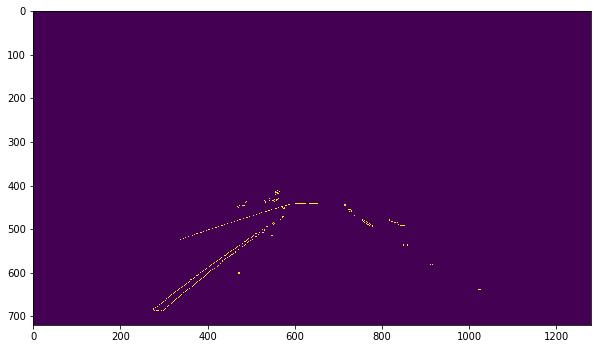

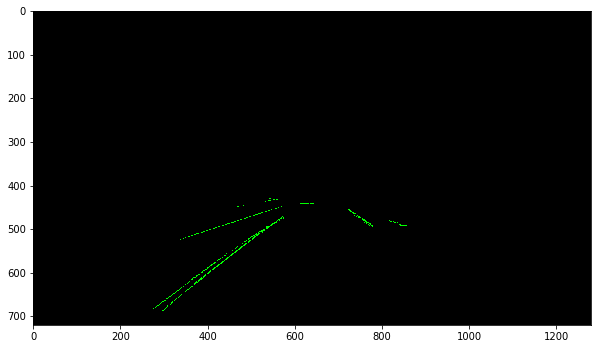

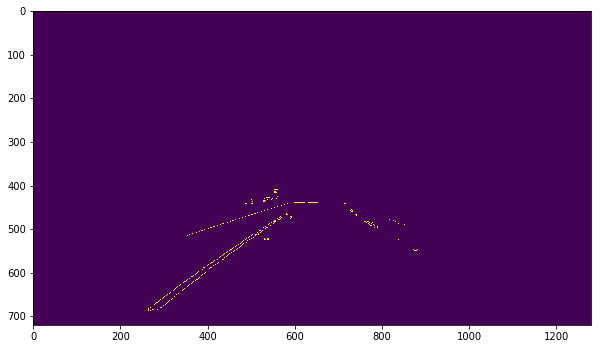

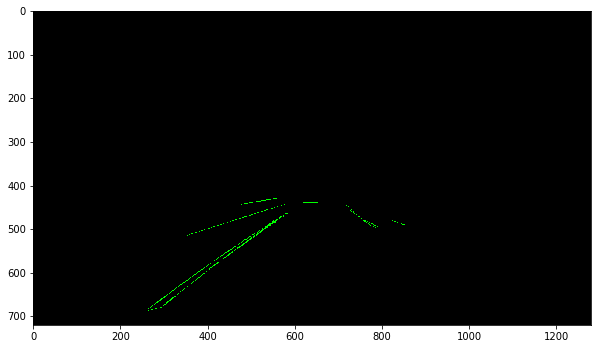

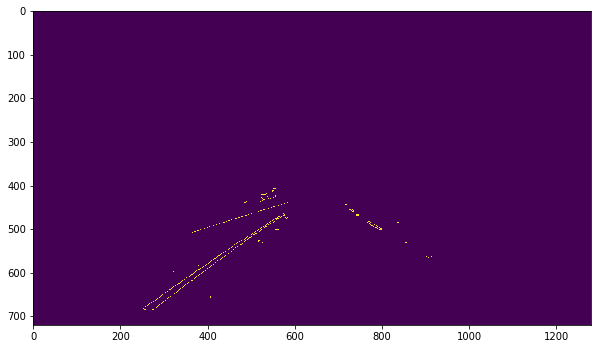

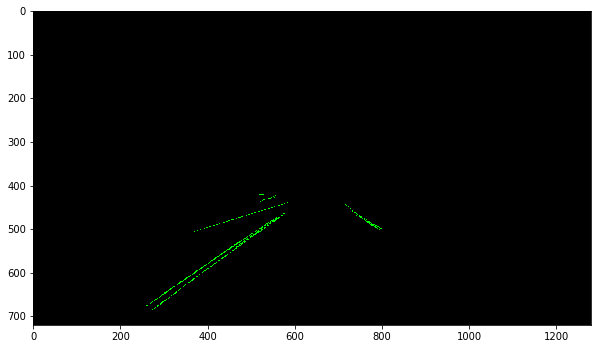

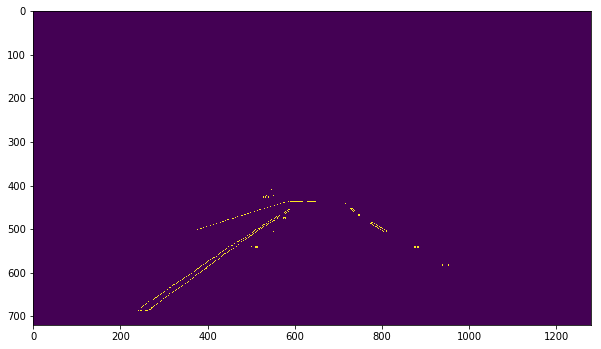

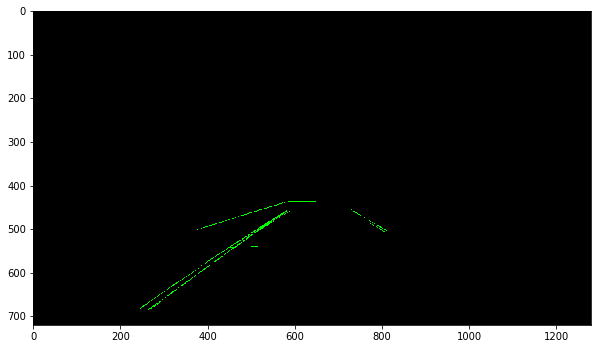

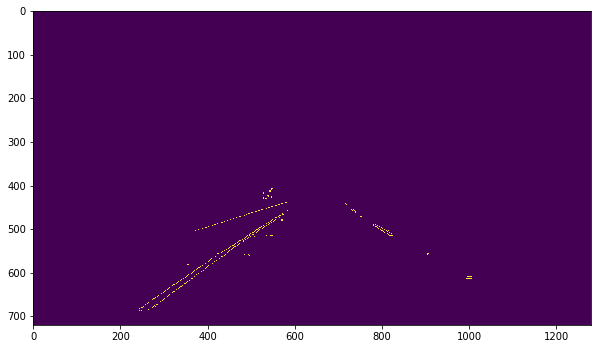

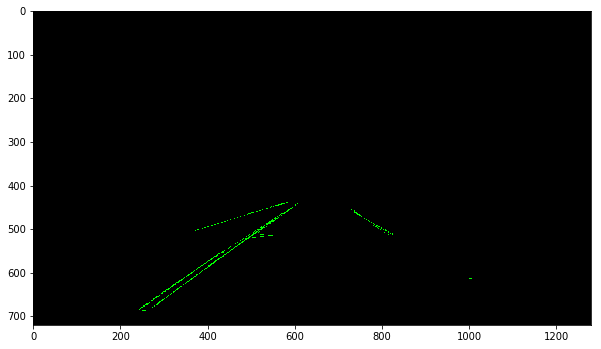

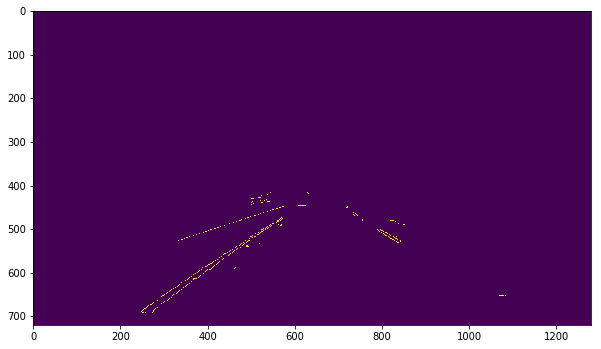

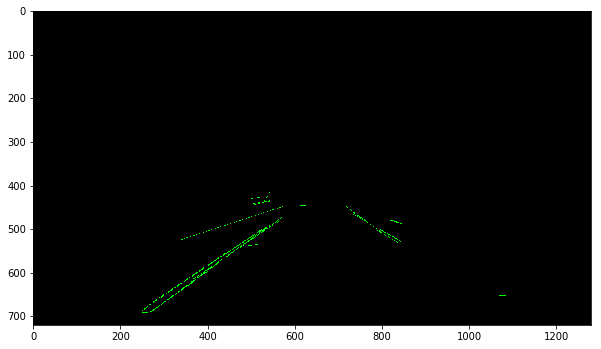

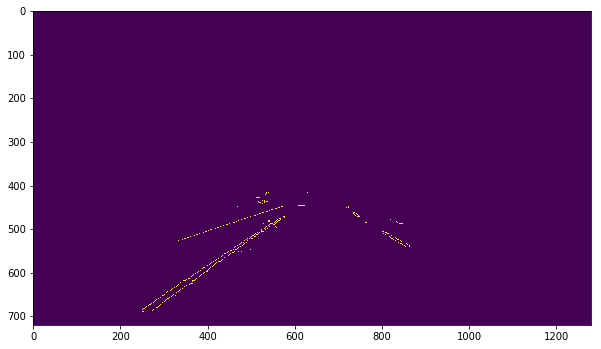

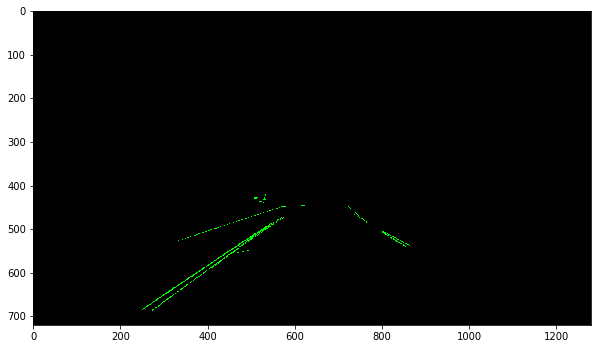

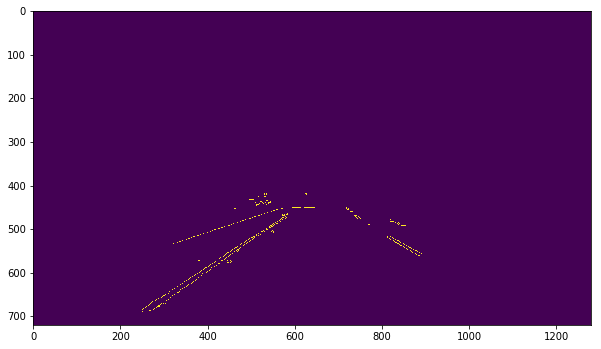

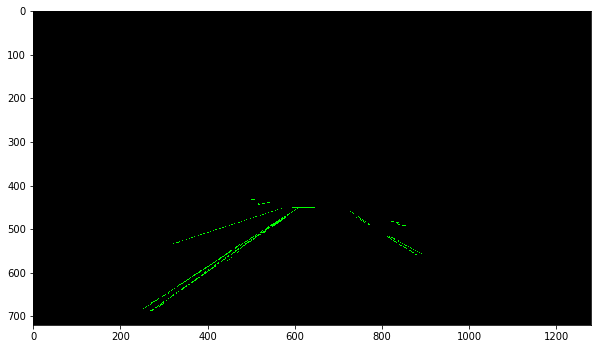

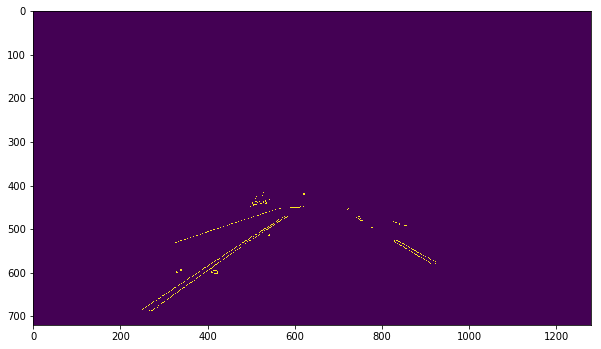

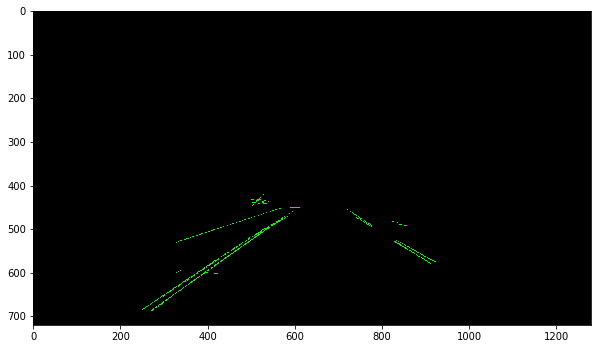

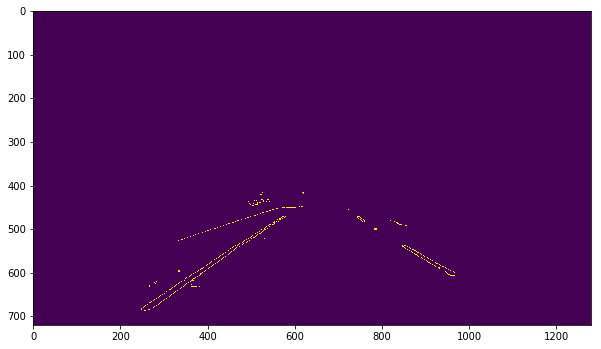

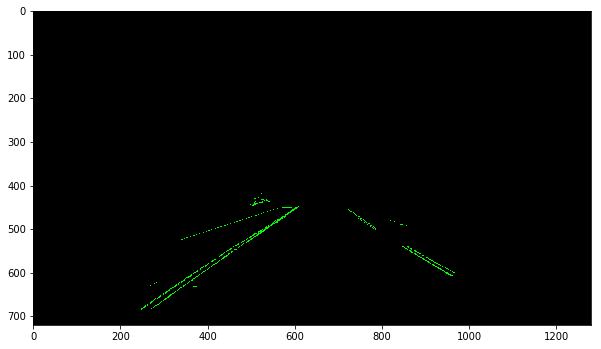

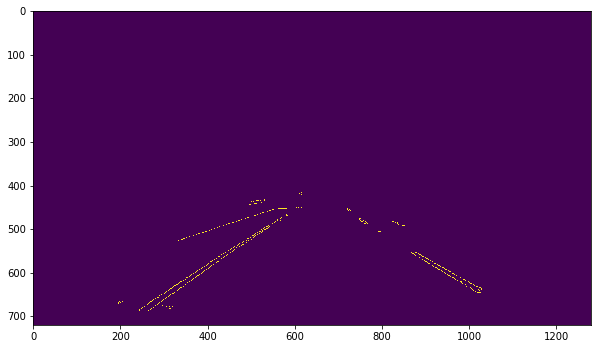

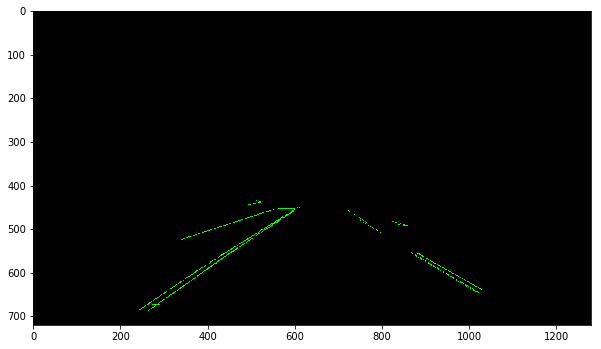

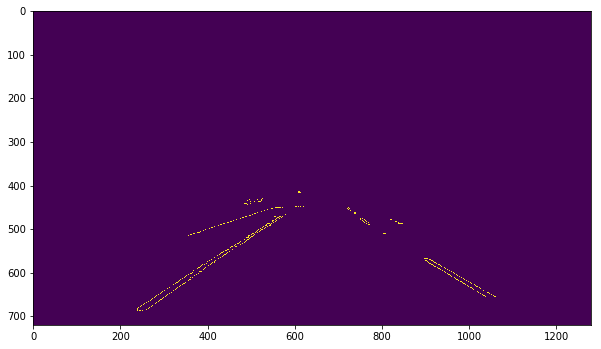

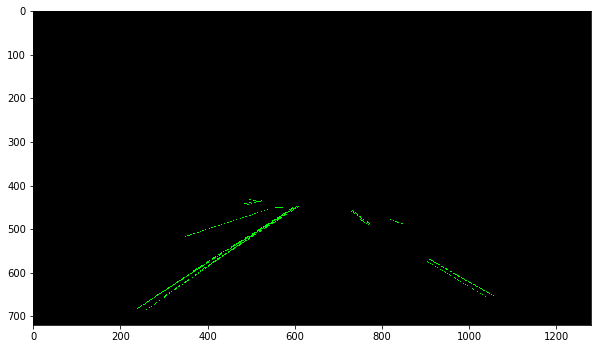

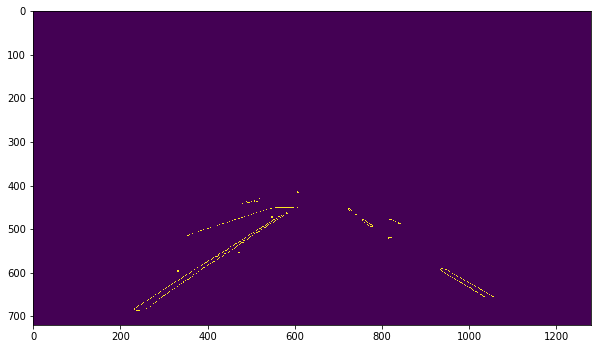

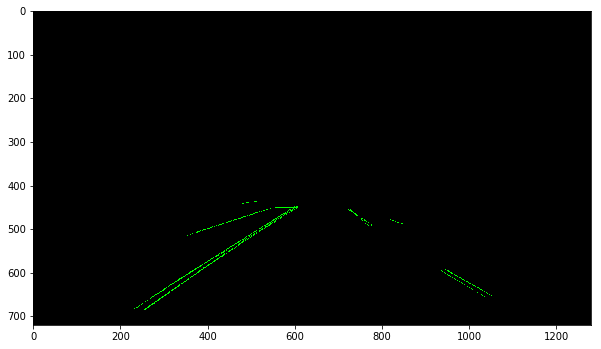

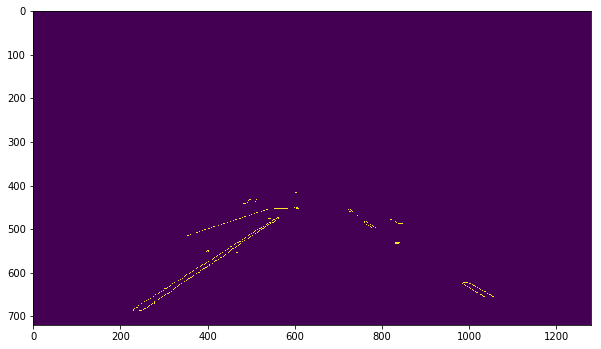

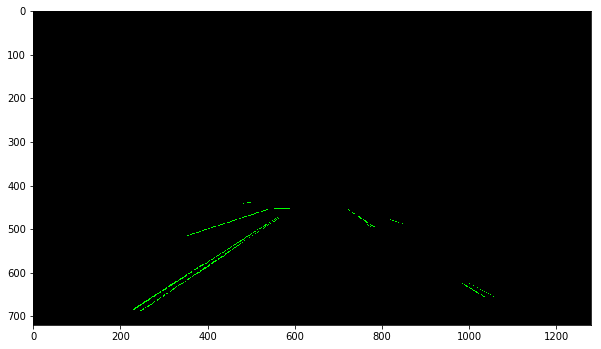

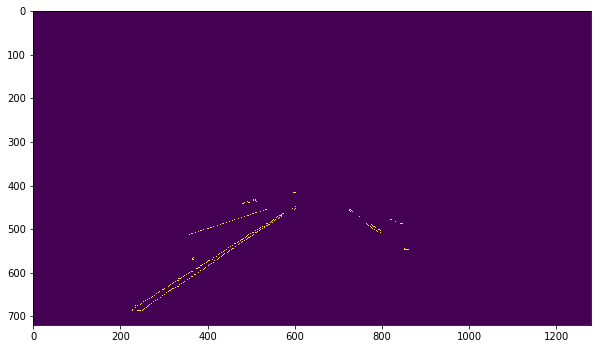

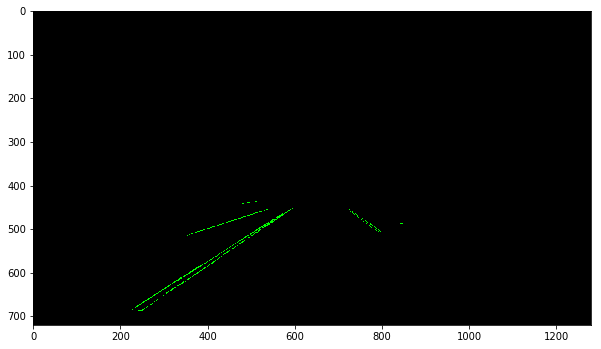

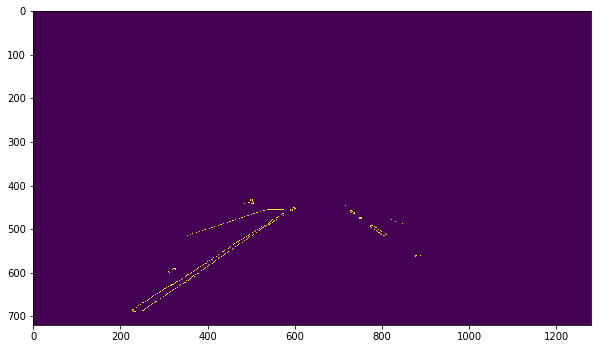

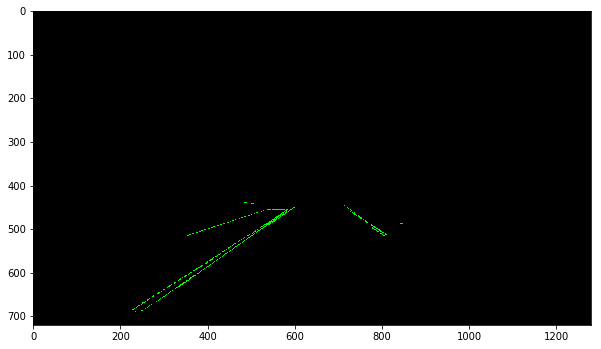

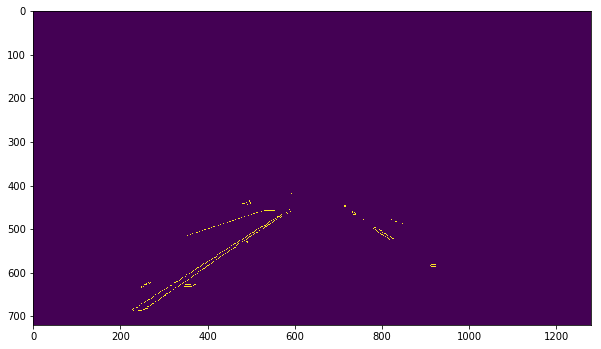

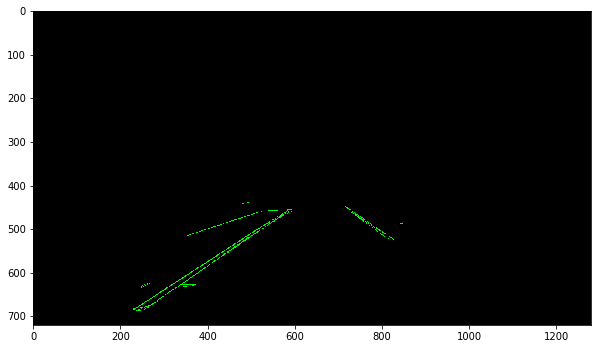

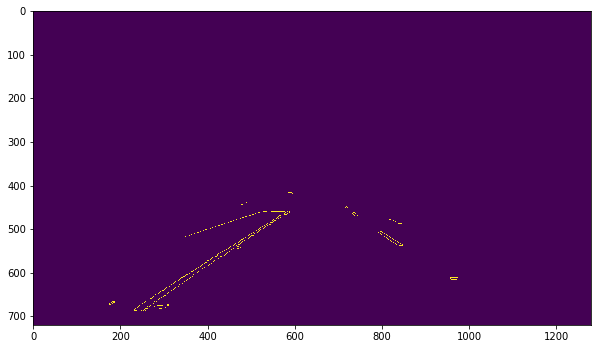

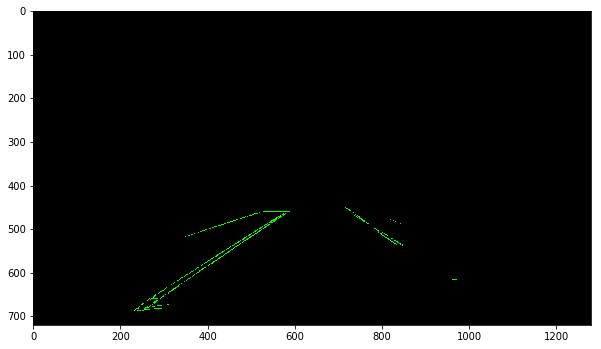

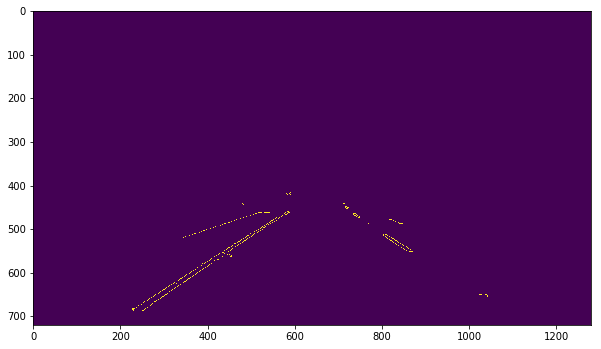

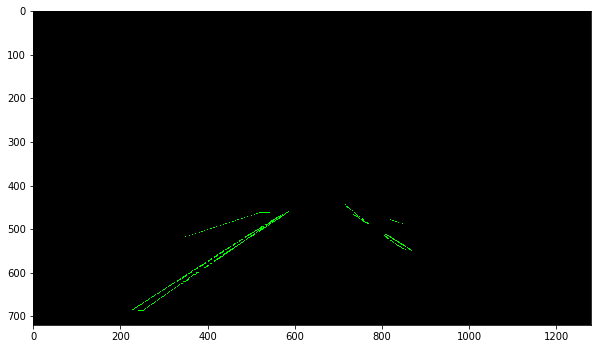

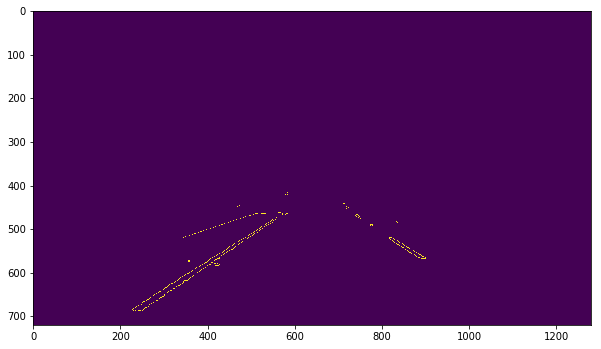

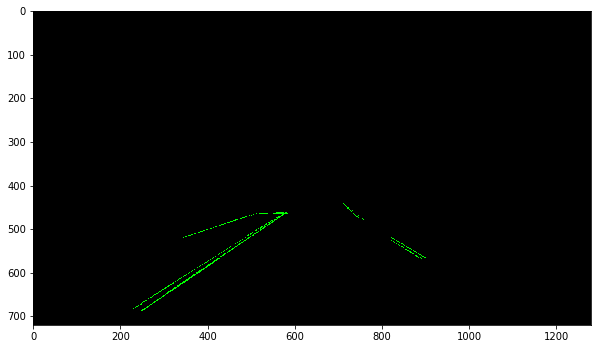

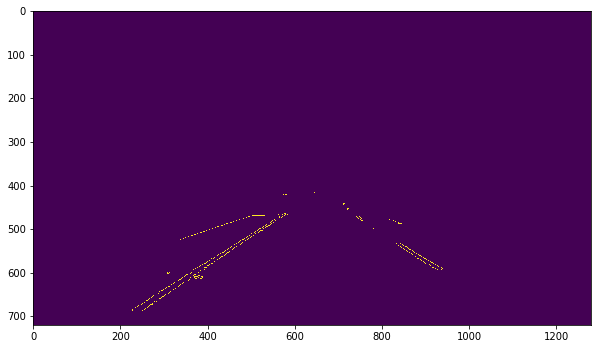

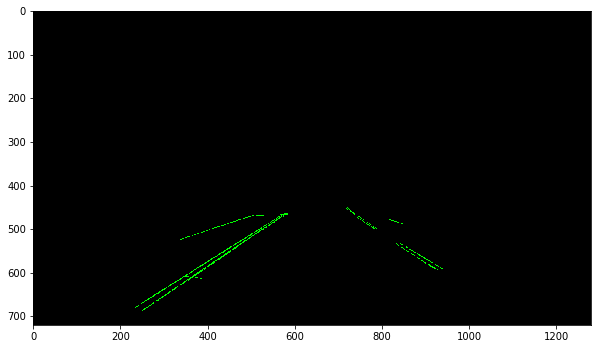

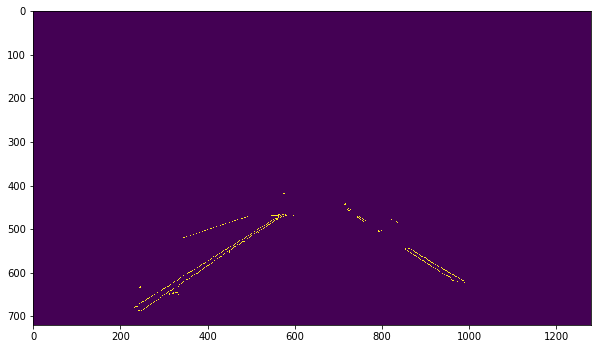

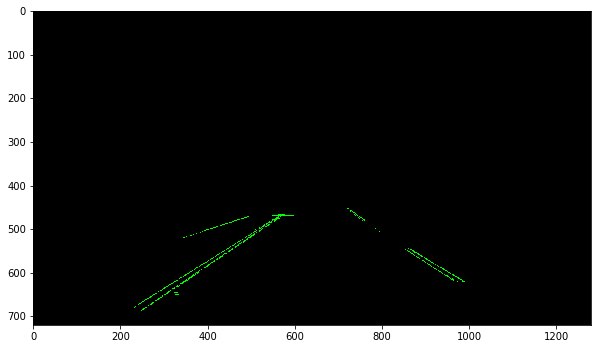

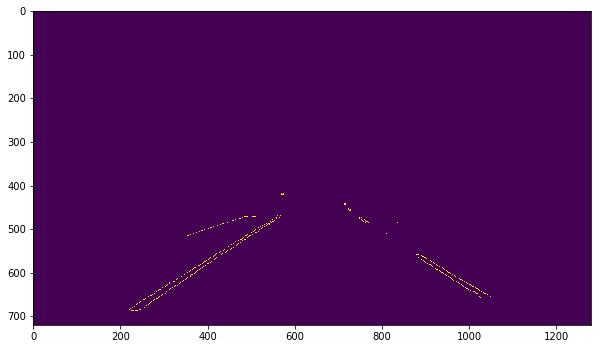

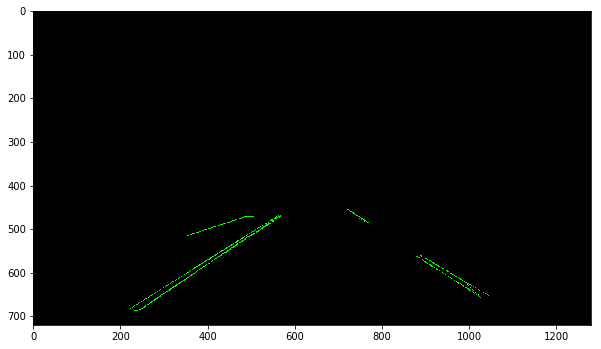

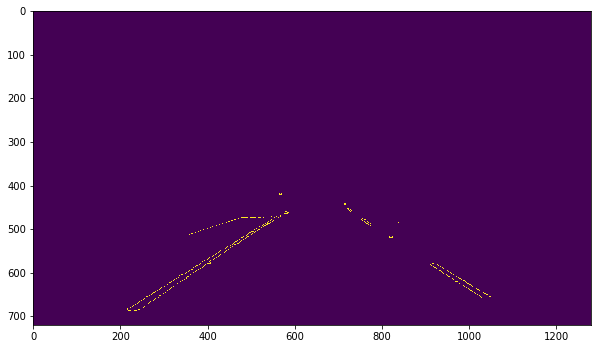

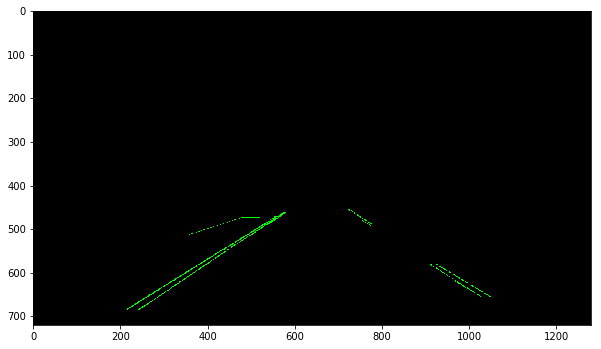

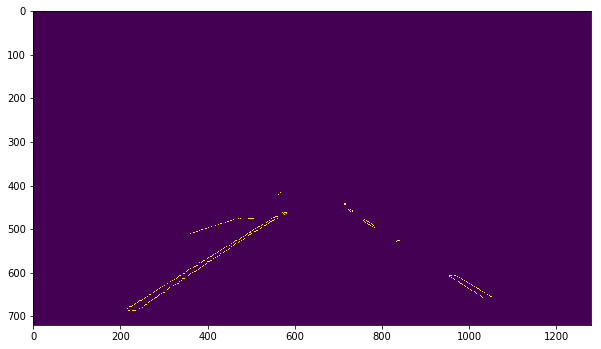

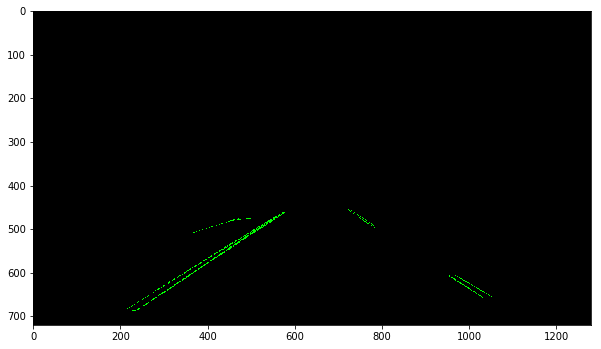

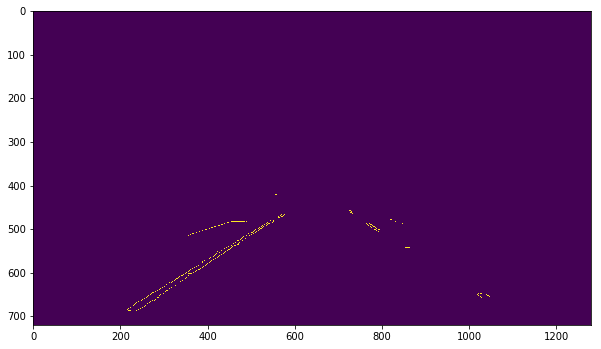

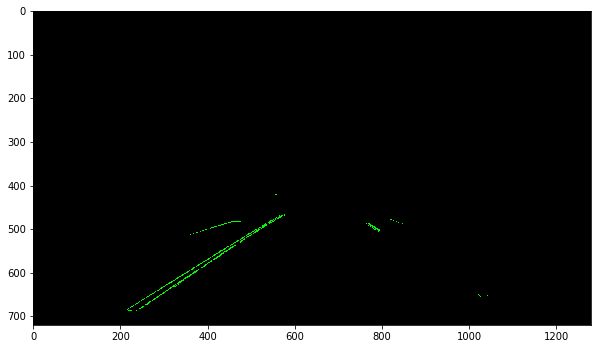

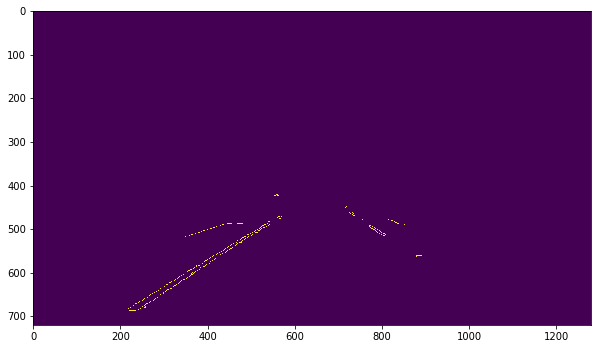

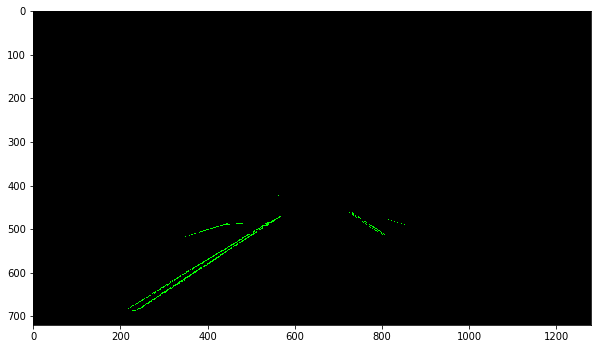

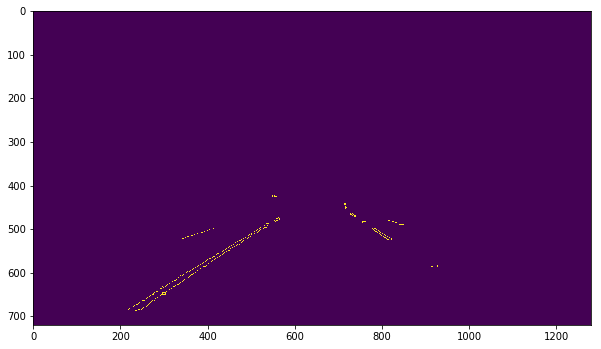

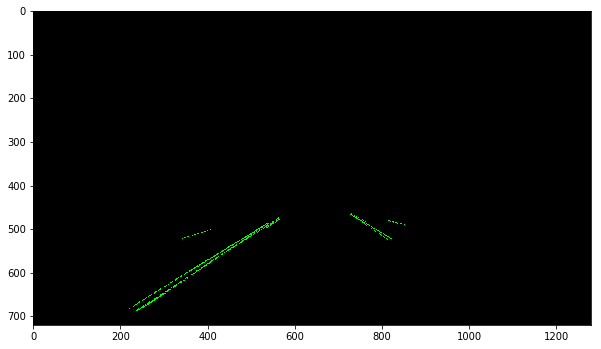

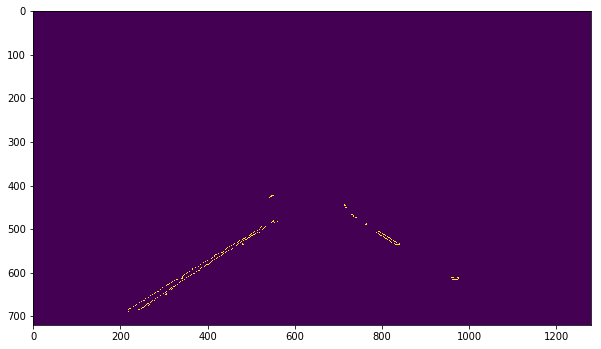

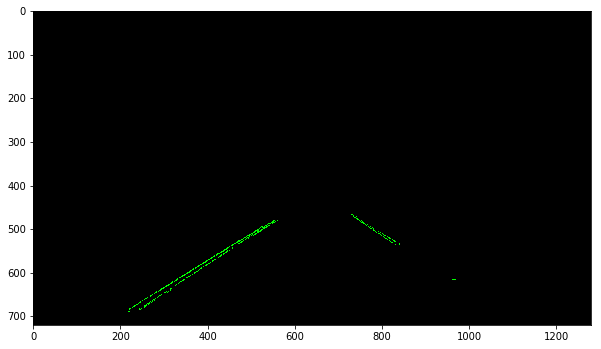

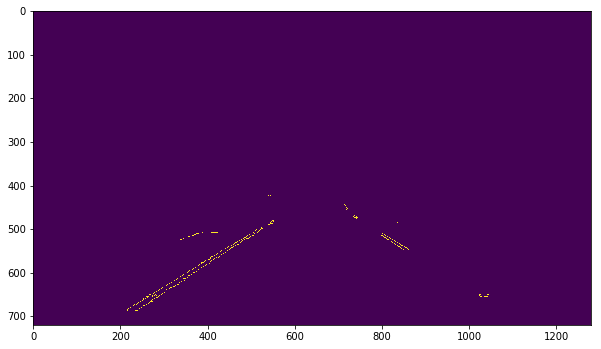

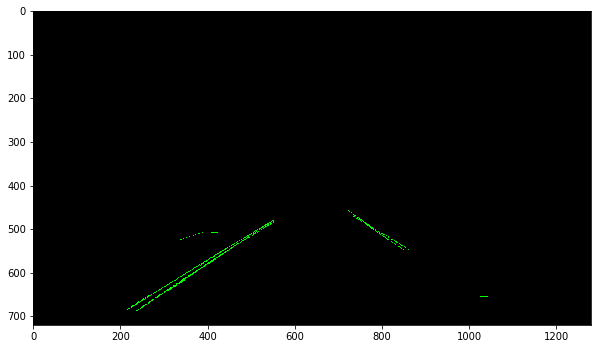

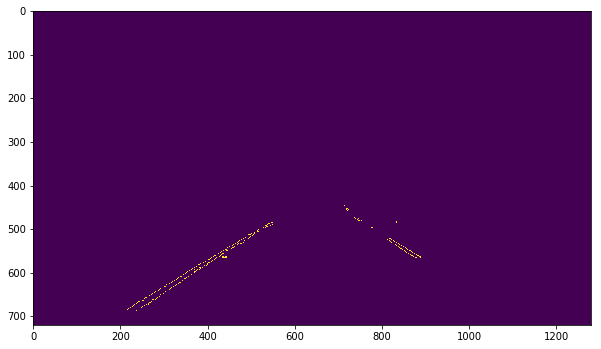

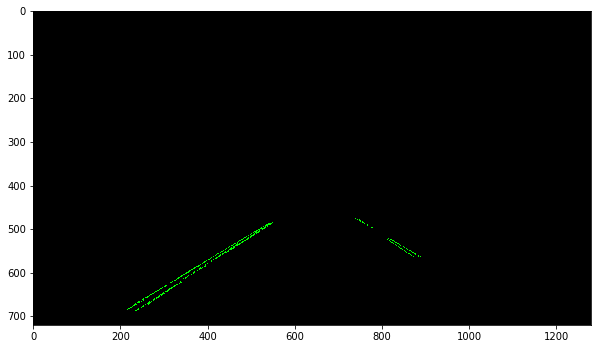

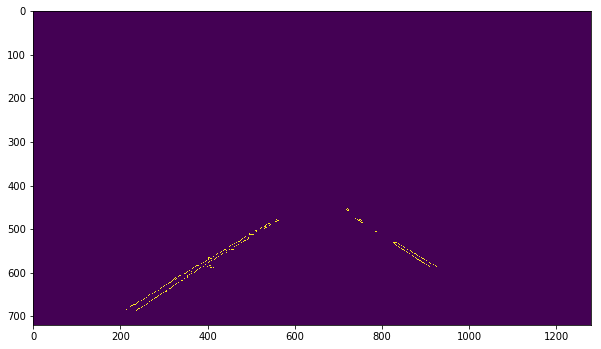

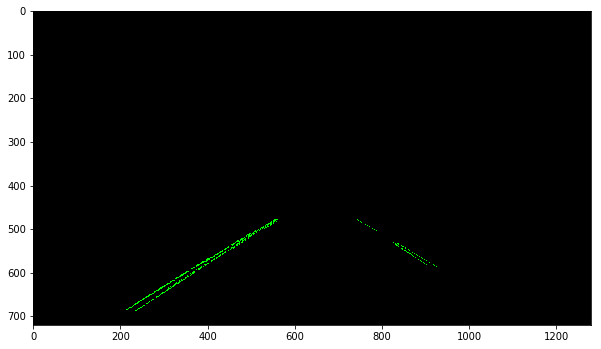

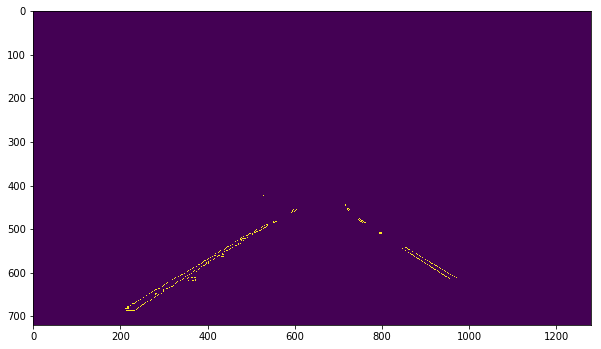

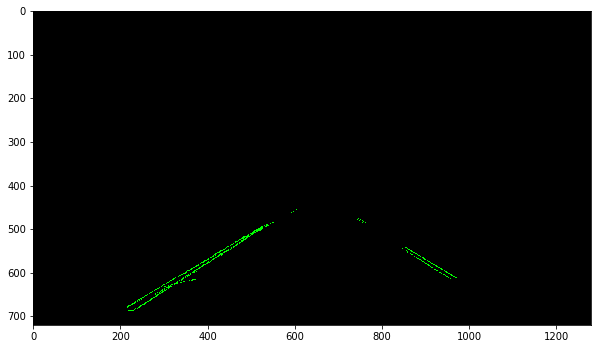

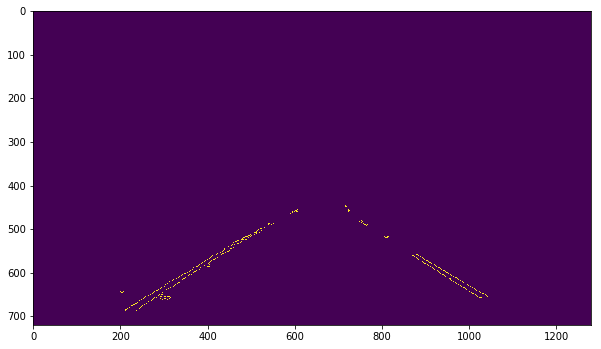

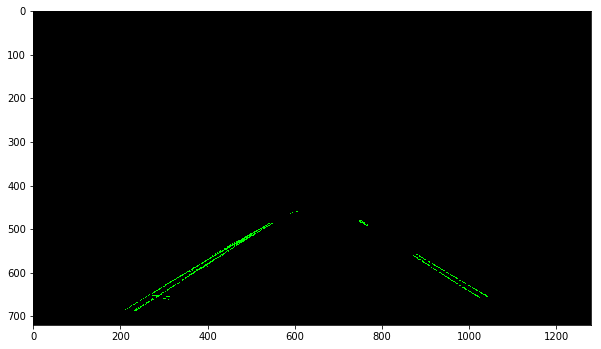

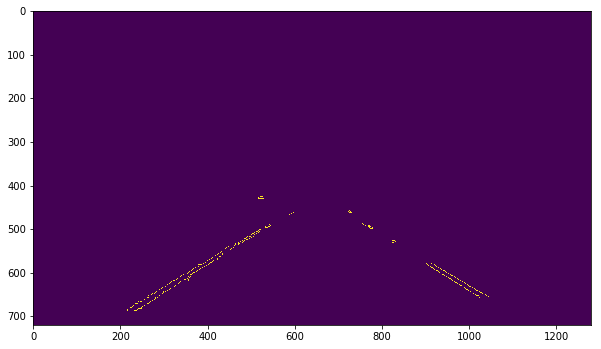

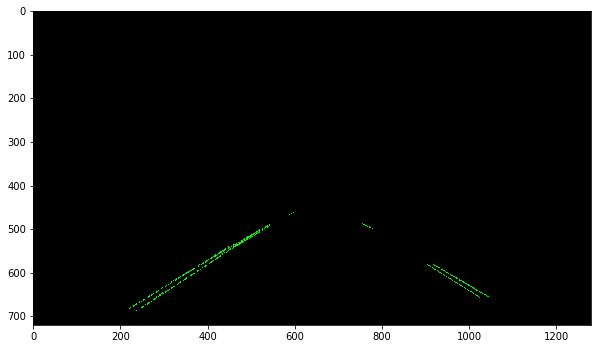

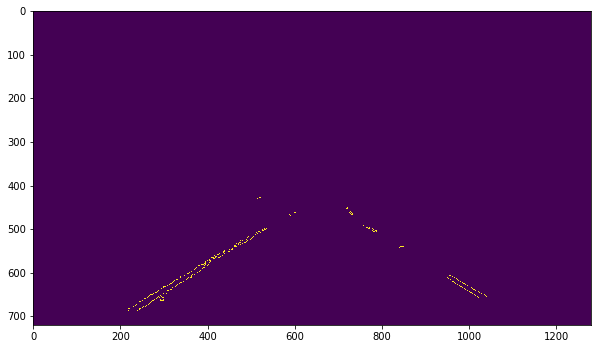

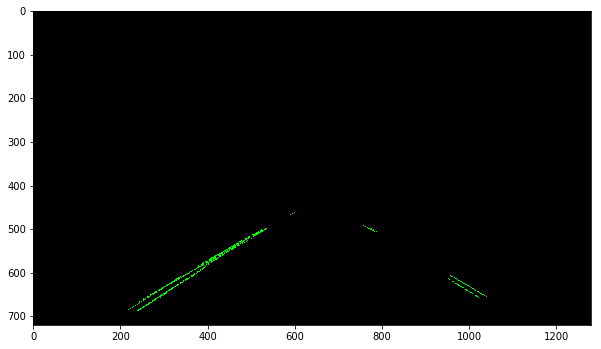

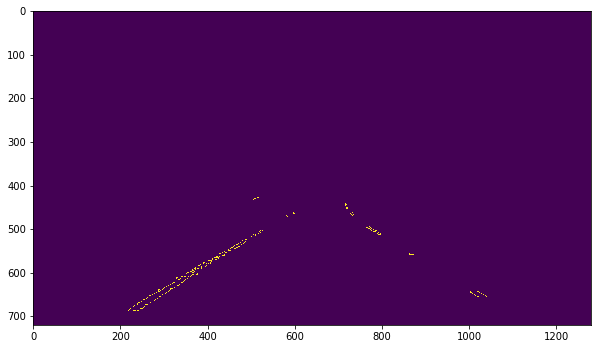

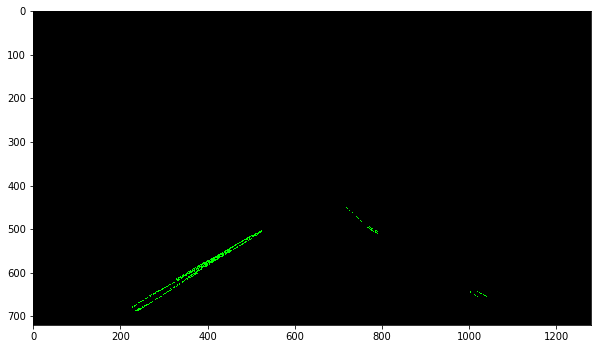

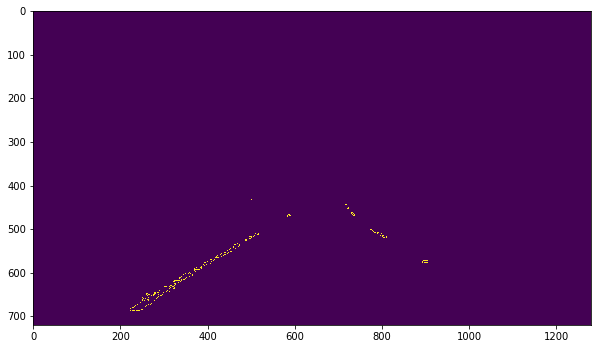

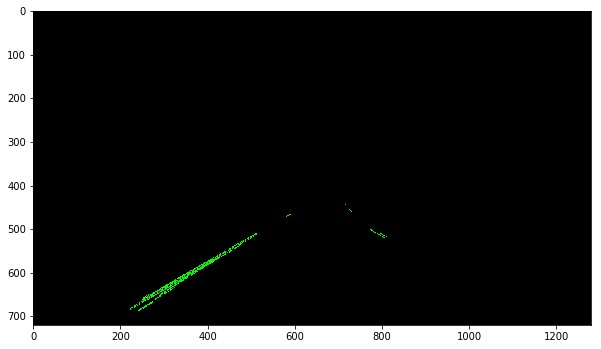

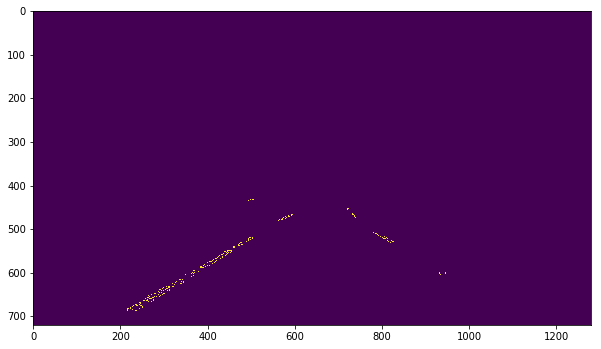

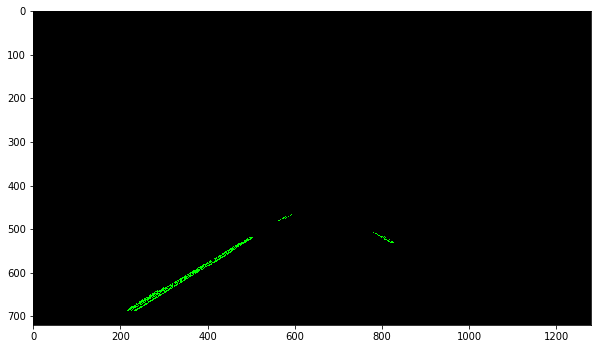

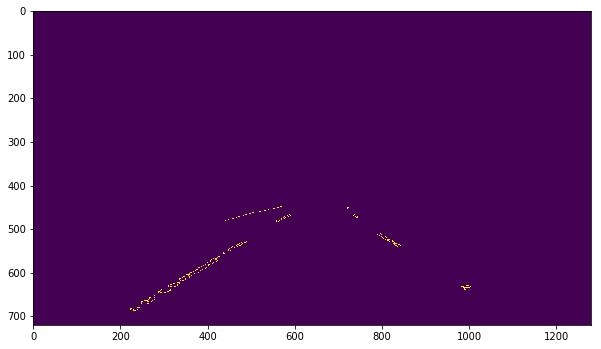

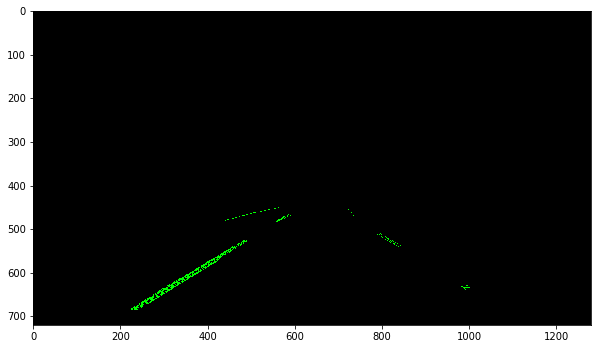

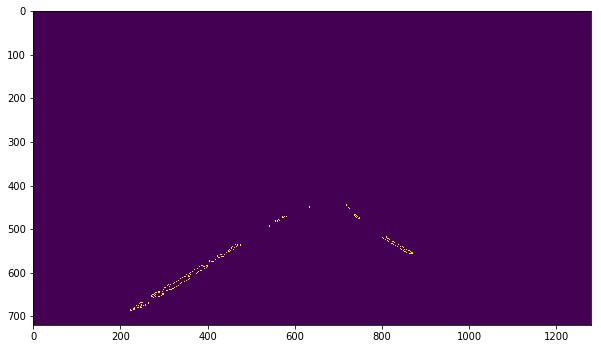

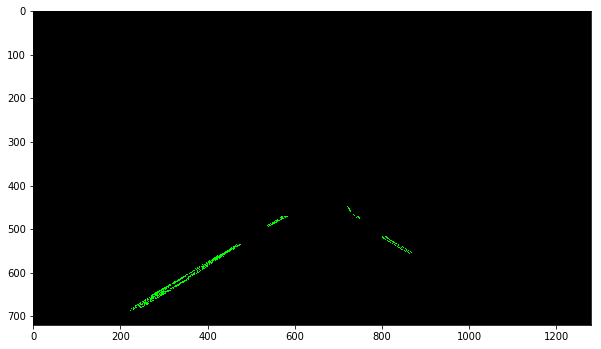

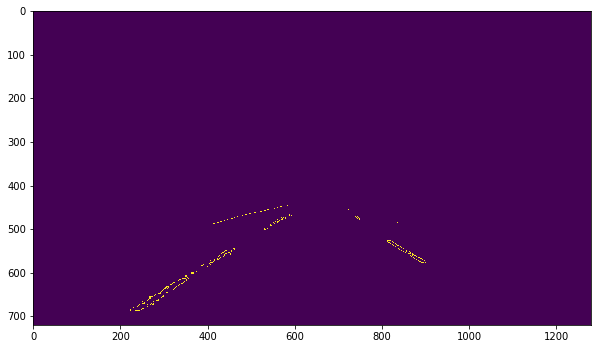

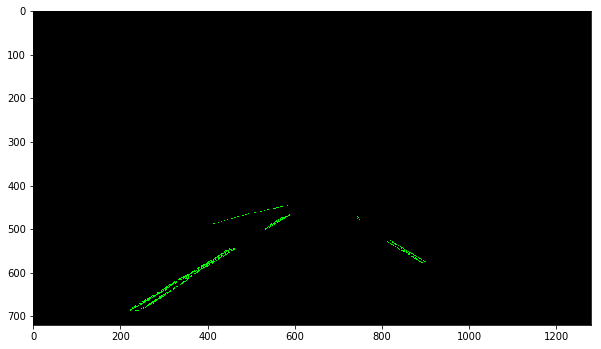

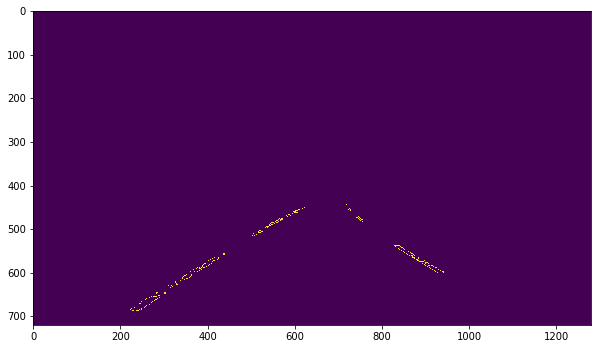

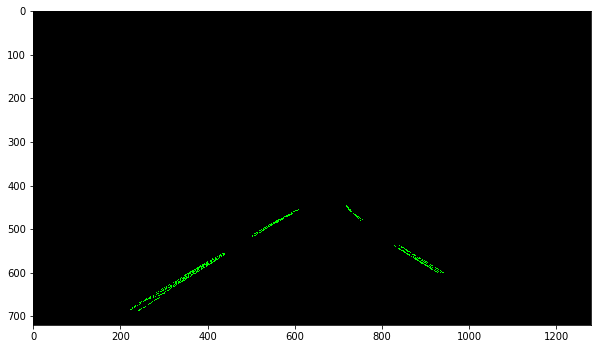

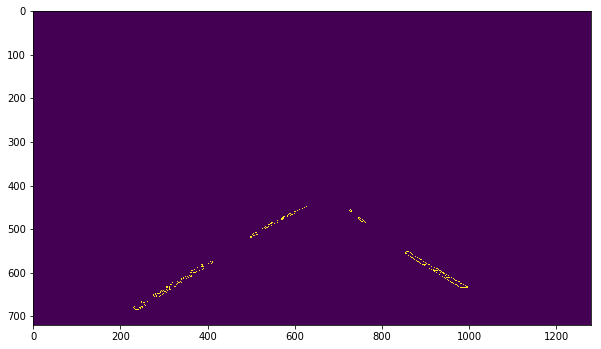

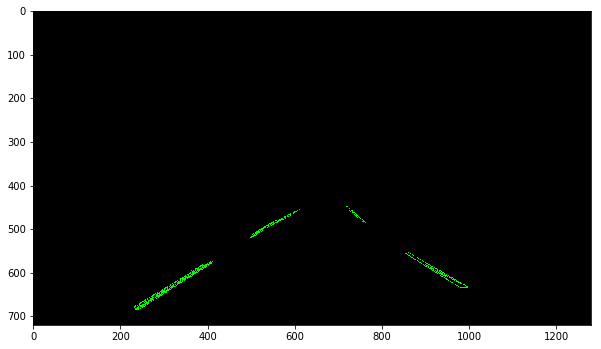

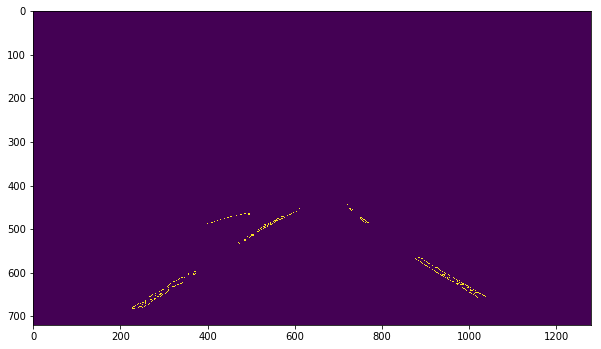

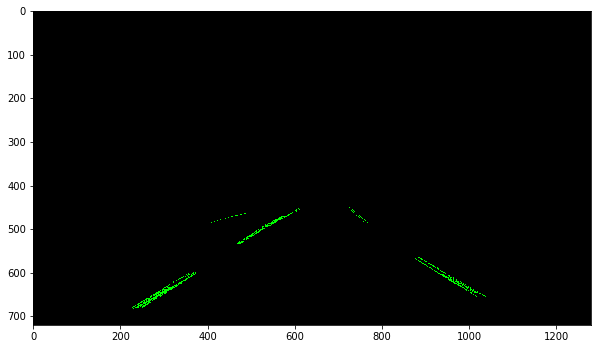

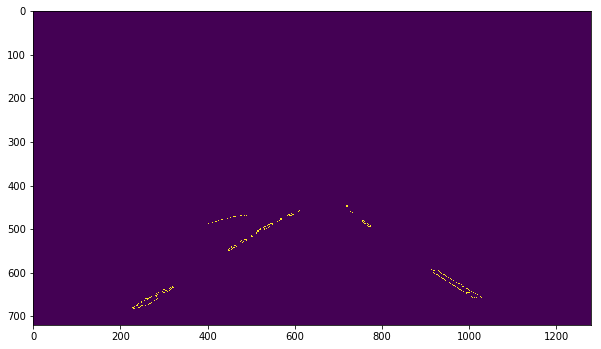

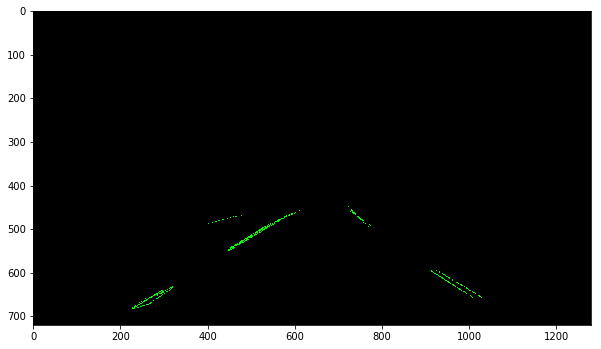

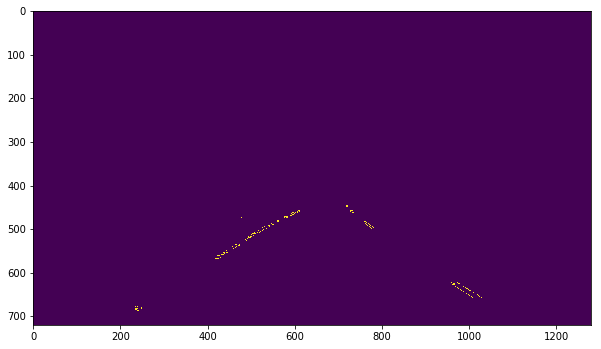

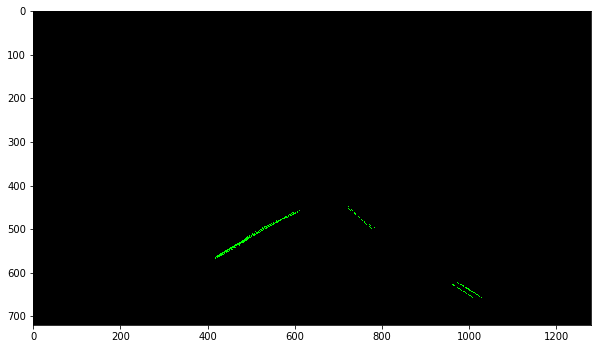

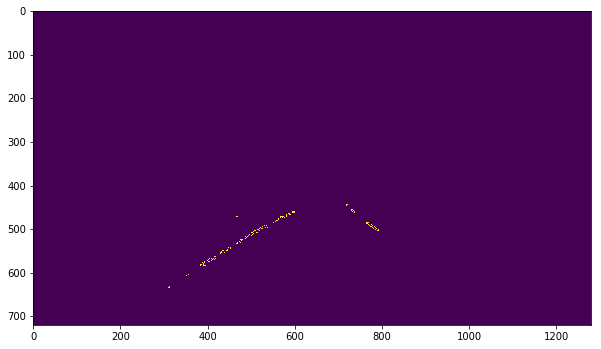

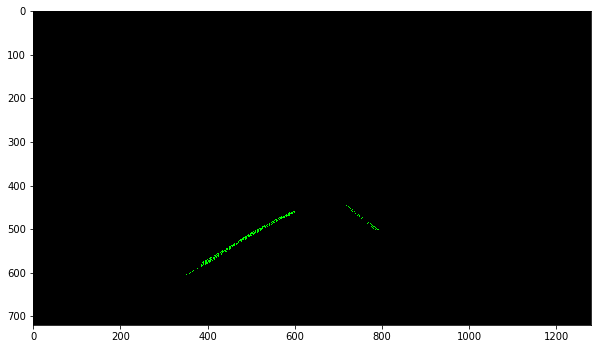

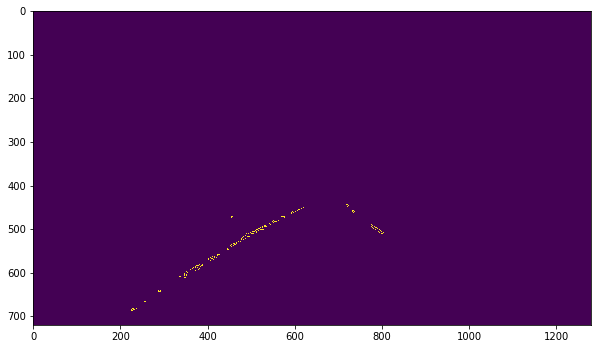

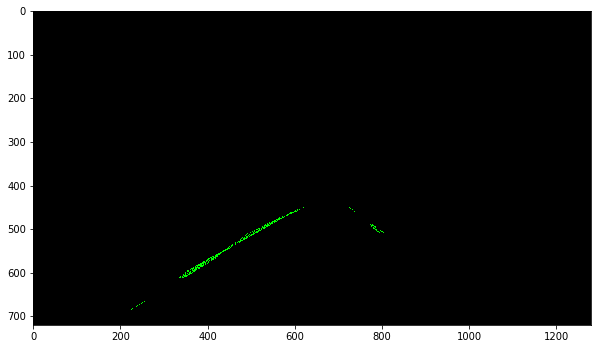

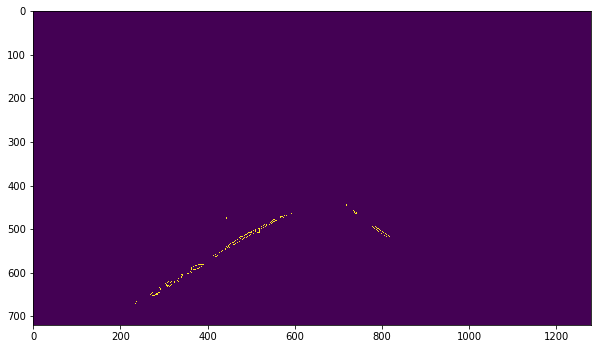

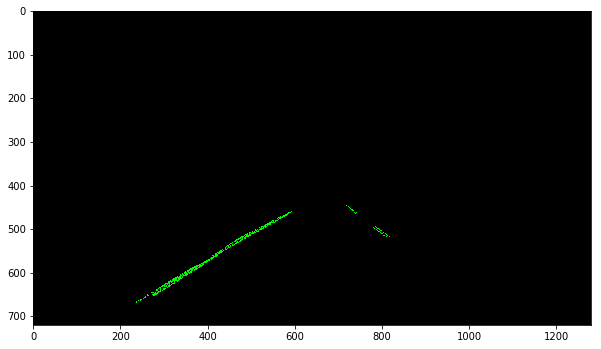

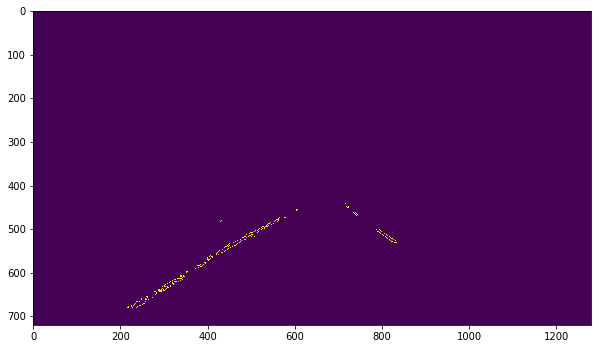

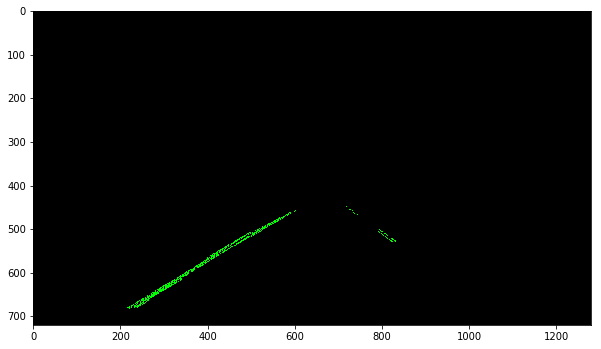

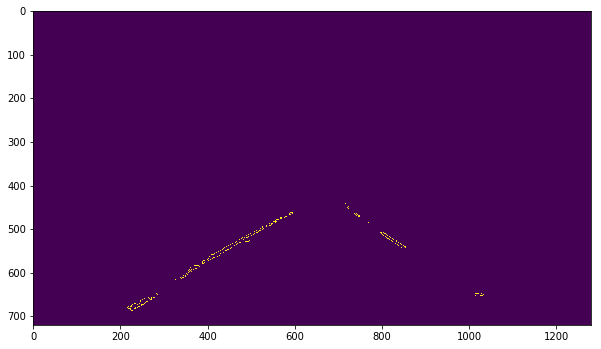

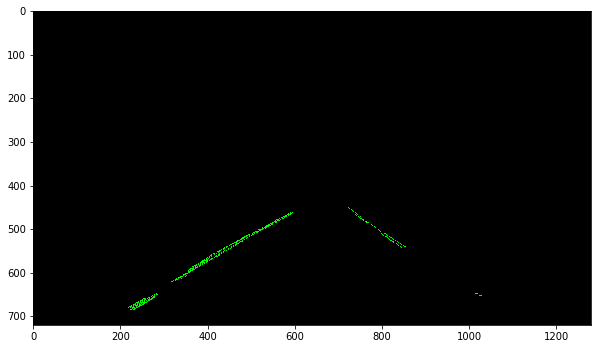

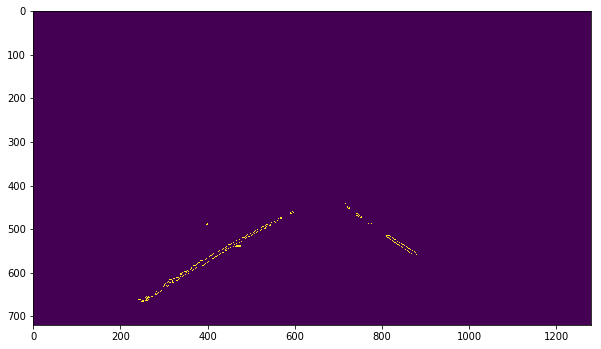

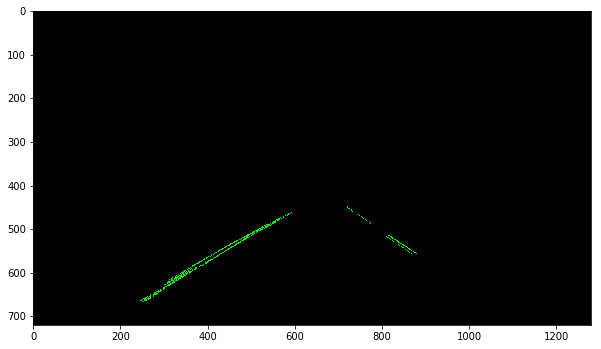

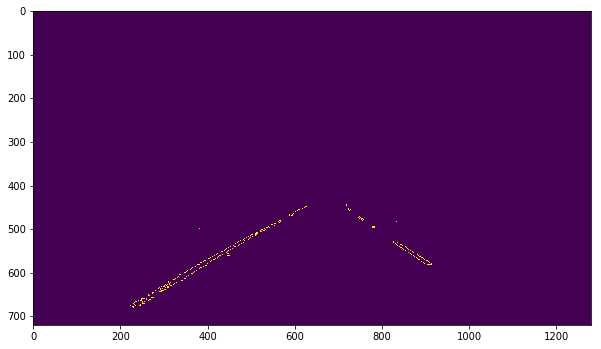

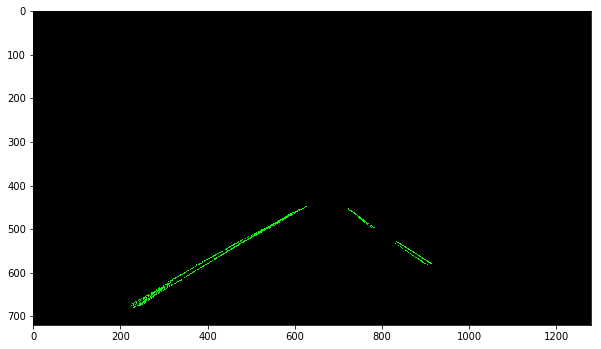

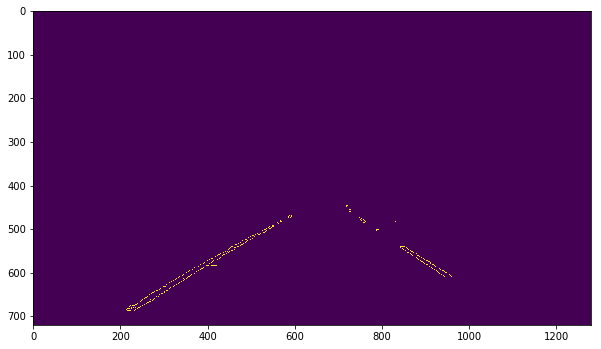

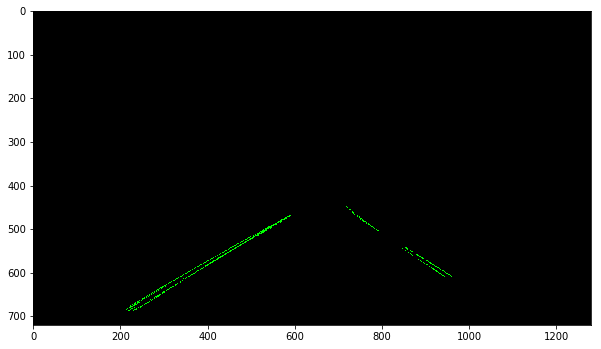

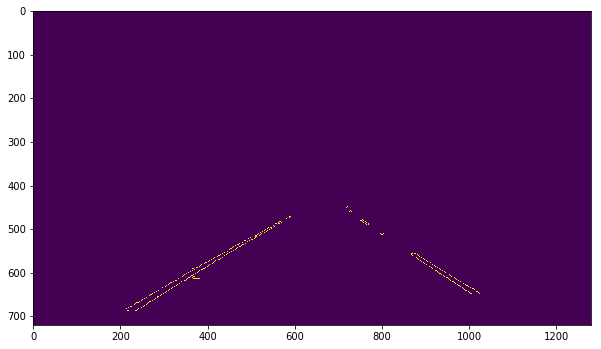

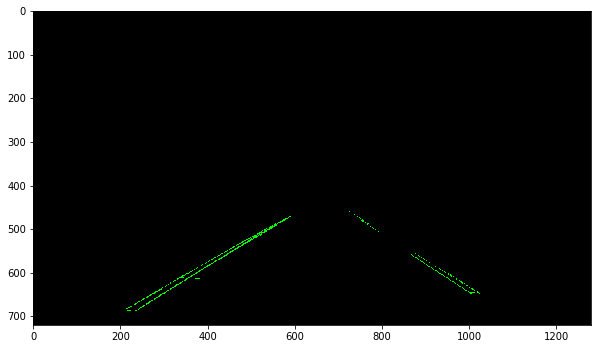

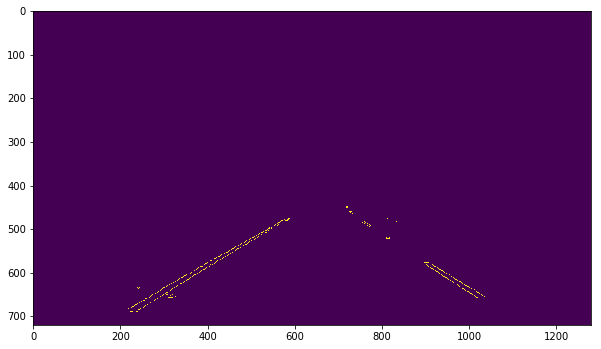

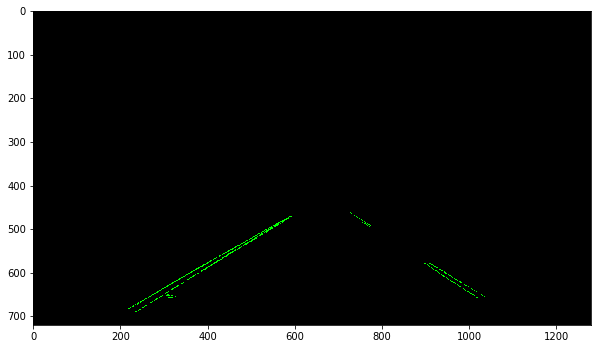

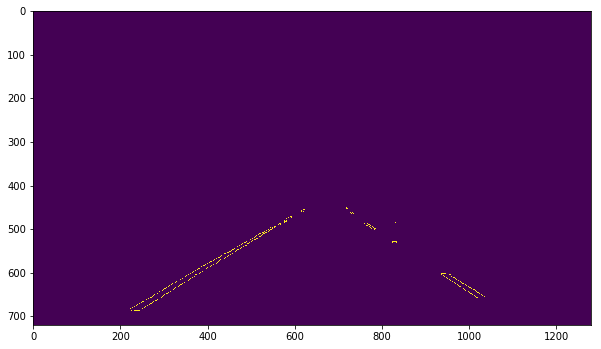

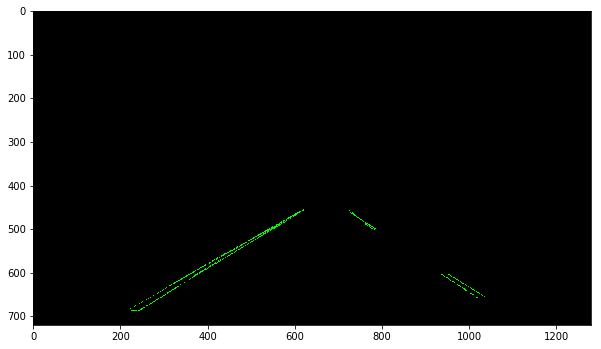

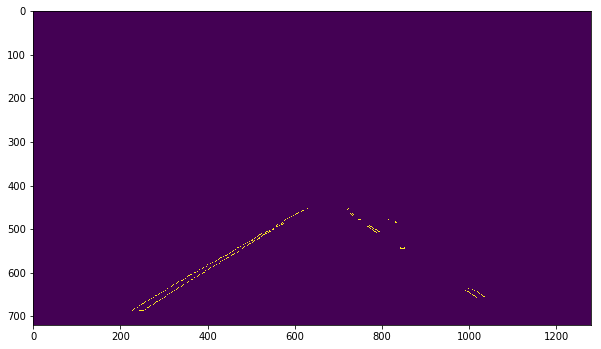

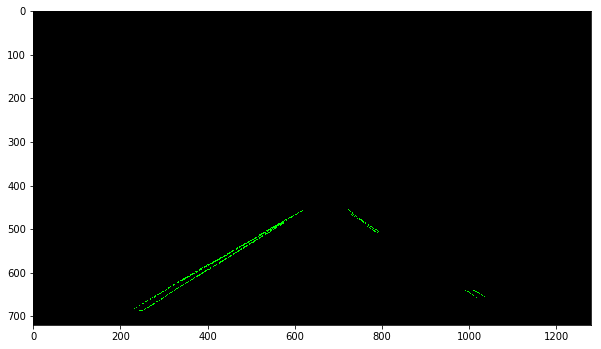

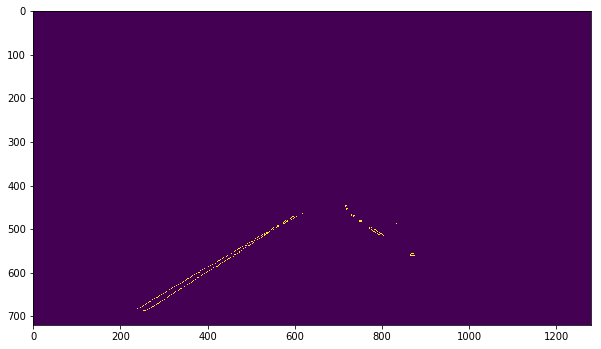

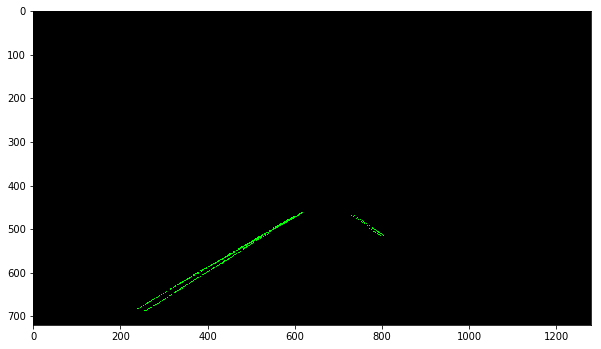

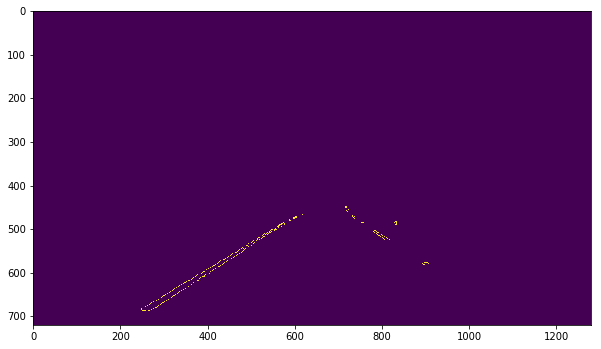

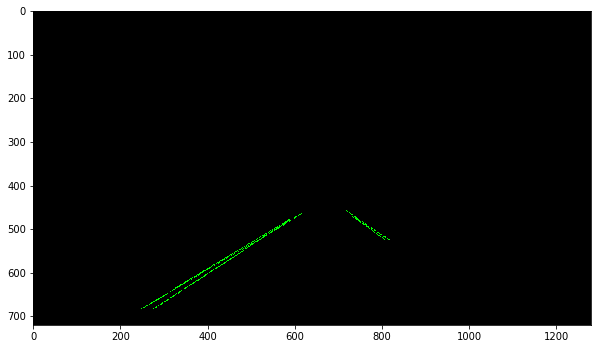

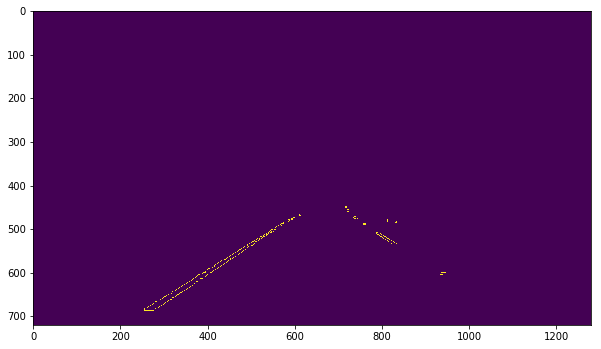

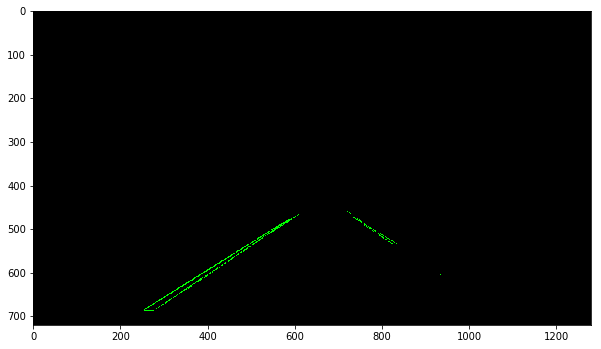

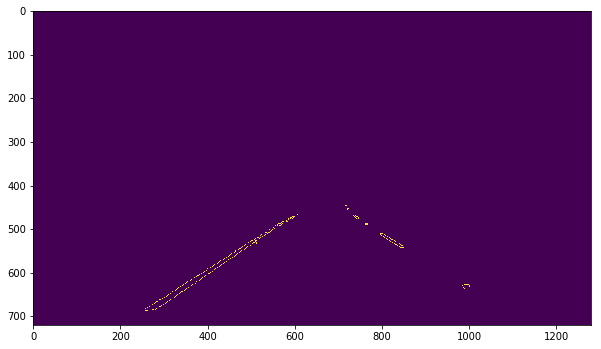

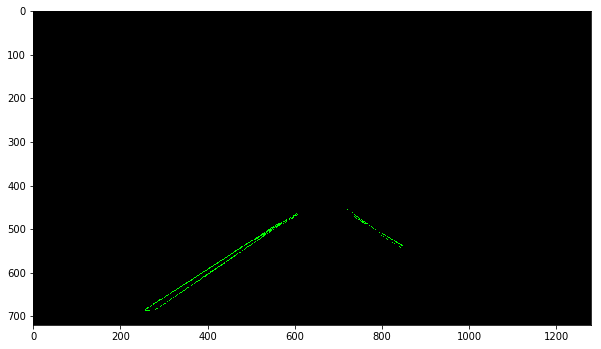

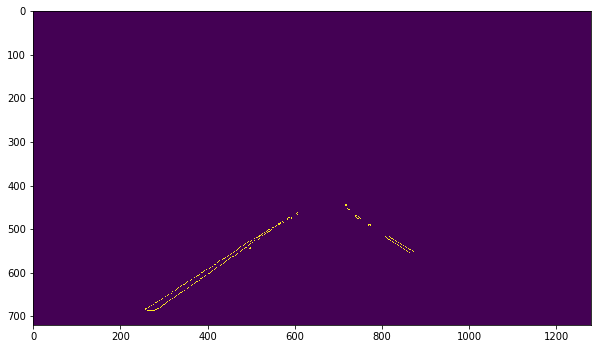

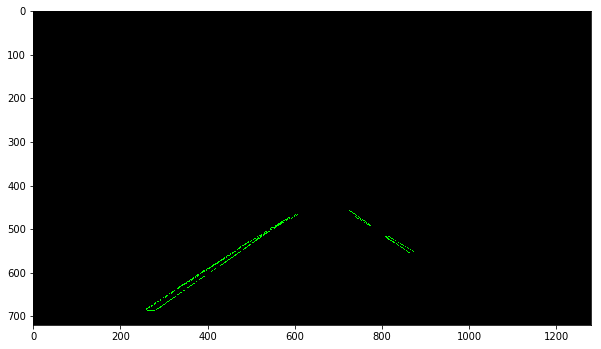

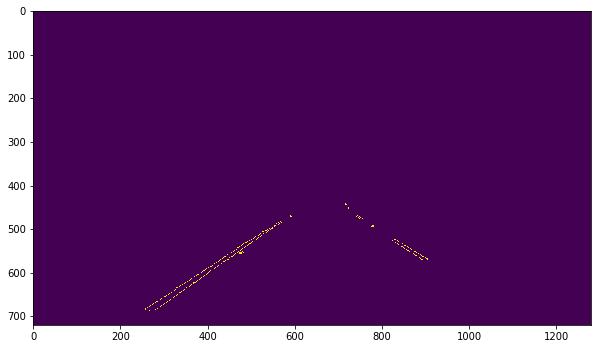

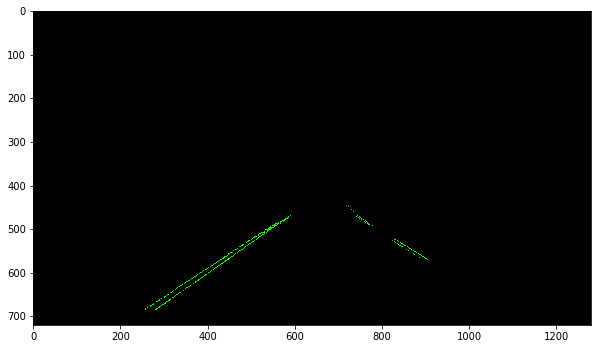

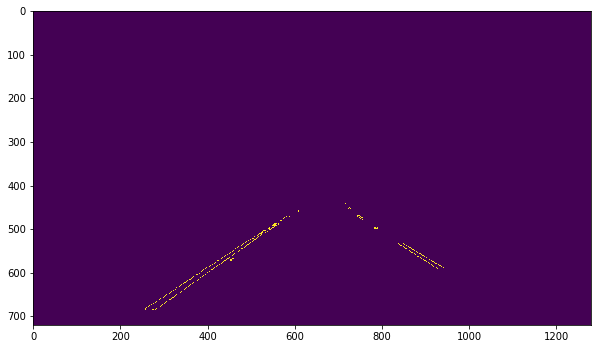

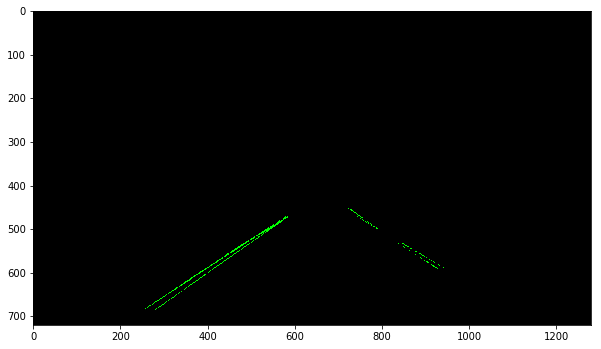

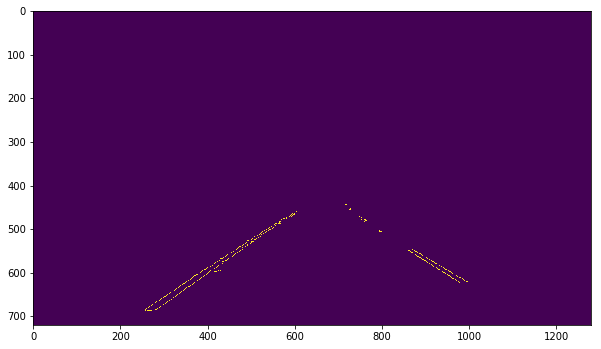

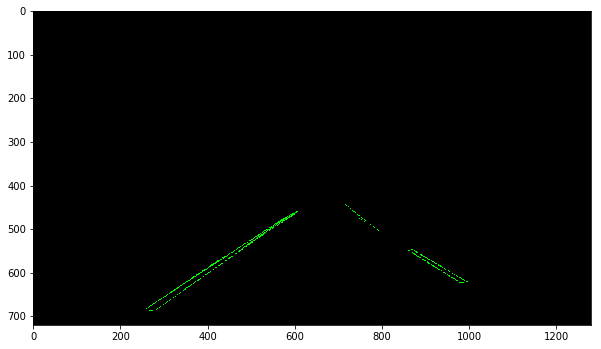

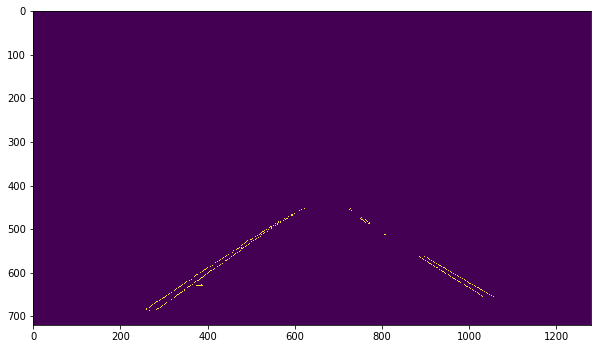

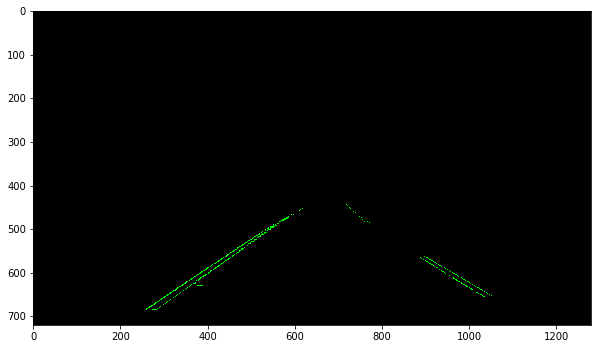

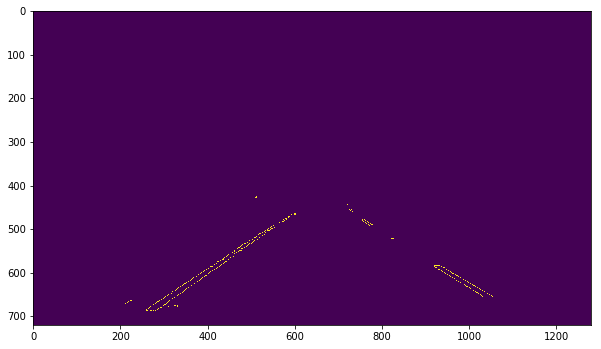

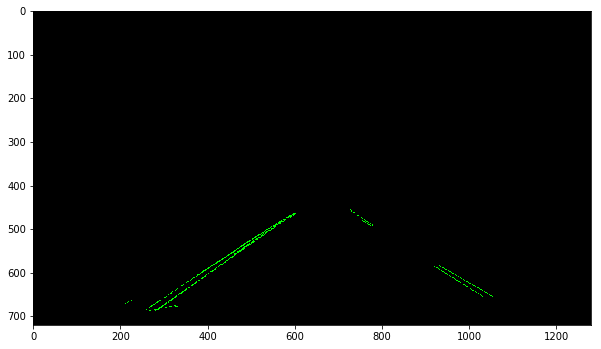

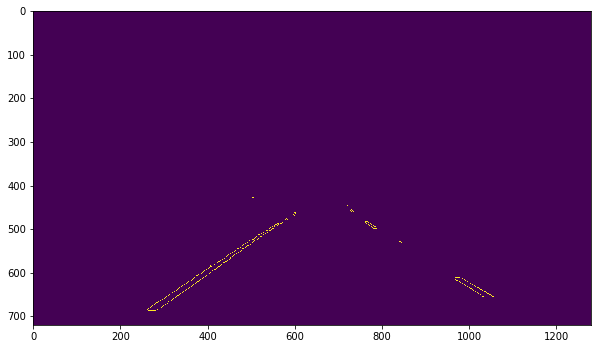

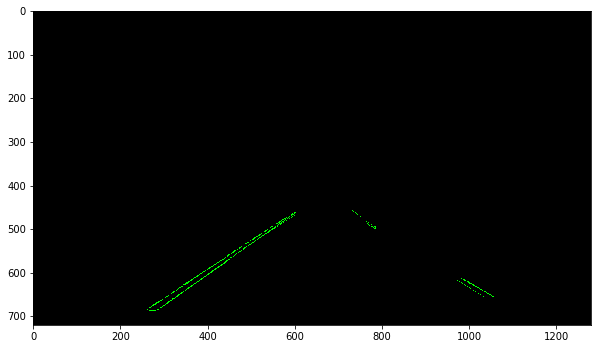

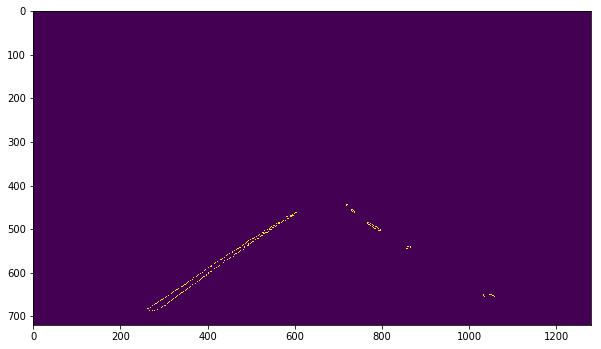

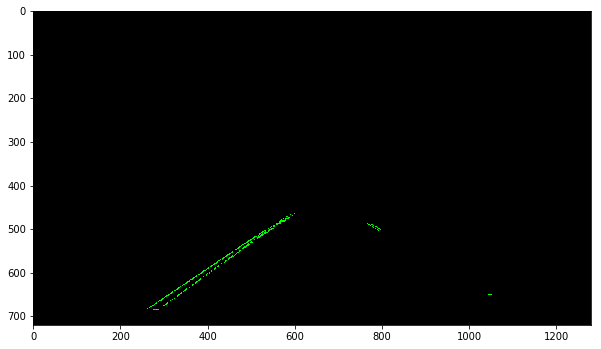

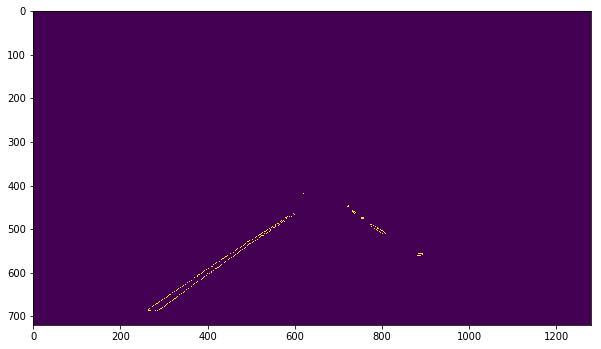

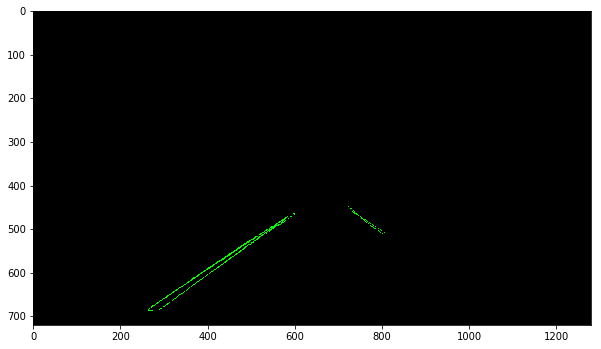

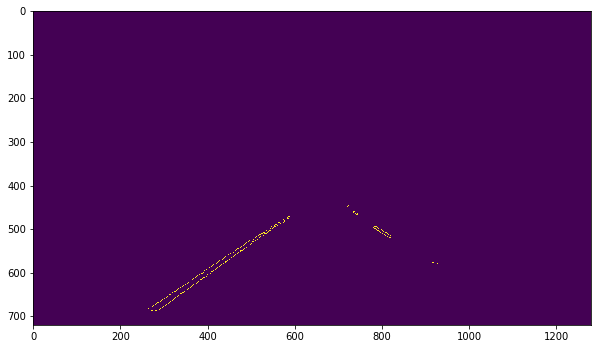

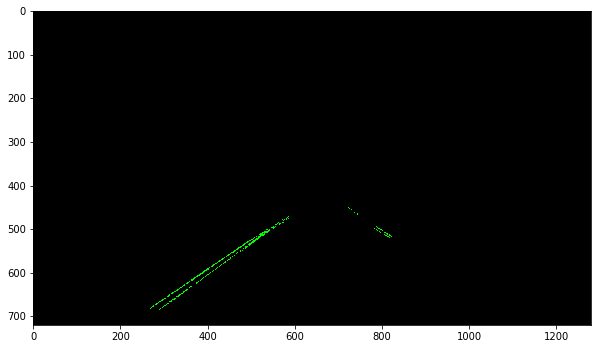

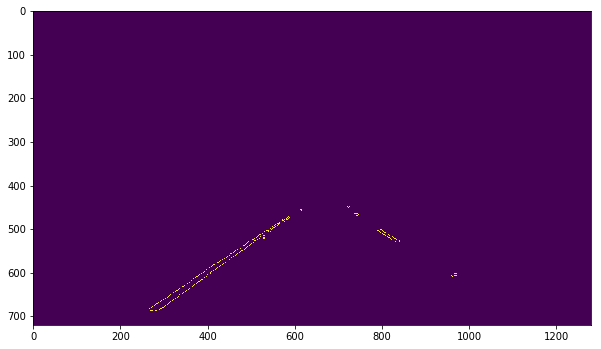

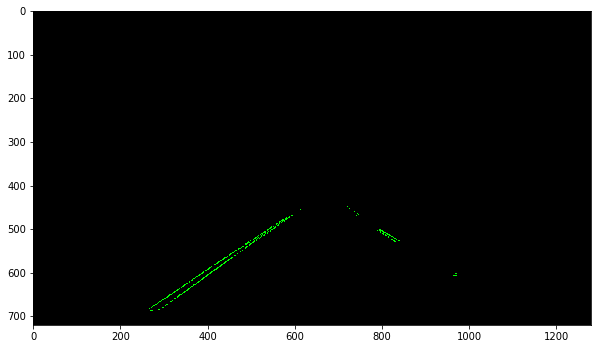

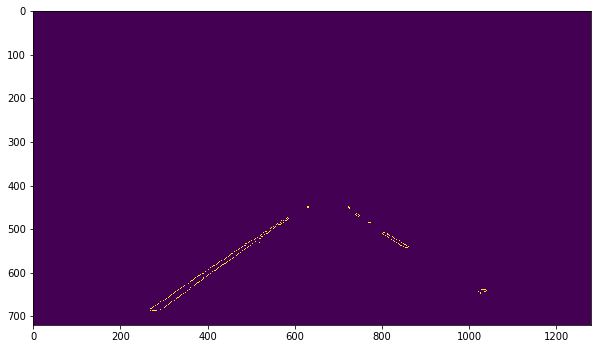

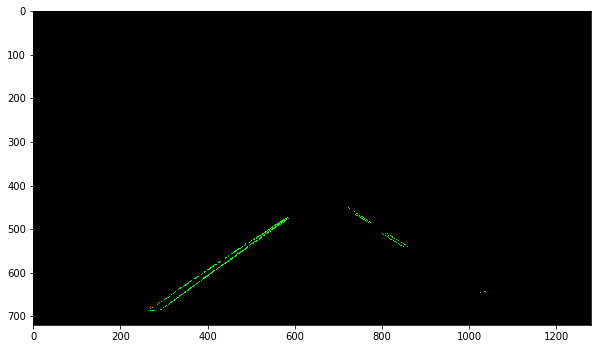

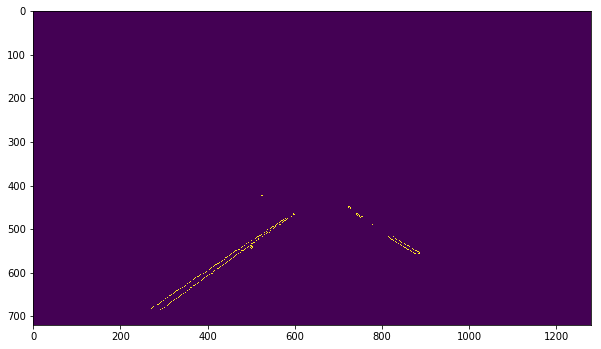

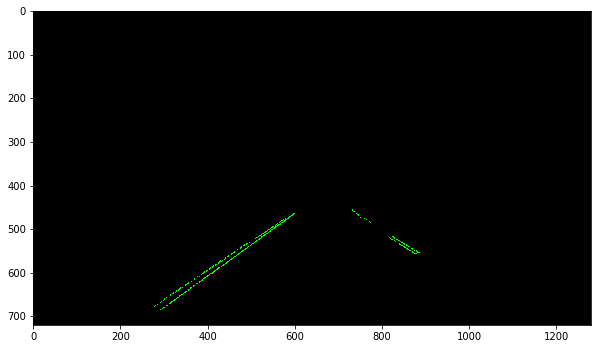

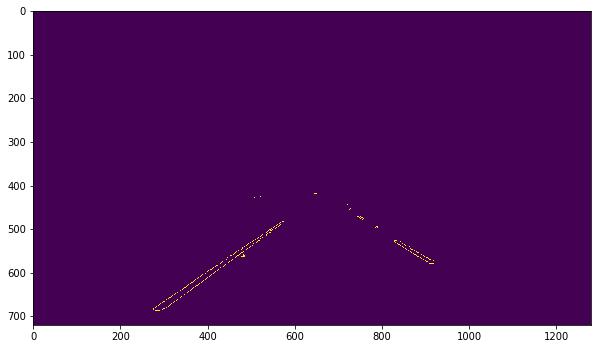

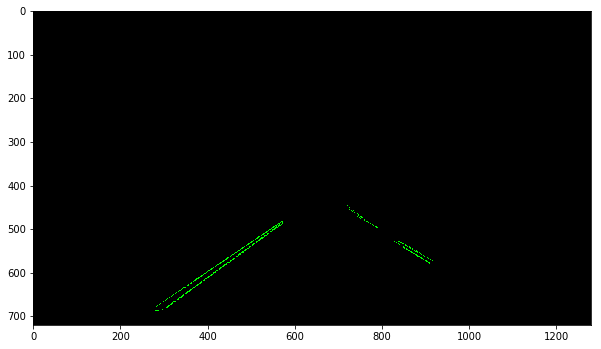

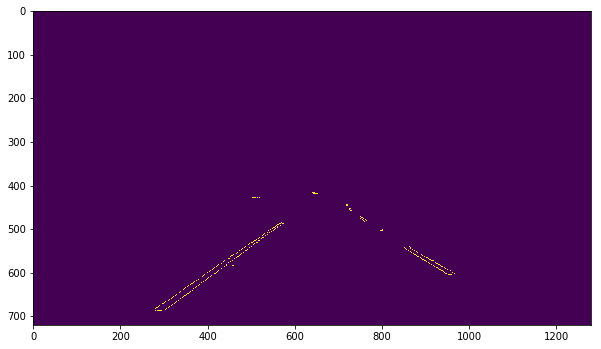

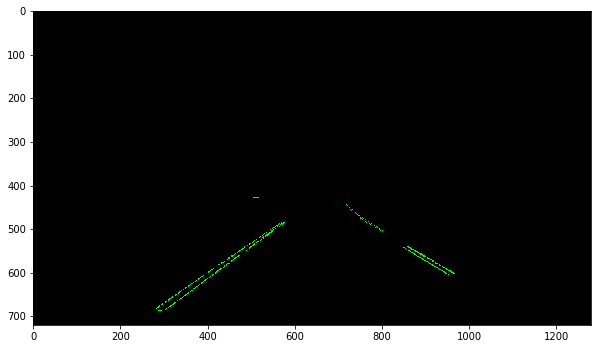

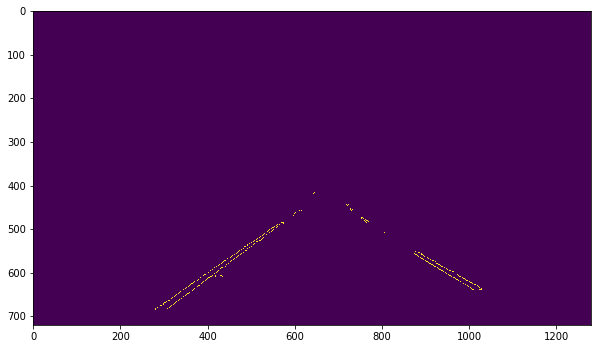

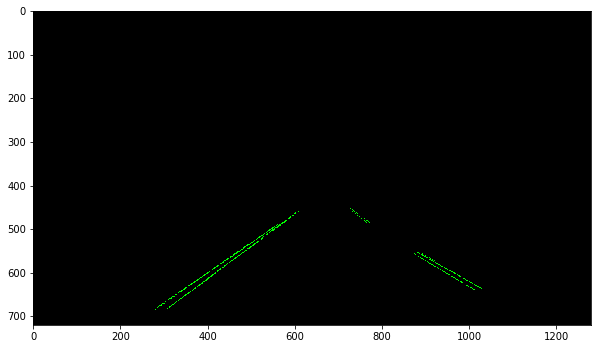

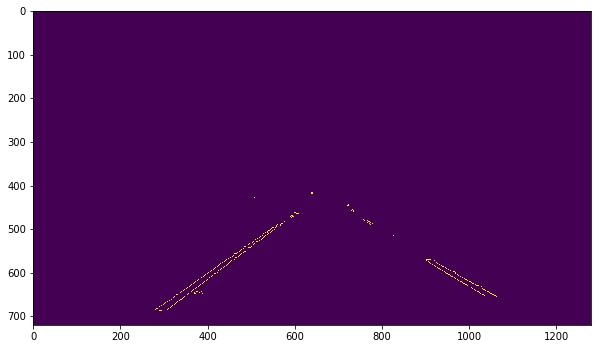

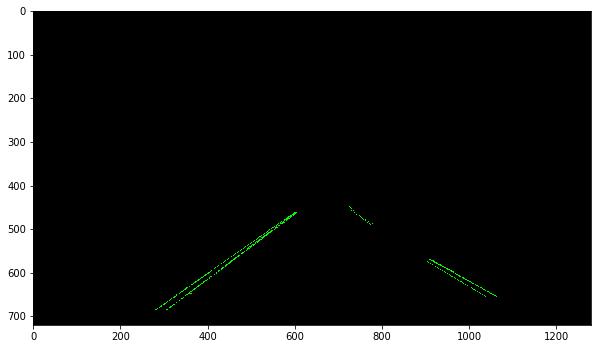

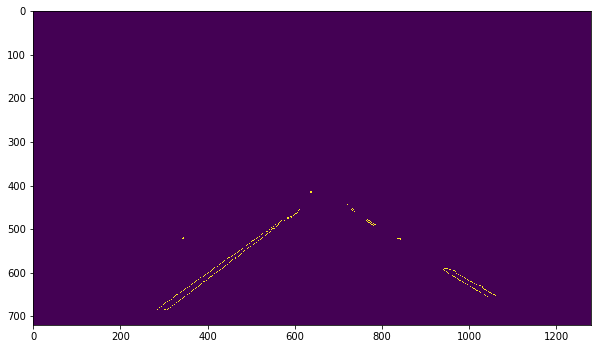

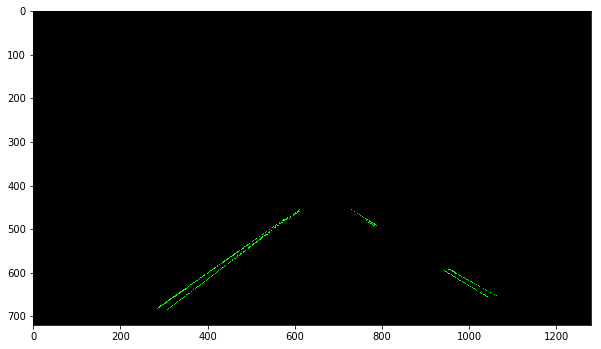

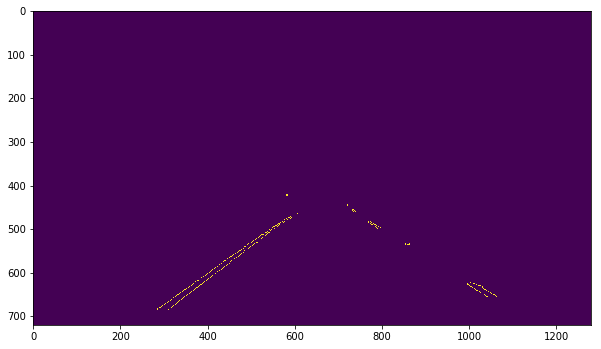

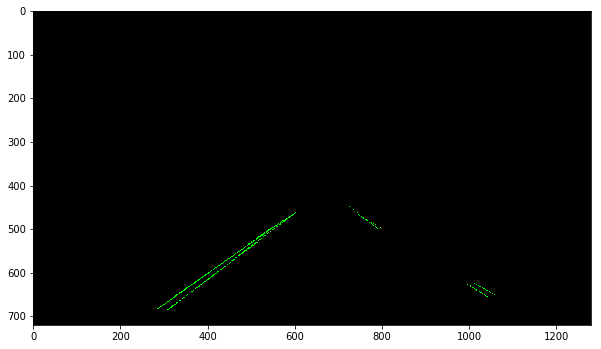

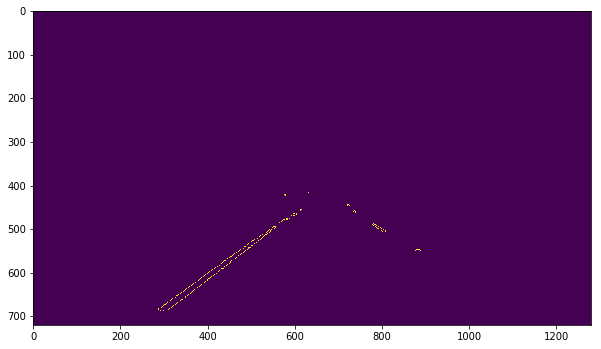

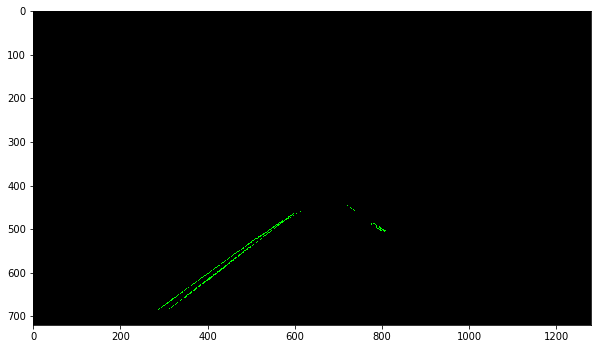

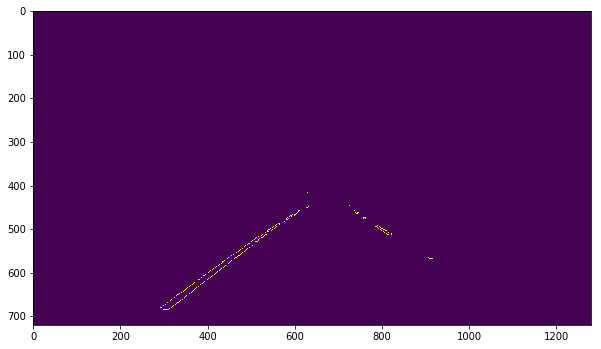

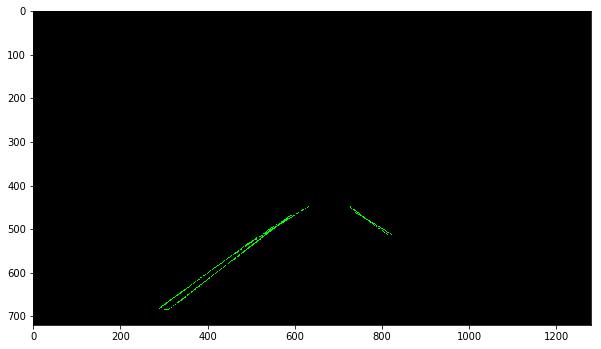

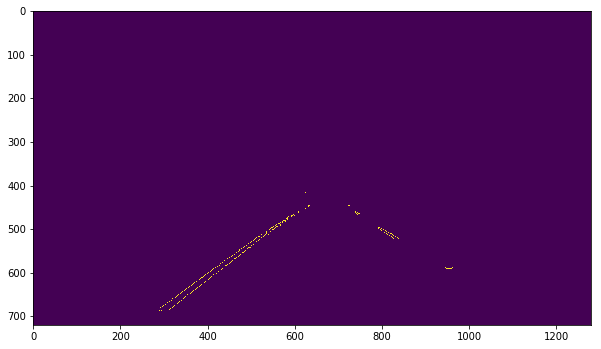

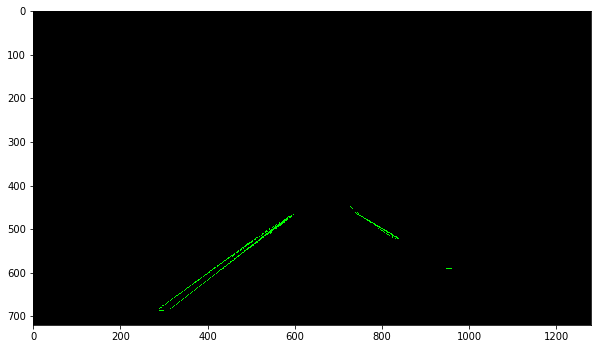

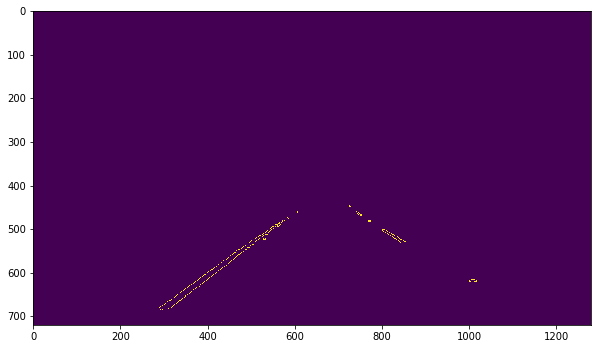

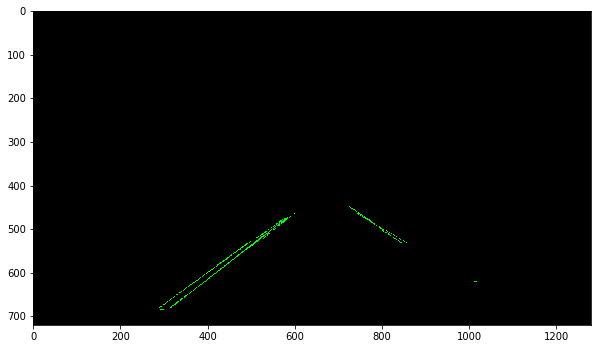

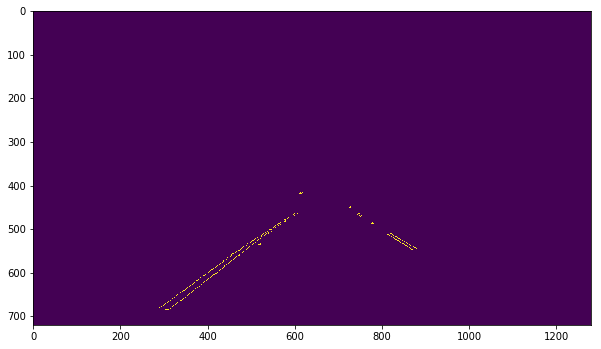

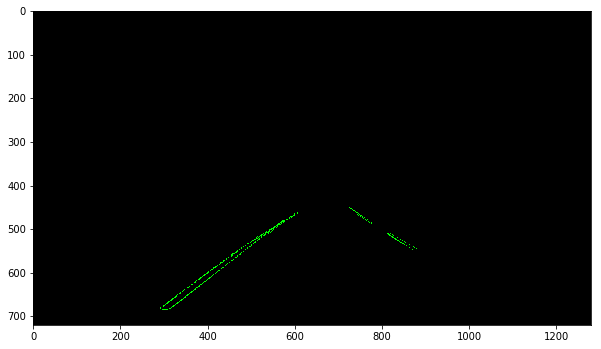

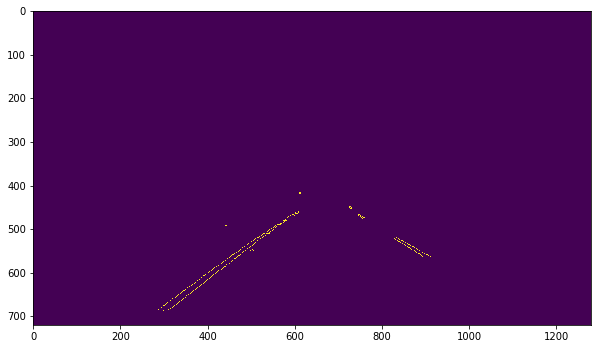

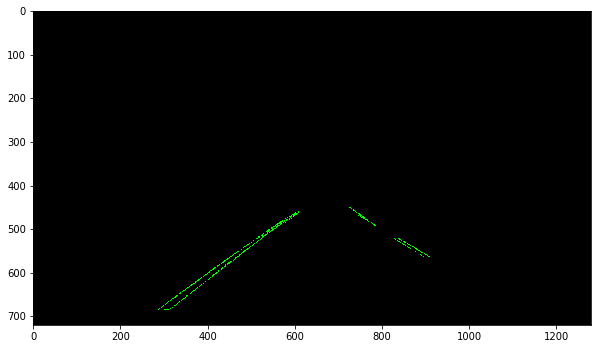

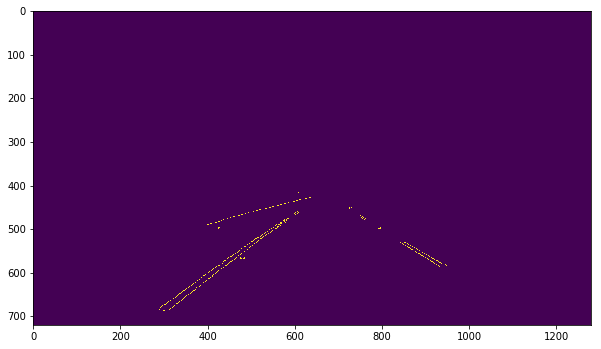

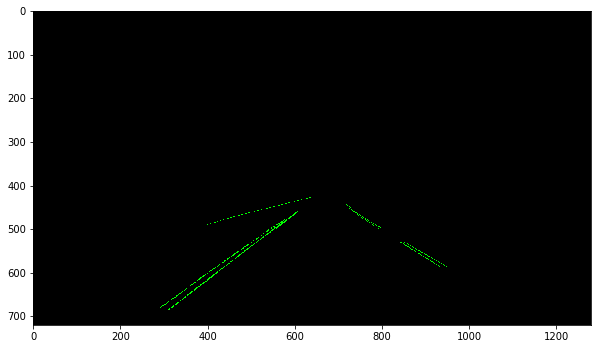

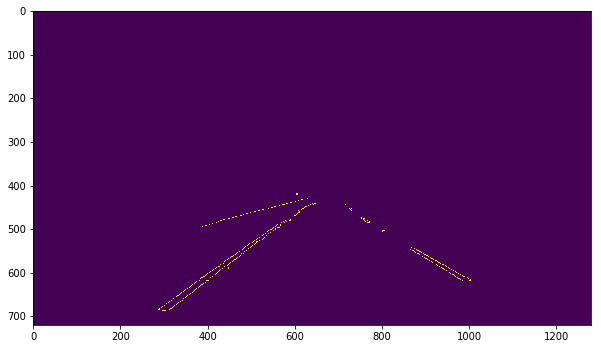

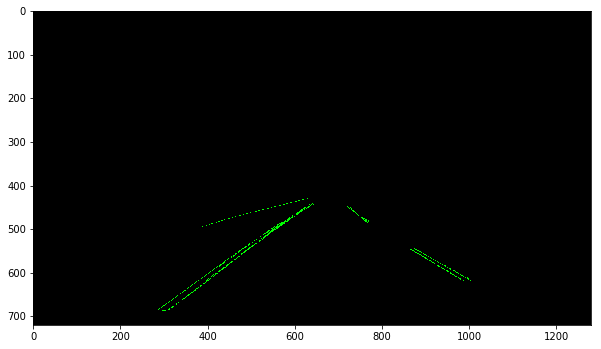

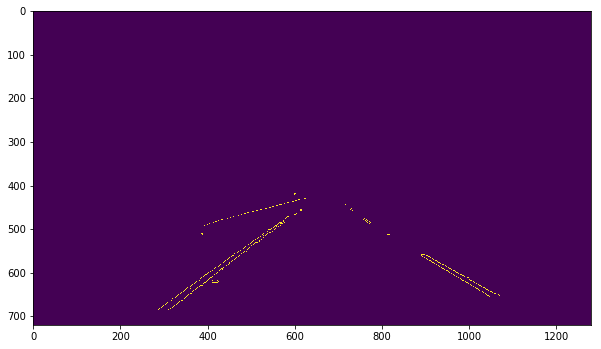

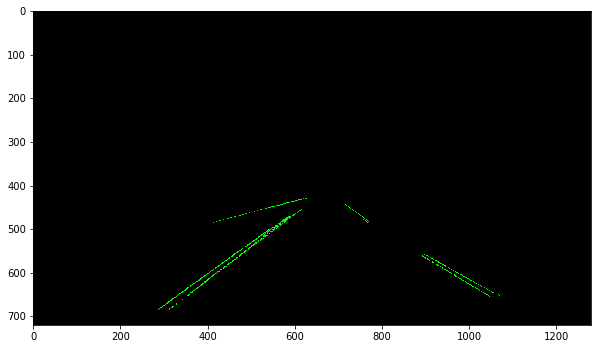

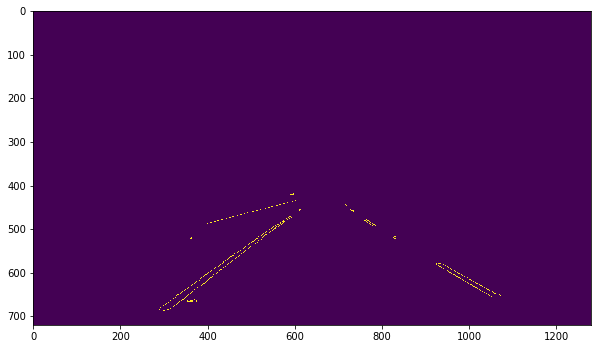

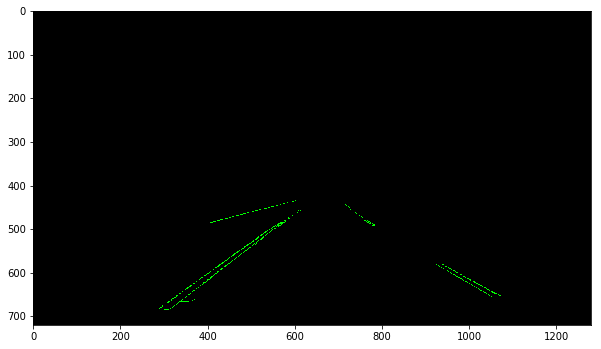

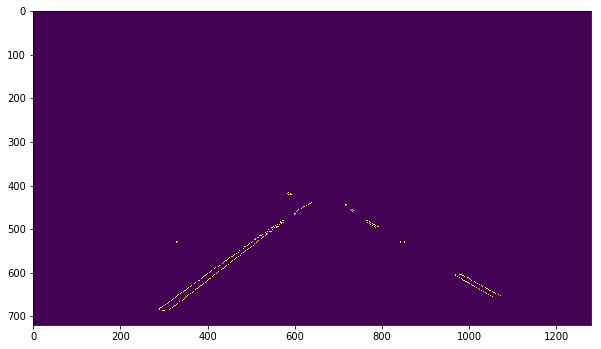

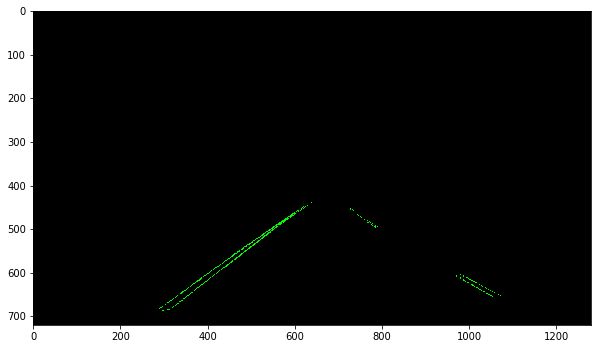

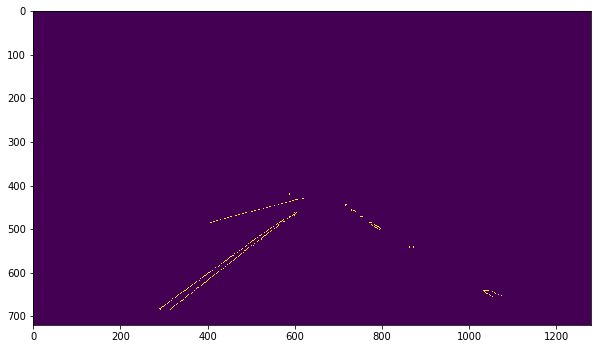

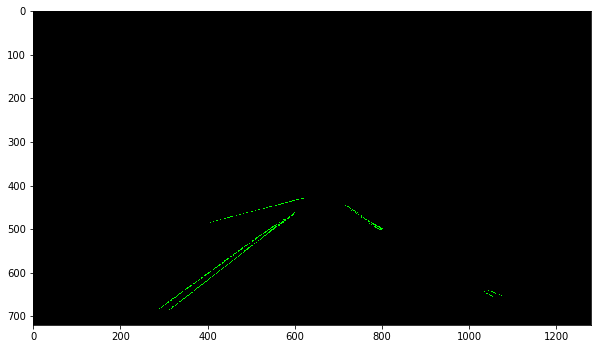

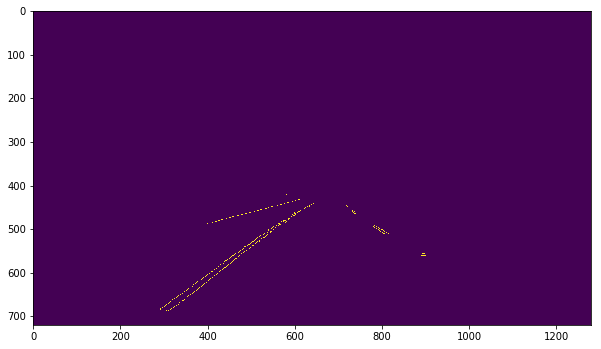

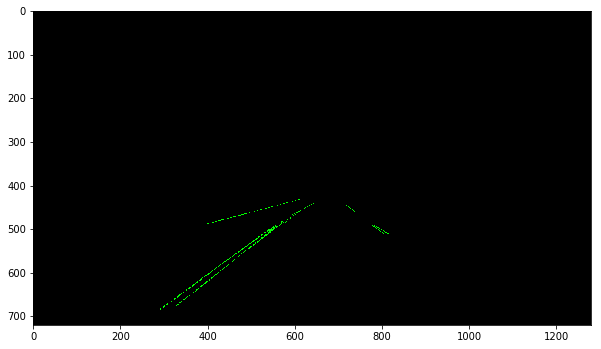

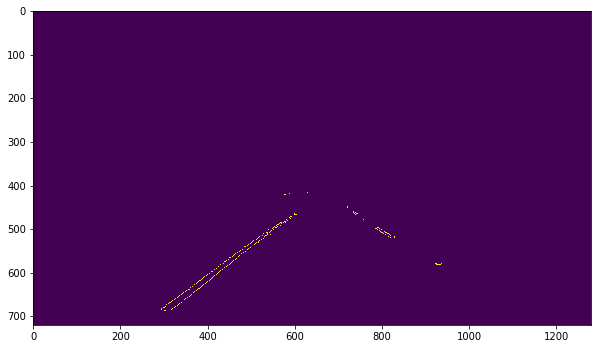

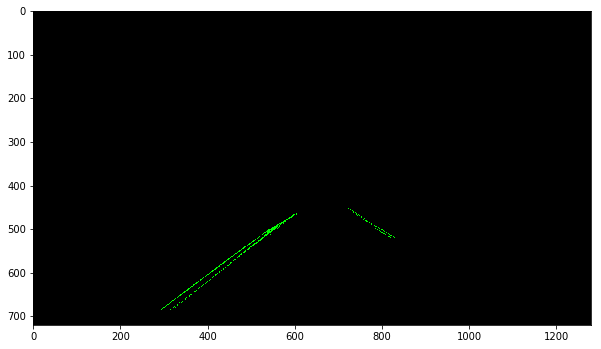

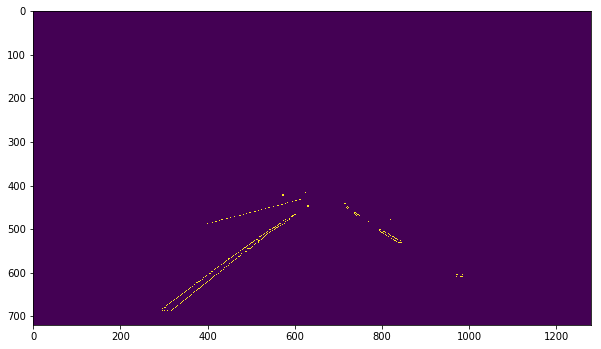

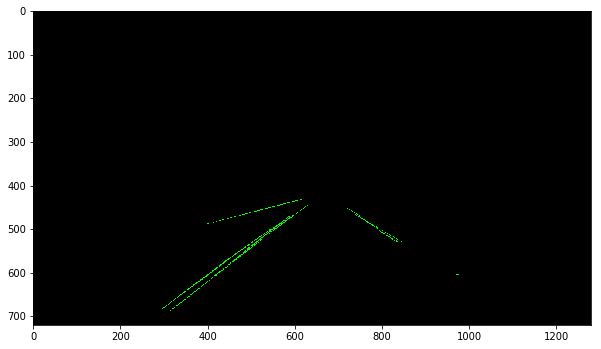

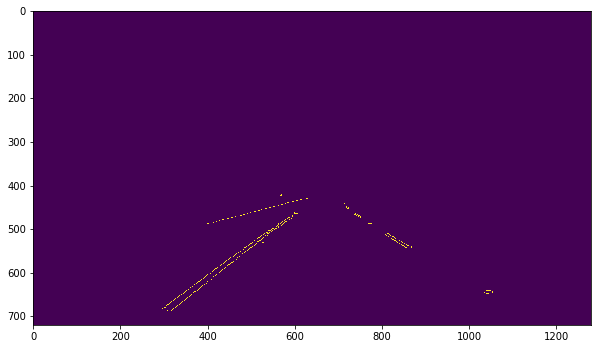

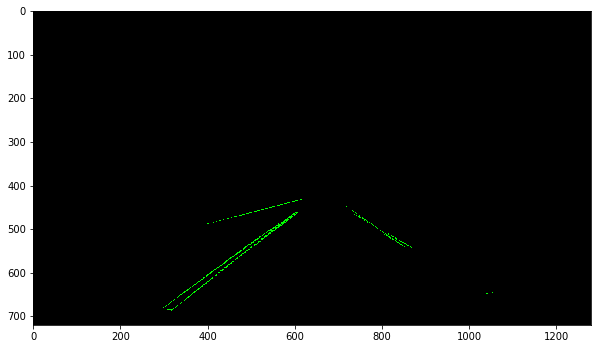

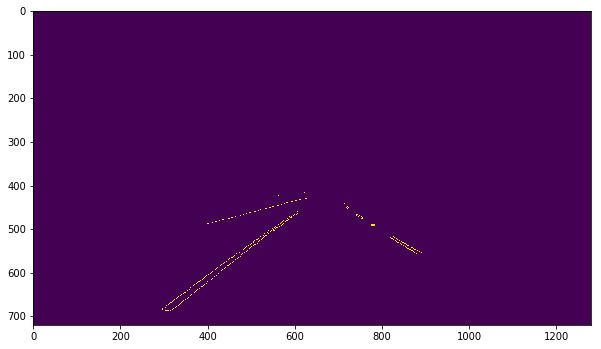

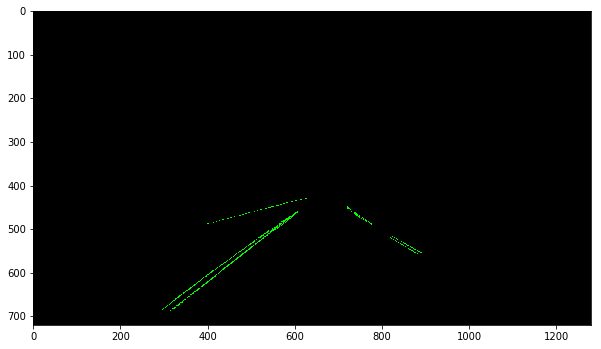

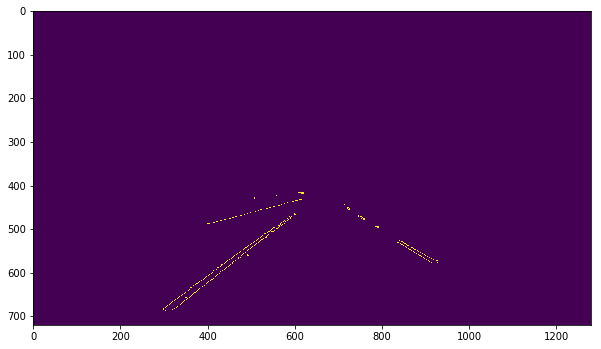

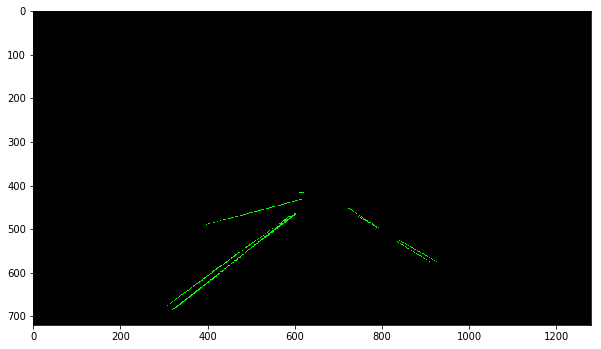

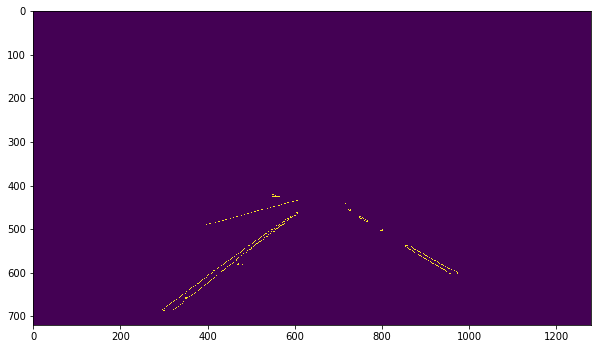

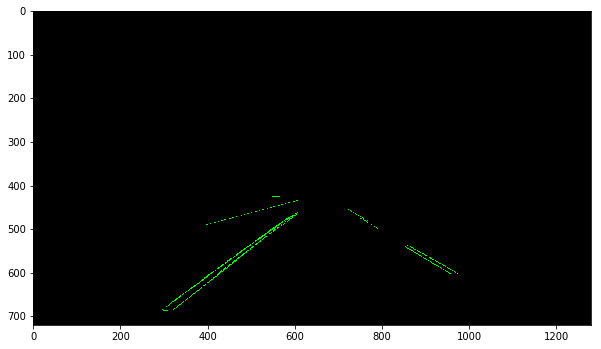

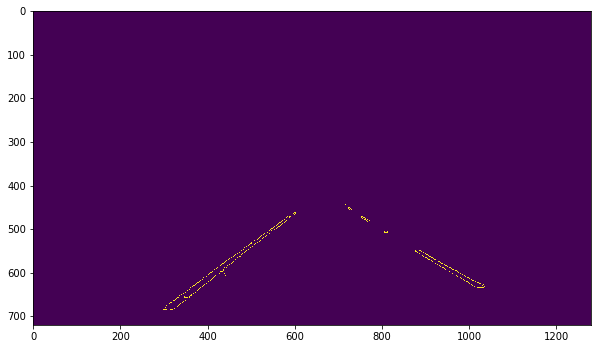

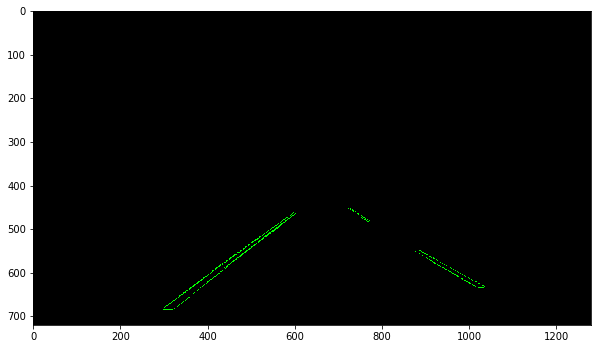

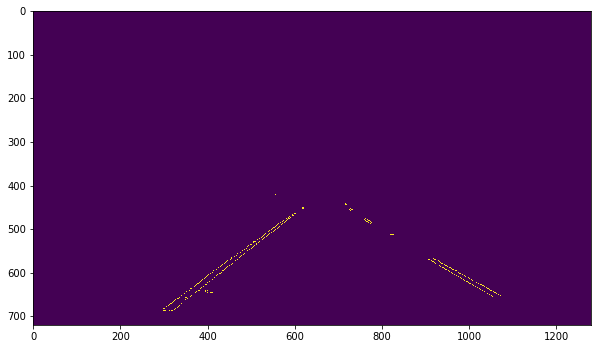

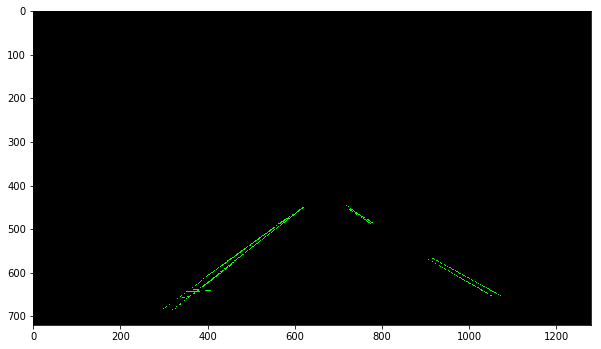

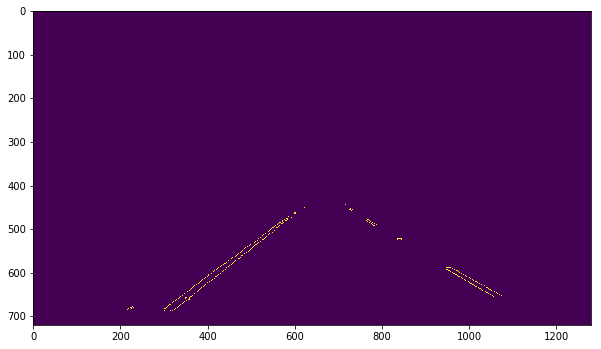

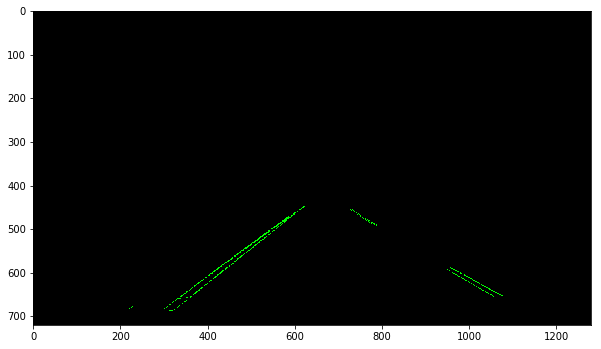

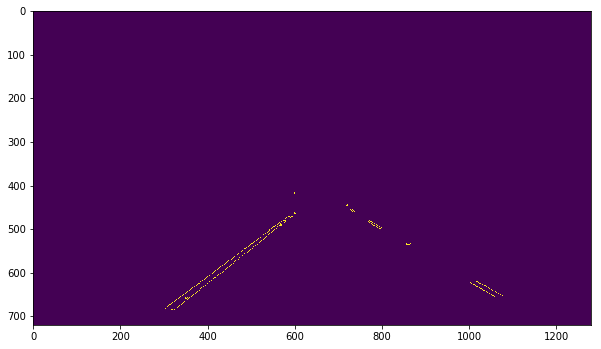

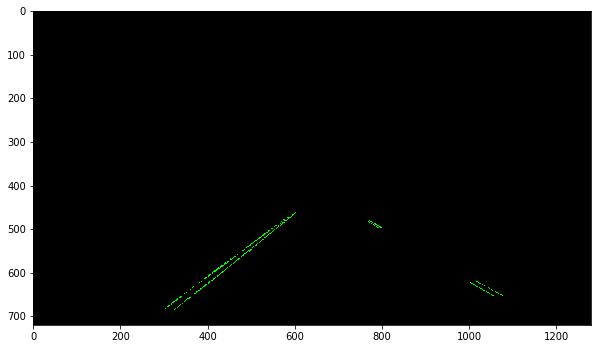

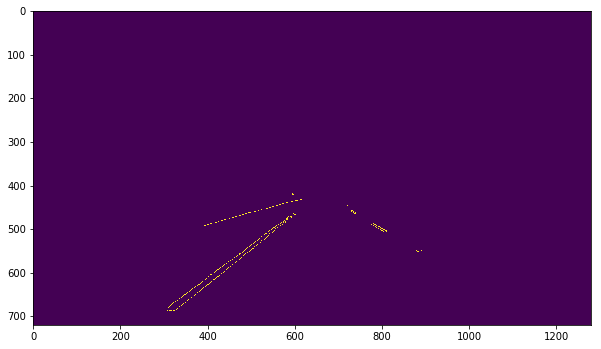

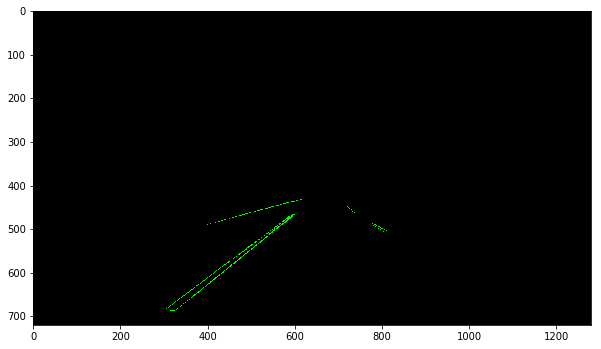

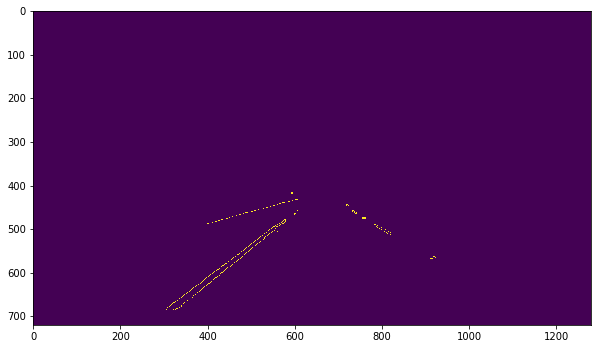

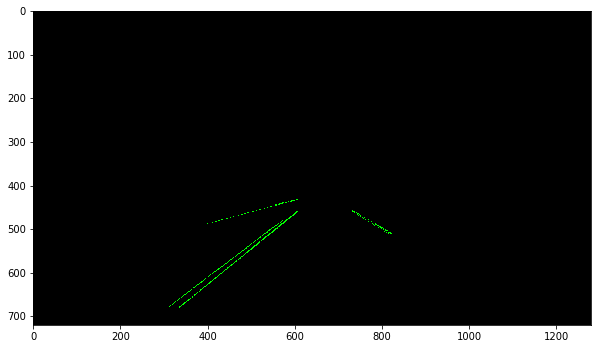

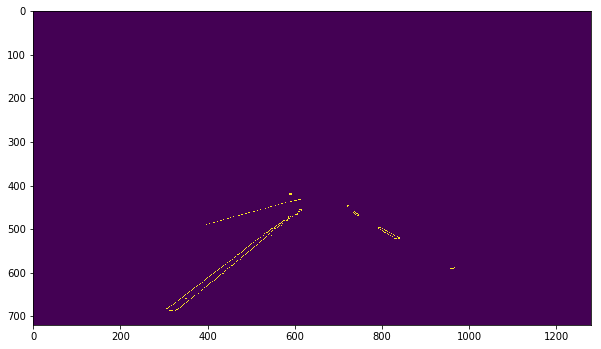

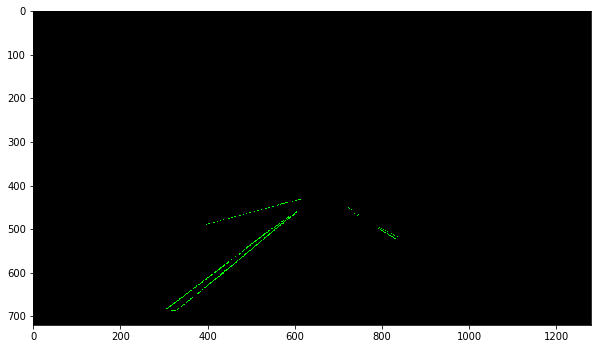

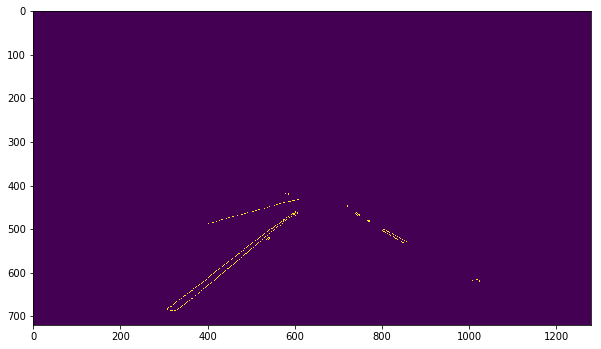

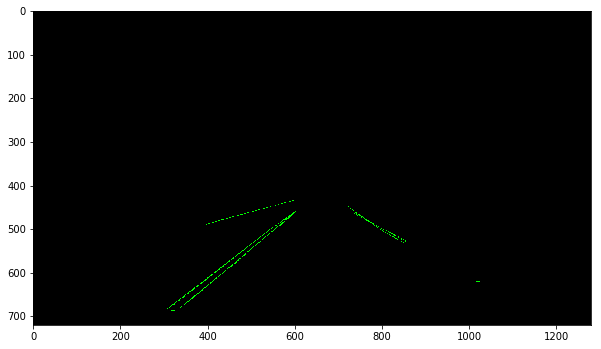

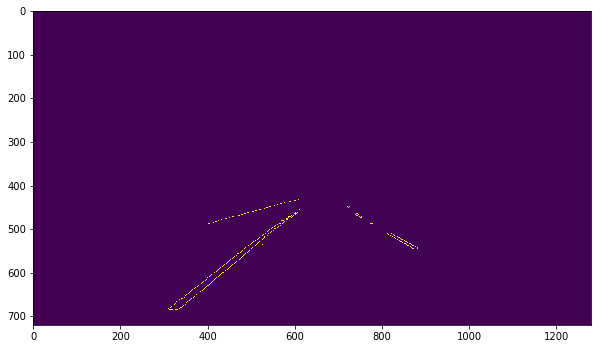

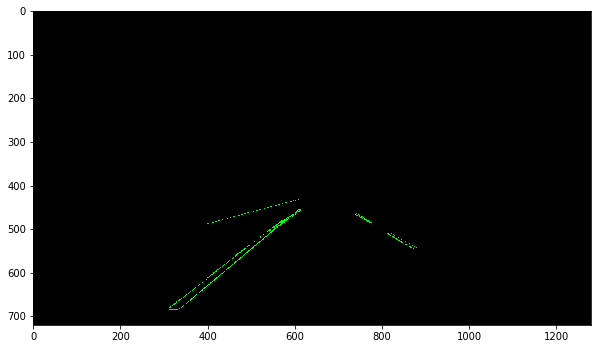

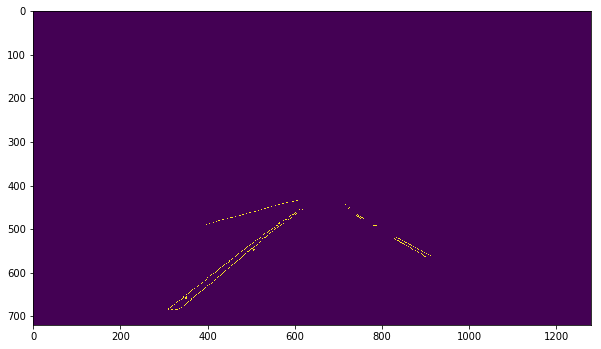

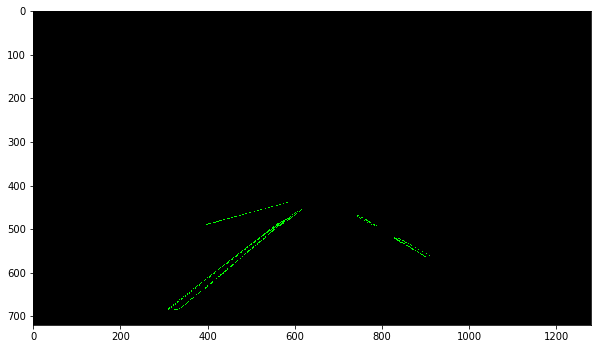

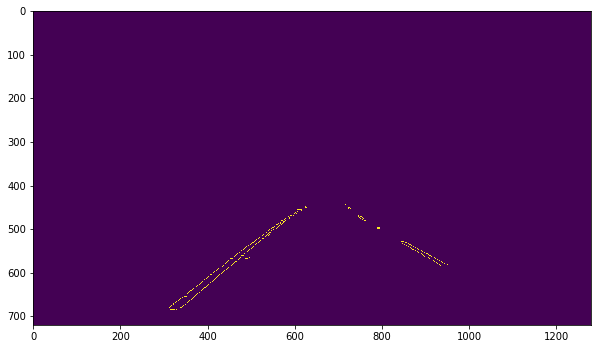

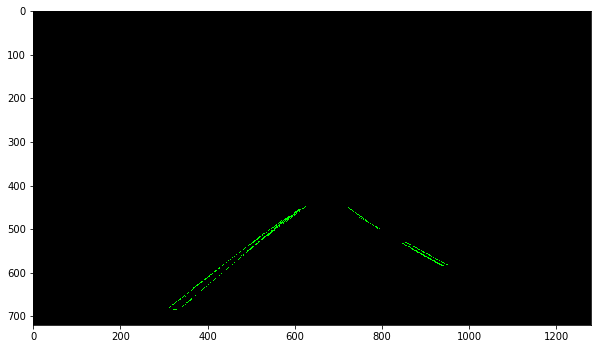

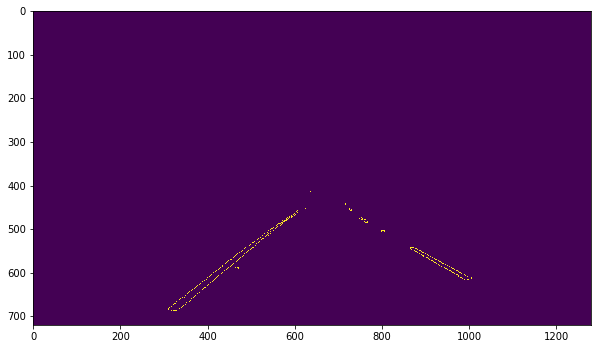

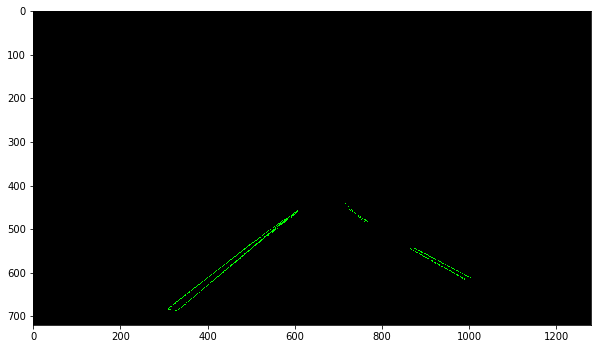

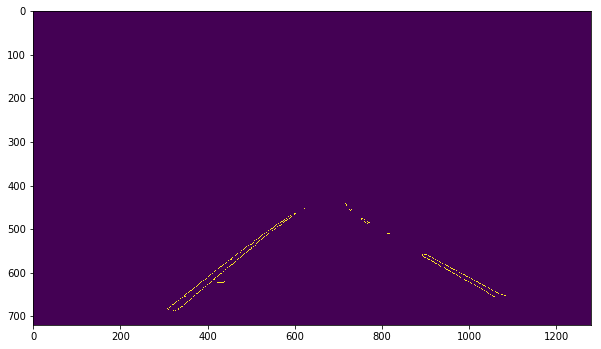

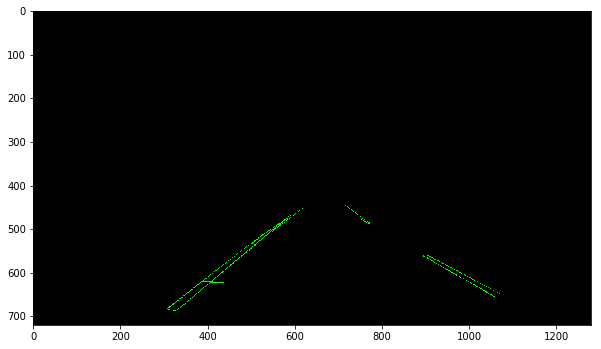

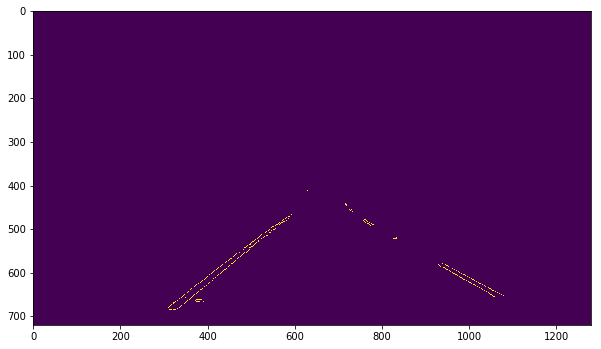

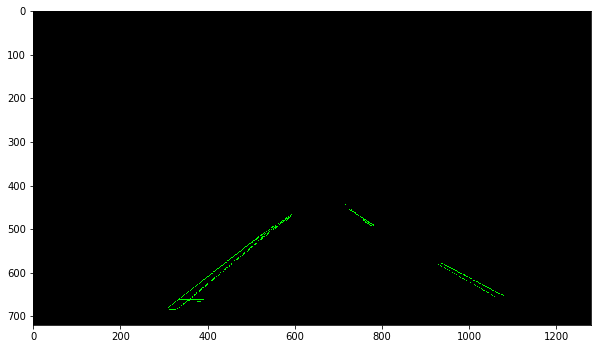

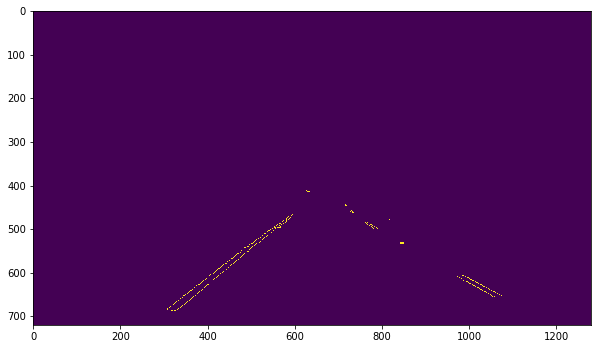

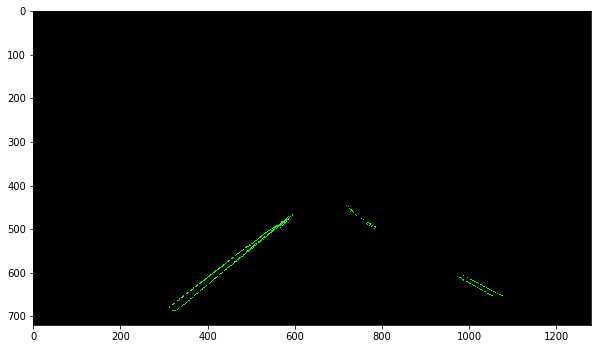

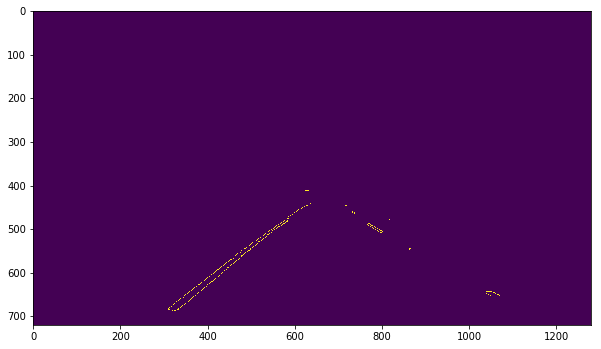

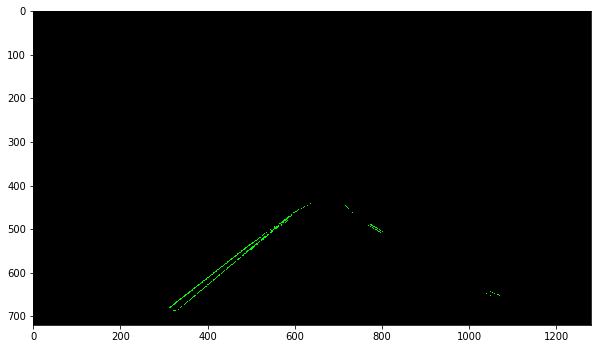

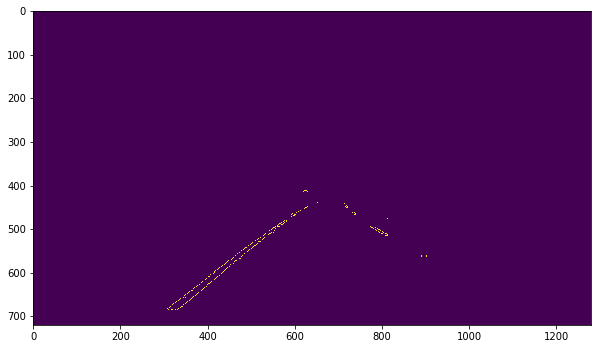

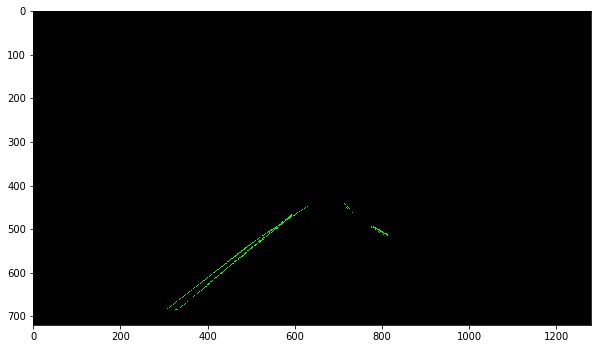

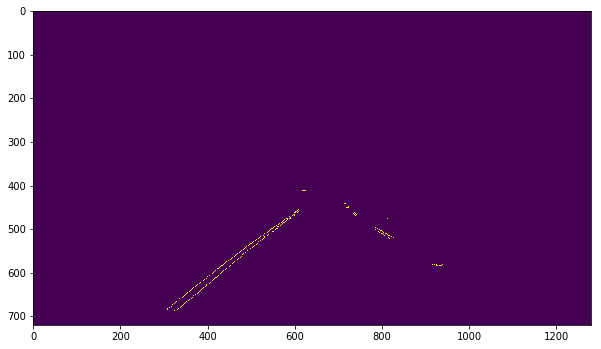

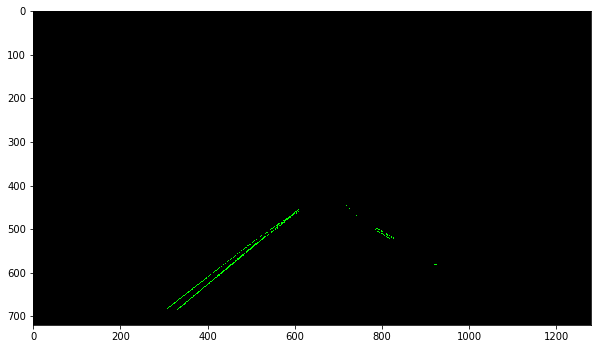

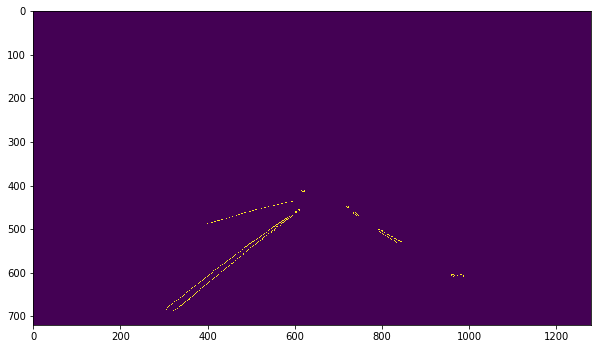

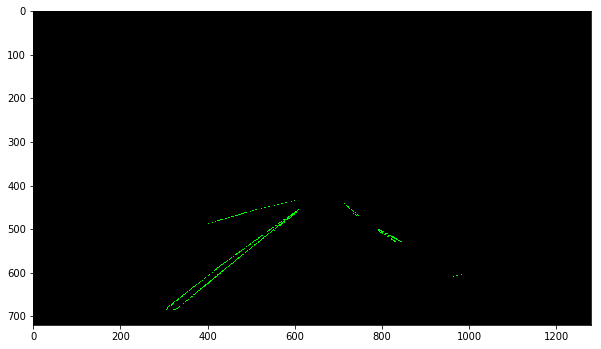

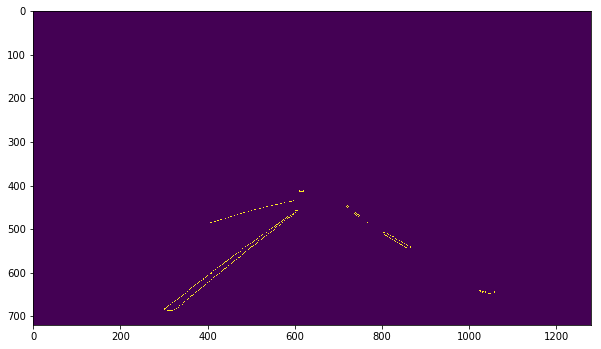

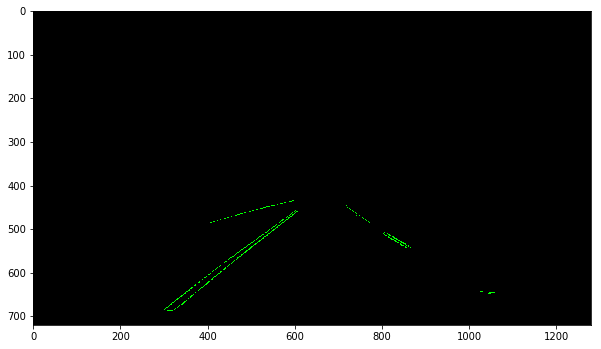

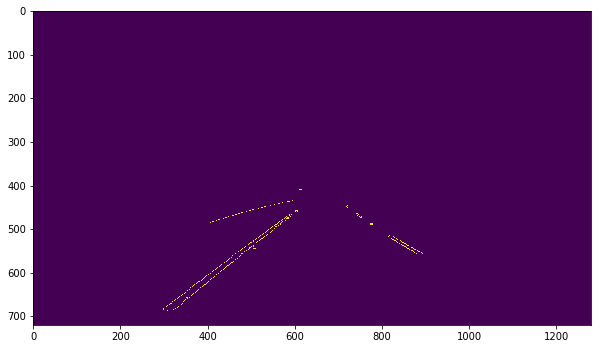

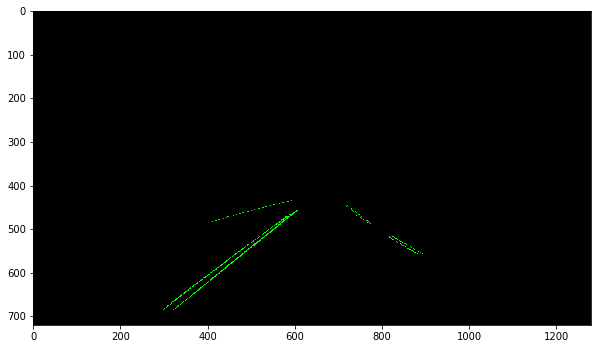

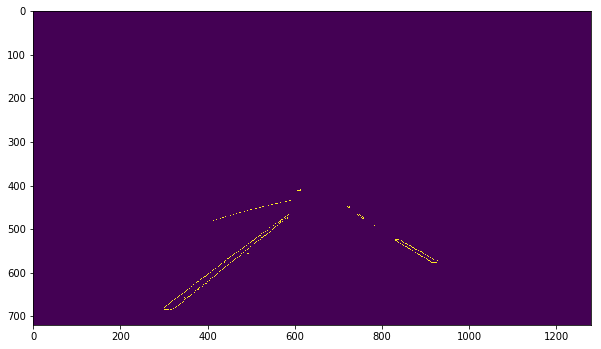

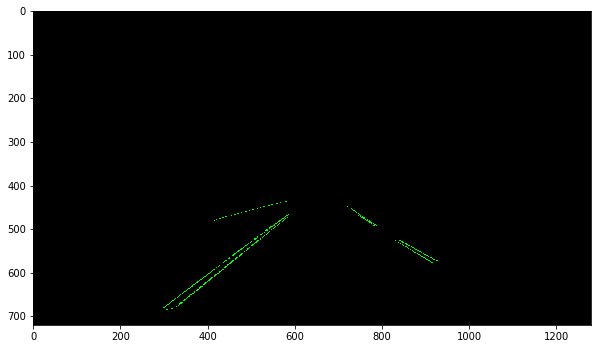

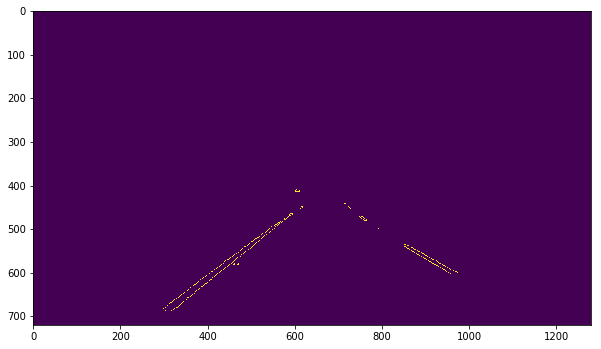

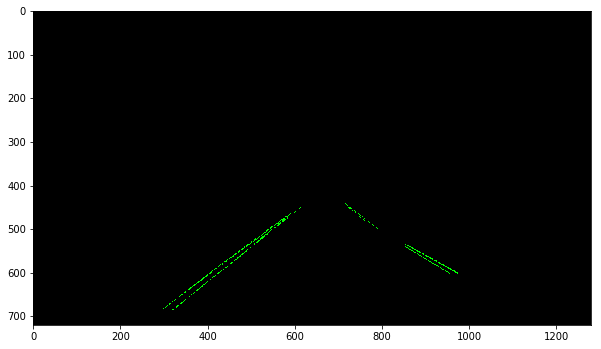

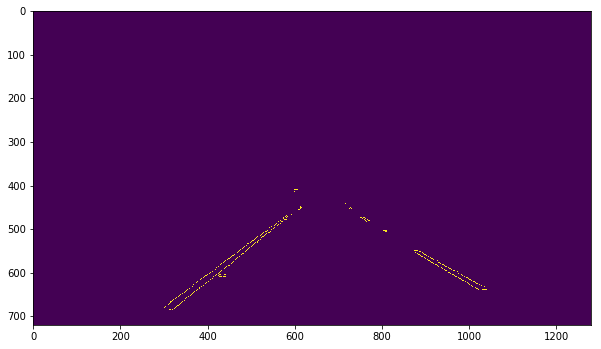

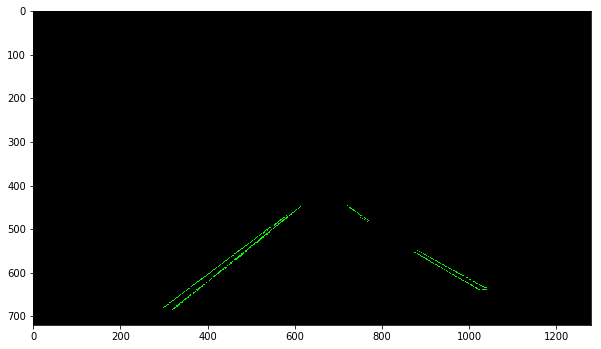

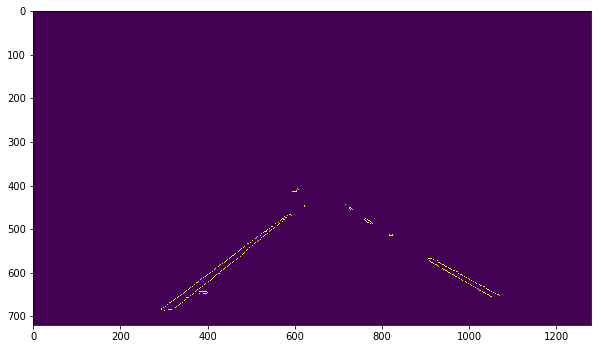

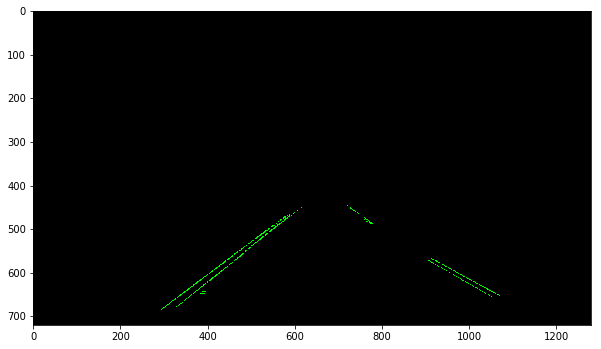

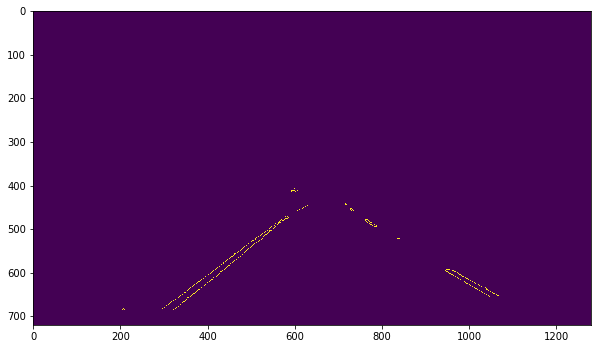

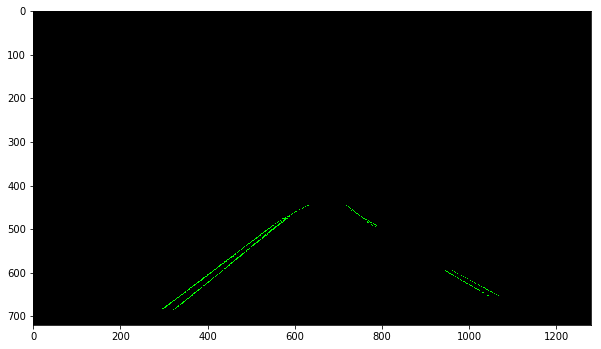

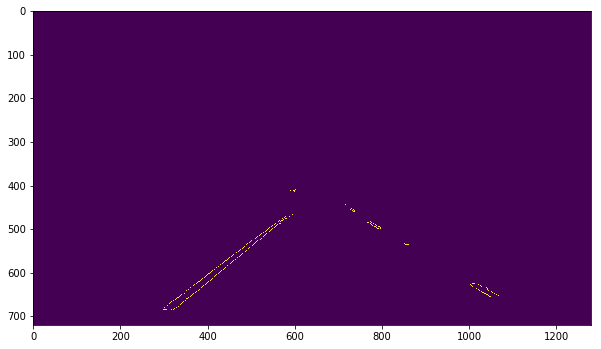

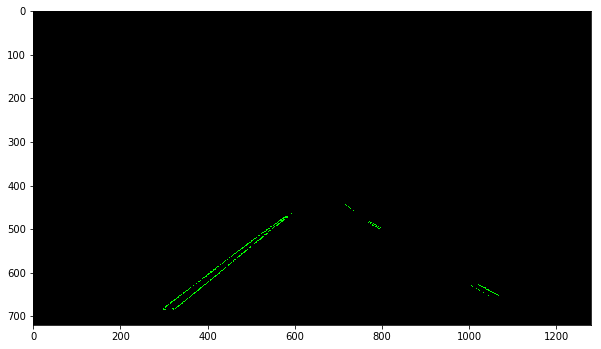

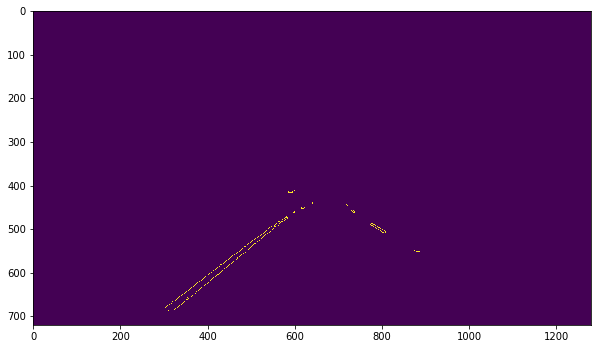

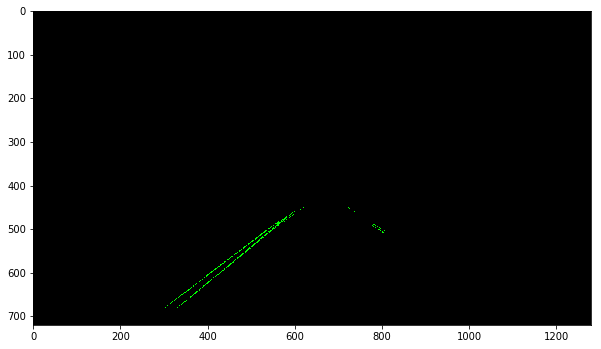

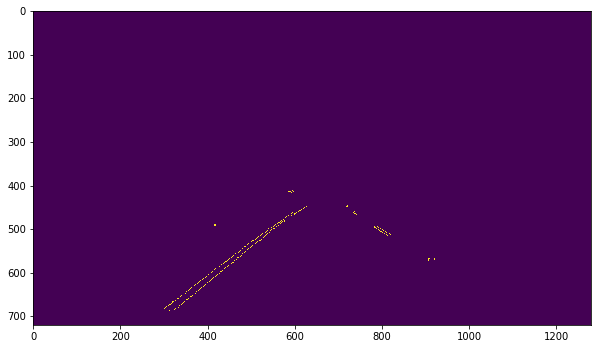

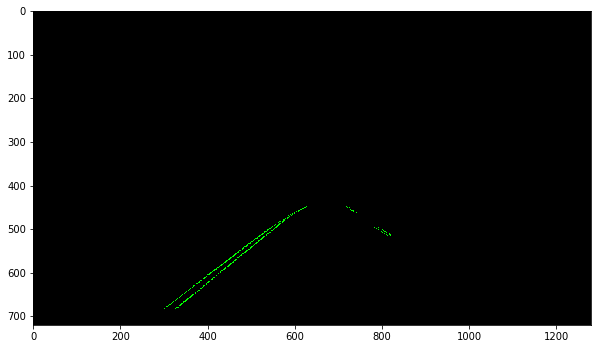

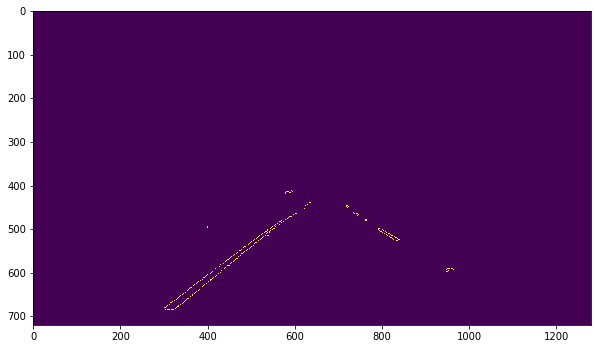

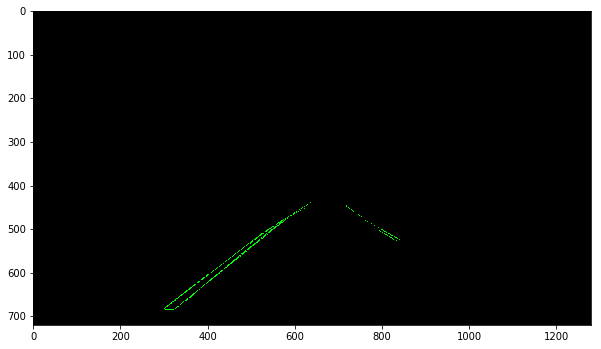

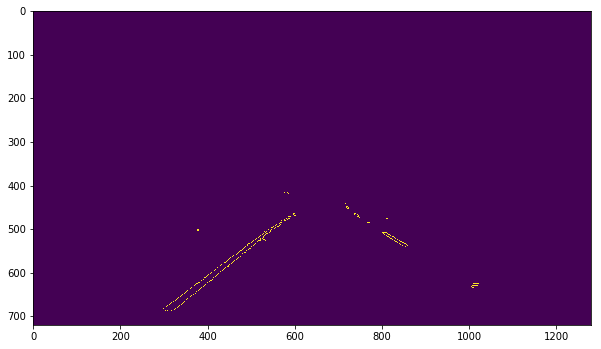

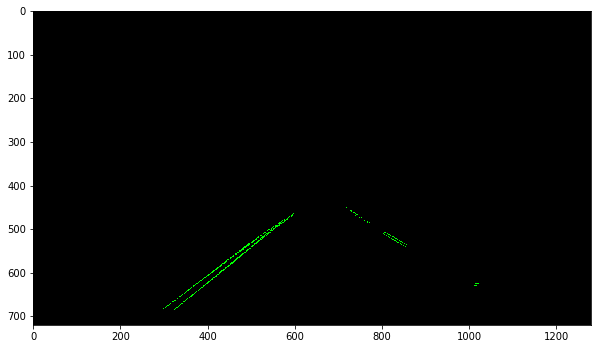

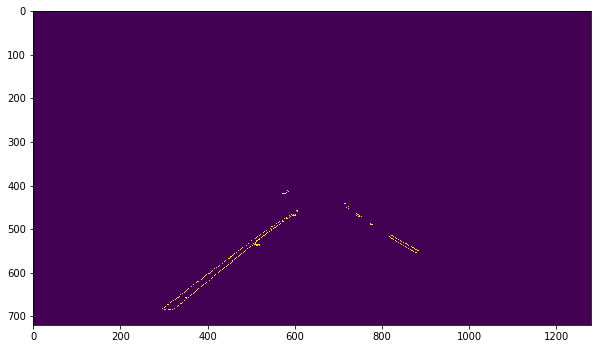

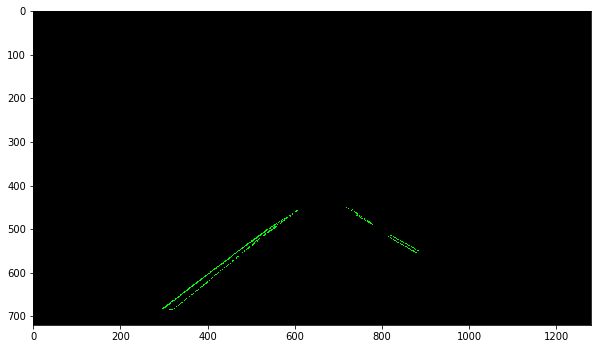

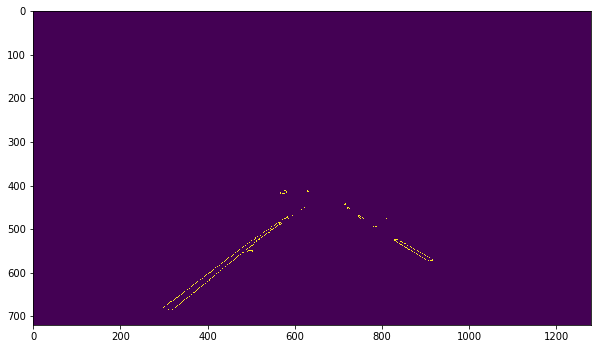

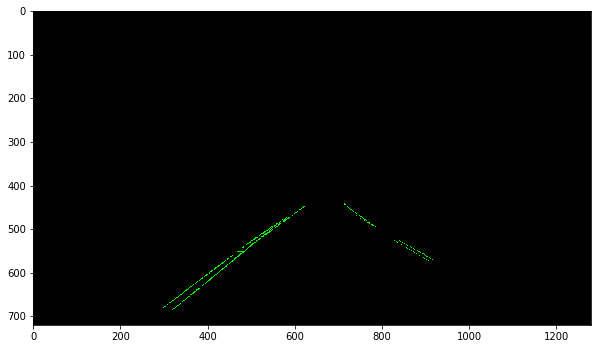

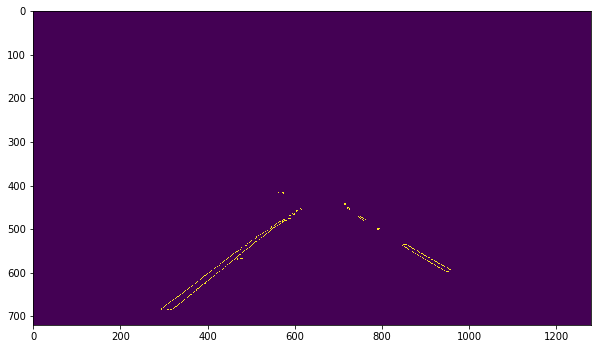

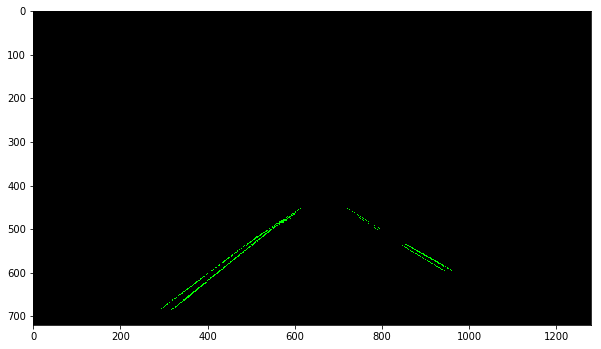

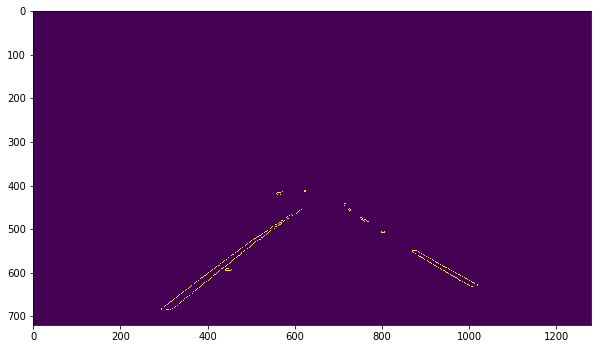

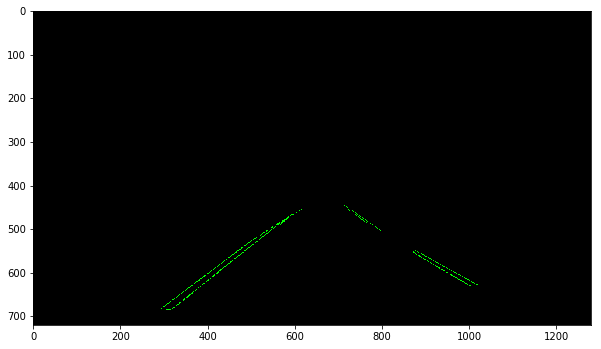

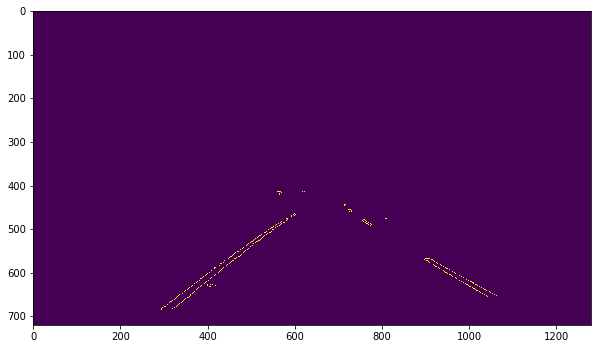

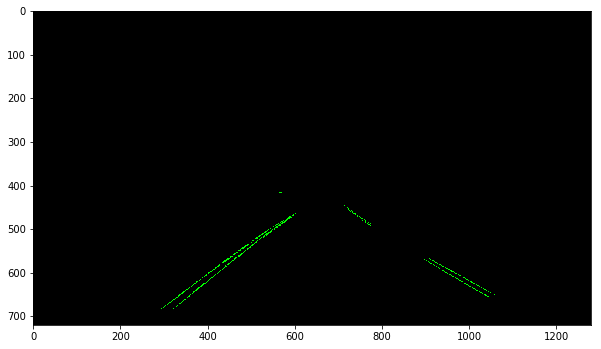

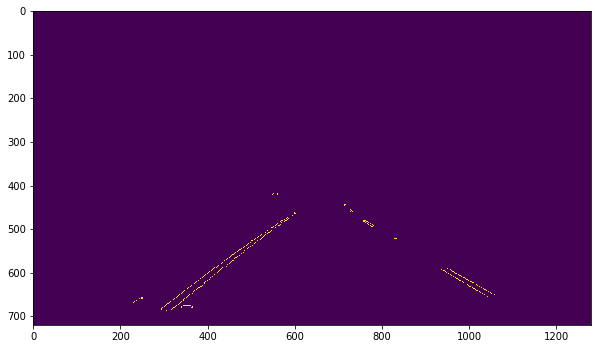

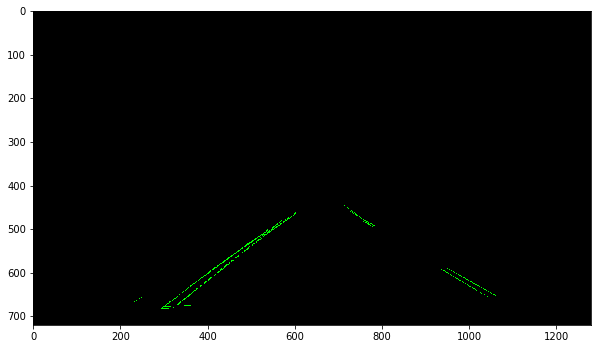

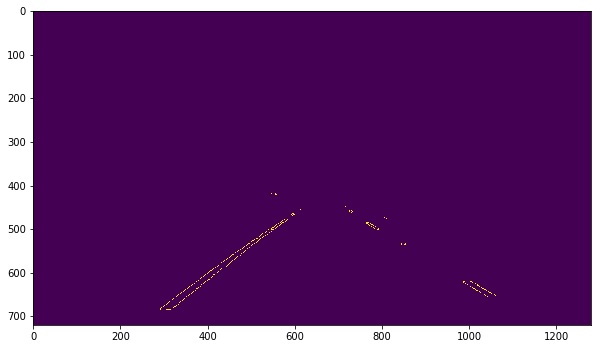

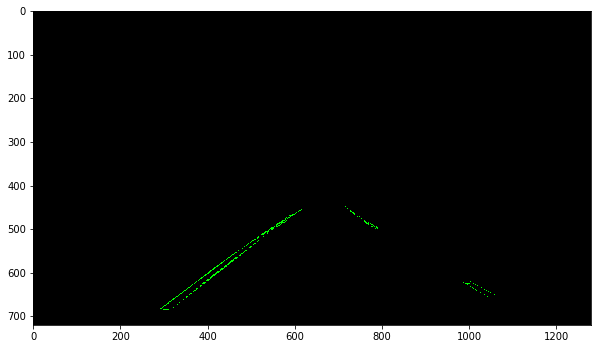

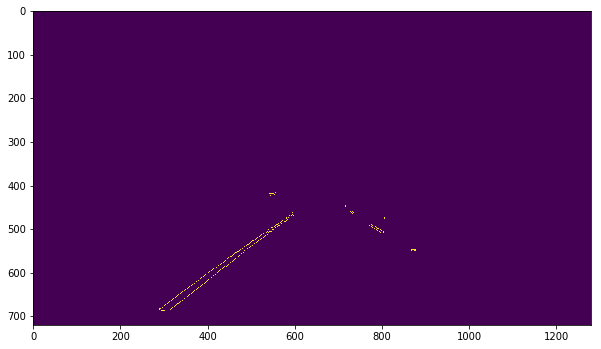

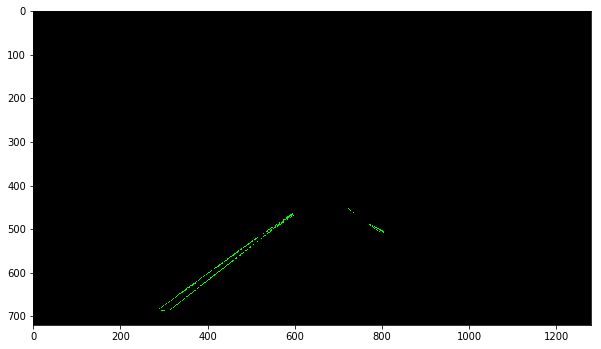

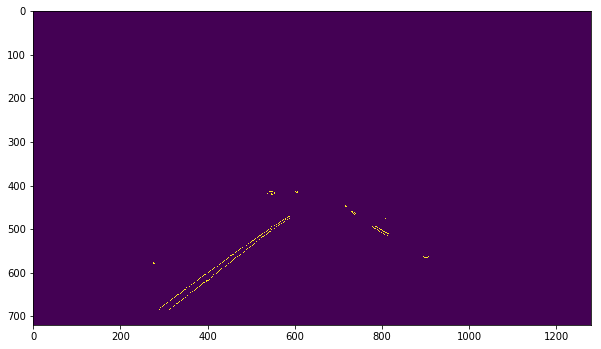

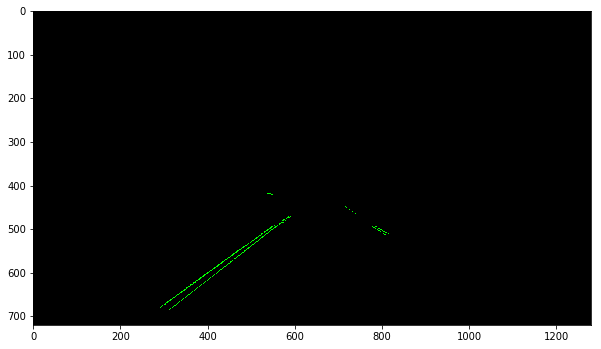

In [35]:
output = 'video_3_sol.mp4'
clip = VideoFileClip("video_3.mp4")
out_clip = clip.fl_image(process_an_image)
out_clip.write_videofile(output, audio=False)